# Time Series - Motifs and Discords
Data Understanding and Preparation
- Explore and prepare the time series dataset.
- Preprocess the dataset in order to be able to run time series
clustering; motif/anomaly discovery and classification. If the dataset is
too big for these tasks, you can use approximations (e.g. SAX, PAA etc)

Motifs/Discords
- Analyze the dataset for finding motifs and/or anomalies. Visualize and
discuss them and their relationship with shapelets.

Clustering
- Use at least two clustering algorithm on time series using an
appropriate distance.
- Analyze the clusters and highlight similarities and differences and
visualize the clusters using at least 2 dimensionality reduction
techniques.

Classification
Define one (or more) classification task and solve it using:
- KNN with at least two distances
    - Euclidean/Manhattan
    - DTW
    - Shapelets
    - Analyze the shapelets retrieved
- At least one other method (rocket, muse, cnn, rnn etc)

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
                            
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import ADASYN

from sklearn.utils import shuffle
import random

from IPython.display import Audio 
import pathlib
from tqdm.notebook import tqdm
import librosa
import awkward as ak

# Data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

### TS libraries

In [2]:
#Time Series Preprocessing
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

#Distances
from scipy.spatial.distance import euclidean, cityblock
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix

#Time Series Approximation
from scipy.signal import decimate
from pyts.approximation import DiscreteFourierTransform, SymbolicAggregateApproximation
from sklearn.decomposition import TruncatedSVD, randomized_svd
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation

#Time Series Clustering
from tslearn.clustering import TimeSeriesKMeans
from matplotlib.pyplot import cm

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

#evaluation
from sklearn.metrics import silhouette_score,rand_score, adjusted_rand_score, mutual_info_score,\
                                adjusted_mutual_info_score, v_measure_score, fowlkes_mallows_score

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from dtaidistance import dtw

#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

#Matrixprofile
from matrixprofile import *
from matrixprofile.discords import discords
import stumpy
import kds #for the lift

In [3]:
def imp_data_npy(data_filename, data_npy, fraction = 0.25, emotions = 8):
    # default emotions = 8, else change emotions to 3 (only 3 supported)
    
    df_all = pd.concat([pd.read_csv(data_filename)['emotion'], pd.DataFrame(np.load(data_npy))], axis = 1)
    #df_all = pd.read_csv(data_filename)
    df_all.head()

    # TRAIN and TEST datasets split (and labels)
    targ = 'emotion'
    labels = df_all.pop(targ)
    df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]

    # Label Encoder
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    label_encoder_name_mapping = dict(zip(le.classes_,
                                             le.transform(le.classes_)))
    #print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

    # splitting the labels in train and test
    labels_train, labels_test = labels[:1828], labels[1828:]
    df_train.insert(0,str(targ),labels_train)
    df_test.insert(0,str(targ),labels_test)

    frac = fraction
    df_train_s = df_train.groupby(targ).sample(frac = frac, random_state=42)

    # new sampled training data
    df_train = df_train_s.copy(deep=True)

    # vars to encode
    #cat_vars = ['emotion']

    # one hot encoding of train df_train and df_test
    #df_train = pd.get_dummies(df_train, columns = cat_vars, prefix = '', prefix_sep='')
    #df_test = pd.get_dummies(df_test, columns = cat_vars, prefix = '', prefix_sep='')

    # converting df_train and df_test into np matrices and arrays
    X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,:1:].values
    y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

    # shuffling train and val concatenation to remove potential pattern bias
    X, y  = shuffle(X, y, random_state=42)

    # scaling the time series
    #scl_mv = TimeSeriesScalerMinMax()
    #X = scl_mv.fit_transform(X)
    #X = np.squeeze(X)

    # selection of only a part (a segment) of the time series for the clustering task
    X_clust = X.copy()
    y_clust = y.copy().astype(np.int8)

    df_clust = pd.concat([pd.DataFrame(y_clust.astype(np.int8).T, columns = [targ]), pd.DataFrame(X_clust)], axis=1)

    # if we want to reduce the classes from 8 to 3 for ex. grouping emotions based on knowledge about the domain
    #if emotions == 3:
    #    high = [0,3,7]
    #    medium = [2,5,6]
    #    low = [1,4]
    #    replacement = {1:0,4:0,2:1,5:1,6:1,0:2,3:2,7:2}
    #    df_clust = df_clust.replace({targ:replacement})
    #    y_clust = df_clust.loc[:,targ].values.astype(np.int8)

    return X_clust, y_clust, df_clust

In [4]:
def imp_data(data_filename, fraction = 0.25, emotions = 8):
    # default emotions = 8, else change emotions to 3 (only 3 supported)
    df_all = pd.read_csv(data_filename)
    df_all.head()

    # TRAIN and TEST datasets split (and labels)
    targ = 'emotion'
    labels = df_all.pop(targ)
    df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]
    
    # Label Encoder
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    label_encoder_name_mapping = dict(zip(le.classes_,
                                             le.transform(le.classes_)))
    print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

    # splitting the labels in train and test
    labels_train, labels_test = labels[:1828], labels[1828:]
    df_train.insert(0,str(targ),labels_train)
    df_test.insert(0,str(targ),labels_test)

    frac = fraction
    df_train_s = df_train.groupby(targ).sample(frac = frac, random_state=42)

    # new sampled training data
    df_train = df_train_s.copy(deep=True)
    # vars to encode
    #cat_vars = ['emotion']

    # one hot encoding of train df_train and df_test
    #df_train = pd.get_dummies(df_train, columns = cat_vars, prefix = '', prefix_sep='')
    #df_test = pd.get_dummies(df_test, columns = cat_vars, prefix = '', prefix_sep='')

    # converting df_train and df_test into np matrices and arrays
    X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,:1:].values
    y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

    # shuffling train and val concatenation to remove potential pattern bias
    X, y  = shuffle(X, y, random_state=42)
    # scaling the time series
    #scl_mv = TimeSeriesScalerMinMax()
    #X = scl_mv.fit_transform(X)
    #X = np.squeeze(X)

    # selection of only a part (a segment) of the time series for the clustering task
    X_clust = X.copy()
    y_clust = y.copy().astype(np.int8)

    df_clust = pd.concat([pd.DataFrame(y_clust.astype(np.int8).T, columns = [targ]), pd.DataFrame(X_clust)], axis=1)

    # if we want to reduce the classes from 8 to 3 for ex. grouping emotions based on knowledge about the domain
    #if emotions == 3:
    #    high = [0,3,7]
    #    medium = [2,5,6]
    #    low = [1,4]
    #    replacement = {1:0,4:0,2:1,5:1,6:1,0:2,3:2,7:2}
    #    df_clust = df_clust.replace({targ:replacement})
    #    y_clust = df_clust.loc[:,targ].values.astype(np.int8)

    return X_clust, y_clust, df_clust

In [5]:
def dft_inverse_trasform(X_dft, n_coefs, n_timestamps):
    # Compute the inverse transformation
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

In [6]:
def dtw_and_matrix(X_clust):
    X_clust = np.squeeze(X_clust)
    distance_matrix = []
    m = len(X_clust)    
    for i in range(0, m - 1):
        for j in range(i + 1, m):
            distance_matrix.append(dtw.distance_fast(X_clust[i].astype('double'), X_clust[j].astype('double')))
    
    distance_matrix = np.array(distance_matrix)
    d_mat = squareform(distance_matrix)

    return distance_matrix, d_mat
    

In [7]:
np.random.seed(42)  # for reproducibility

In [8]:
# trimming the ts at some threshold
#Xdf_trimmed = []
#for ts in Xdf:
#    ts_trimmed = ts[np.abs(ts) > 0.02]
#    Xdf_trimmed.append(ts_trimmed)

## Matrix Profile

In [9]:
w = 300

### SAX

In [10]:
Xdf_sax, ydf_sax, df_sax = imp_data('data_motdisc\data_200_sax.csv', fraction = 1)
print(Xdf_sax.shape, ydf_sax.shape, df_sax.shape)
df_sax.head()

Mapping of Label Encoded Classes: 
{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}
(1828, 3000) (1828,) (1828, 3001)


emotion         0         1         2         3         4         5  \
0        0 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
1        5 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801   
2        6 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
3        4  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
4        4  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   

          6         7         8         9        10        11        12  \
0 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
1 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801   
2 -0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
3  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
4  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   

         13        14        15        16        17        18        19  \
0 -0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
1 -0.018801 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
2  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
3  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
4  0.006267  0.018801  0.018801  0.018801  0.018801  0.018801  0.018801   

         20        21        22        23        24        25        26  \
0  0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
1 -0.006267  0.018801  0.018801  0.018801  0.018801  0.018801  0.018801   
2  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
3  0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
4  0.018801  0.018801  0.018801  0.018801  0.018801  0.018801  0.018801   

         27        28        29        30        31        32        33  \
0 -0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
1  0.018801  0.018801  0.018801  0.018801  0.018801  0.018801  0.018801   
2  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
3 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
4  0.018801  0.018801  0.018801  0.018801  0.018801  0.018801  0.018801   

         34        35        36        37        38        39        40  \
0  0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
1  0.018801  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
2  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
3 -0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
4  0.018801 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   

         41        42        43        44        45        46        47  \
0 -0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
1  0.006267 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801   
2  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
3  0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
4 -0.006267  0.056429  0.056429  0.056429  0.056429  0.056429  0.056429   

         48        49        50        51        52        53        54  \
0  0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
1 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801   
2  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
3 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
4  0.056429 -0.056429 -0.056429 -0.056429 -0.056429 -0.056429 -0.056429   

         55        56        57        58        59        60        61  \
0 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267 -0.006267   
1 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801 -0.018801   
2  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
3 -0.006267  0.006267  0.006267  0.006267  0.006267  0.006267  0.006267   
4 -0.056429  0.119348  0.1

In [11]:
idx_and_emo = [] # first is index, second is encoded class
lab = [x for x in range(8)]
for i,c in enumerate(ydf_sax):
    if c in lab:
        idx_and_emo.append((i,c))
        lab.remove(c)
        continue

idx_emo = []
for x in idx_and_emo:
    idx_emo.append(x[0])

idx_and_emo

[(0, 0), (1, 5), (2, 6), (3, 4), (5, 1), (7, 3), (8, 2), (18, 7)]

In [12]:
labels = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

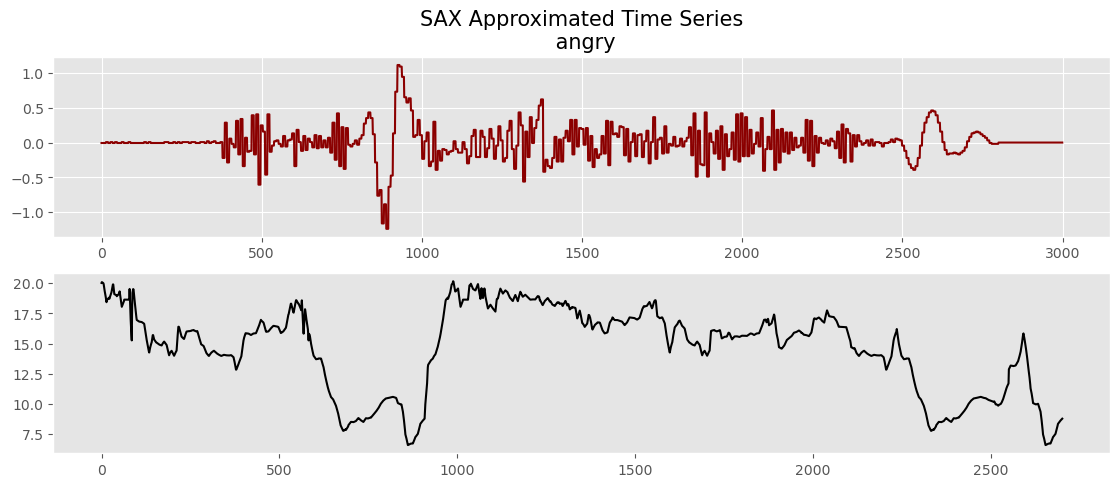

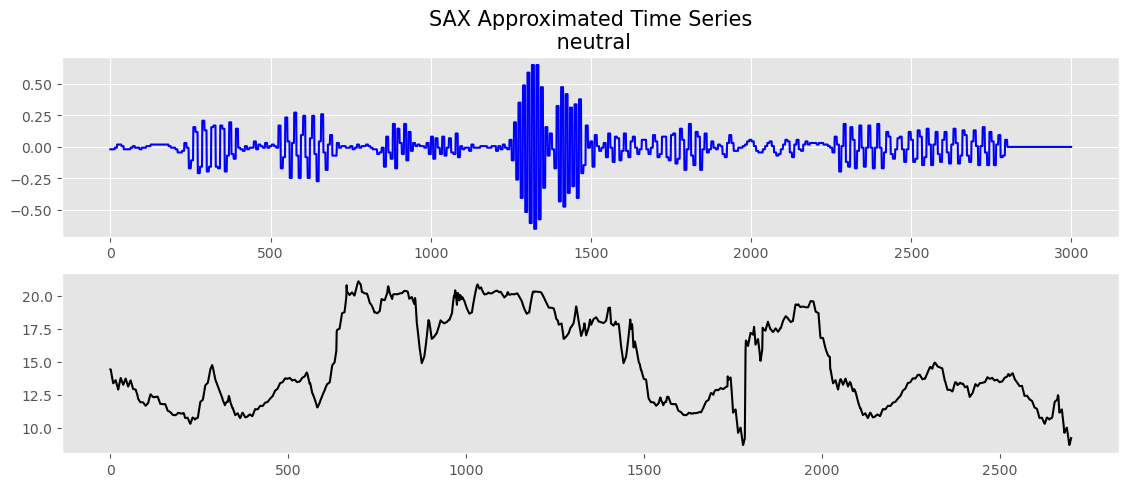

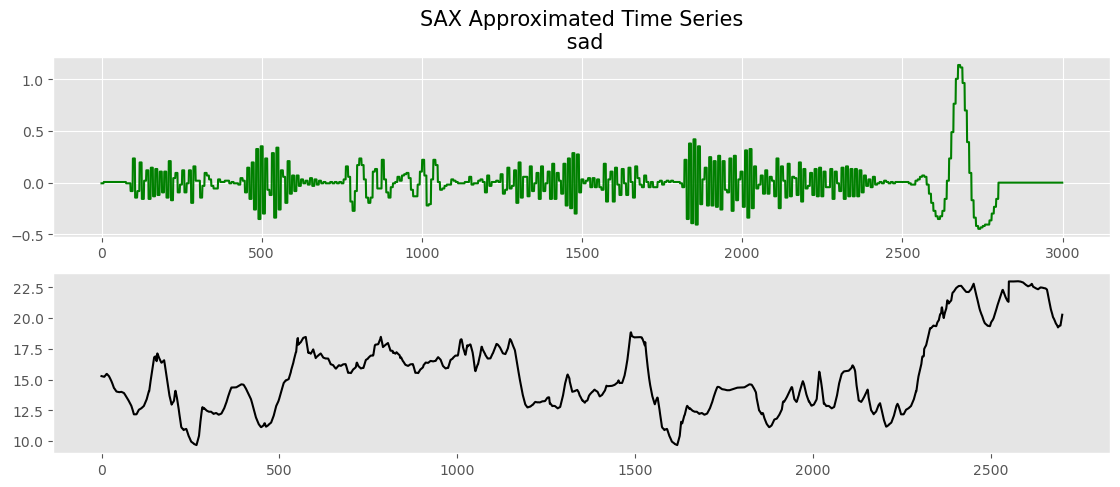

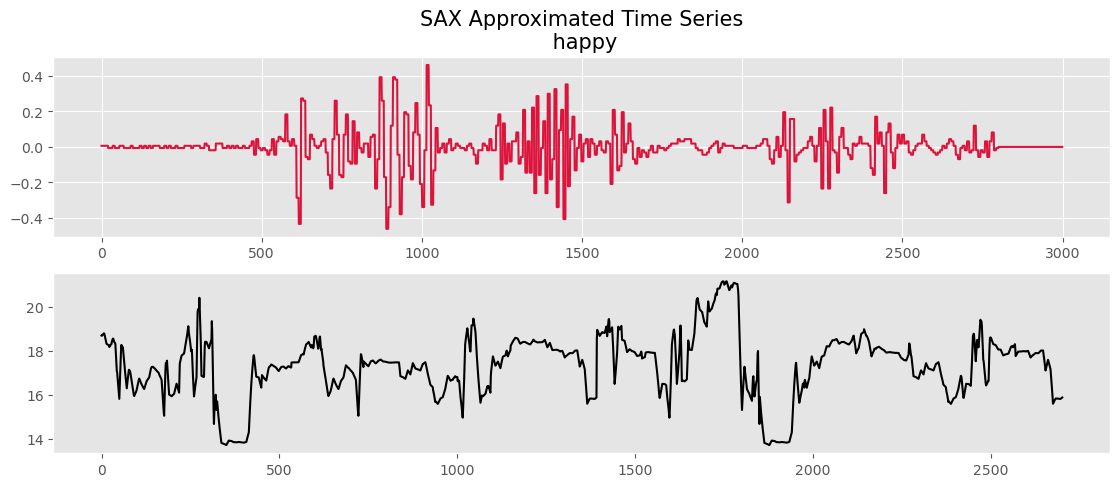

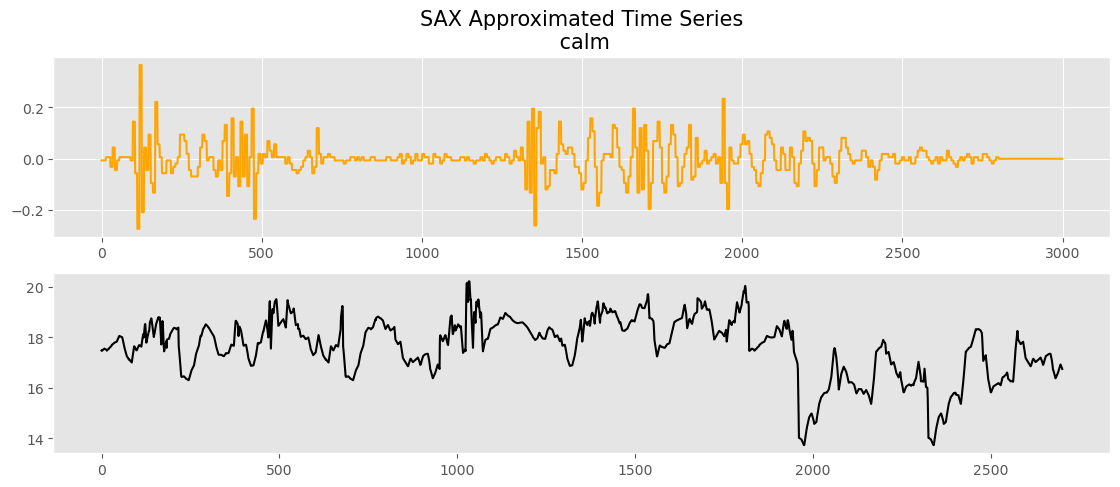

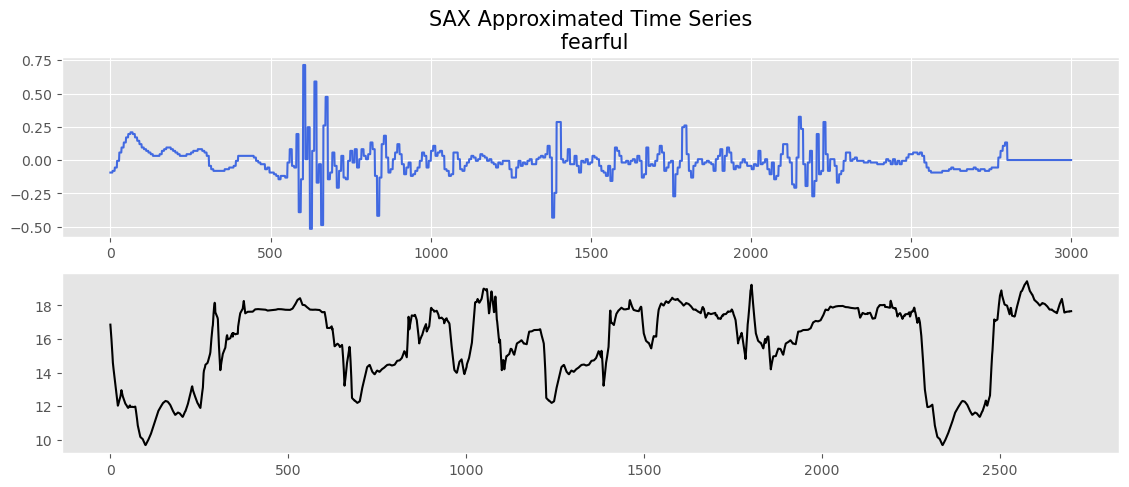

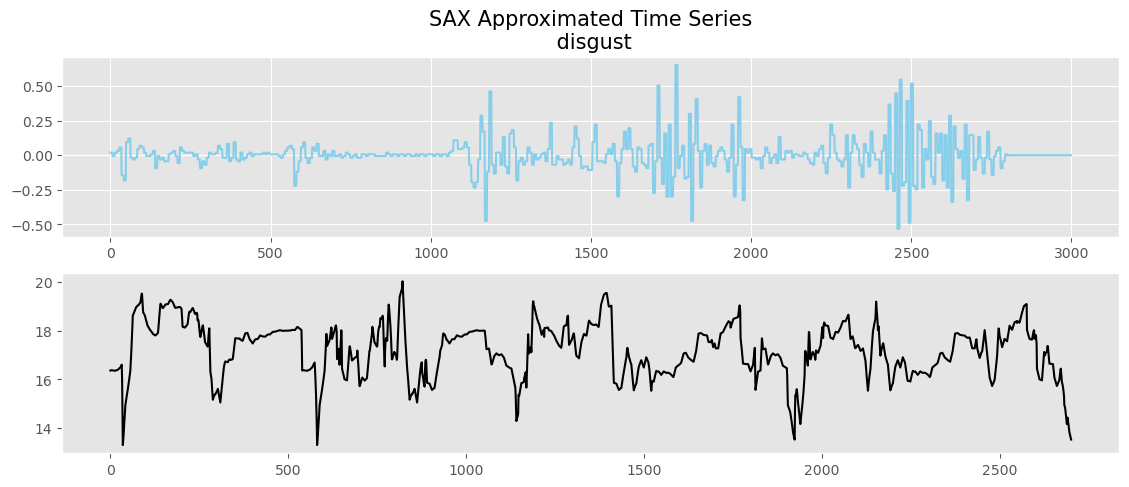

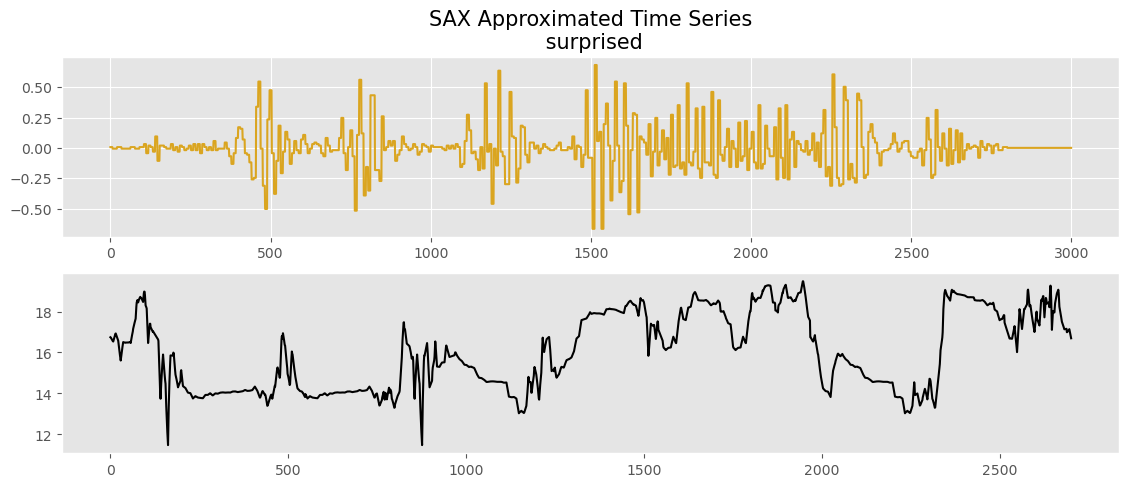

In [13]:
# matrix with one TS for each emotion
ts_sax = df_sax.iloc[idx_emo, 1:].values

col = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
n = 0
mp_dict_sax = {} #fare dict con i diversi mp per emozione
for i,t in enumerate(ts_sax):
    n += 1
    mp_sax, mpi_sax = matrixProfile.stomp(t, w)
    mp_dict_sax[i] = (mp_sax, mpi_sax)
    plt.figure(figsize=(30,22))
    plt.subplot(8, 2, n)
    plt.plot(t, c = col[i])
    plt.title(f"SAX Approximated Time Series\n {labels[idx_and_emo[i][1]]}", fontsize=15)

    plt.subplot(8, 2, n+2)
    plt.plot(mp_sax, c = 'k')
    plt.grid()
plt.show()

In [14]:
# SAX: first -> emotion, second -> (mp, mpi) for such emotion
mp_dict_sax

{0: (array([20.02519945, 20.09330169, 20.07176063, ...,  8.72325953,
          8.75420782,  8.78556859]),
  array([455., 456., 457., ..., 906., 907., 908.])),
 1: (array([14.45005009, 14.43822304, 14.27356652, ...,  9.02197362,
          9.13536859,  9.2508342 ]),
  array([2023., 2024., 2025., ..., 1781., 1782., 1783.])),
 2: (array([15.28976426, 15.28163795, 15.27461423, ..., 19.9180202 ,
         20.0968255 , 20.27942238]),
  array([2156., 2157., 2158., ..., 1036., 1036., 1036.])),
 3: (array([18.69495759, 18.68262471, 18.7035548 , ..., 15.86048546,
         15.8737798 , 15.88713467]),
  array([2219., 2220., 2221., ..., 1389., 1390., 1391.])),
 4: (array([17.48222145, 17.46849893, 17.48201917, ..., 16.8267774 ,
         16.78942176, 16.75180971]),
  array([1820., 1821., 1822., ...,  948.,  949.,  950.])),
 5: (array([16.85952278, 16.58624776, 16.2939313 , ..., 17.65622453,
         17.65874198, 17.66119201]),
  array([2450., 2450., 2450., ...,  913.,  914.,  915.])),
 6: (array([16.3

### DFT

In [15]:
Xdf_dft, ydf_dft, df_dft = imp_data('data_motdisc\data_400_dft.csv', fraction = 1)
print(Xdf_dft.shape, ydf_dft.shape, df_dft.shape)
df_dft.head()

Mapping of Label Encoded Classes: 
{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}
(1828, 3000) (1828,) (1828, 3001)


emotion         0         1         2         3         4         5  \
0        0 -0.004014 -0.004743 -0.005097 -0.005115 -0.004855 -0.004386   
1        5 -0.000114 -0.003831 -0.007340 -0.010466 -0.013079 -0.015093   
2        6  0.036751  0.026174  0.016337  0.007866  0.001222 -0.003340   
3        4 -0.001052 -0.000164  0.000706  0.001431  0.001913  0.002098   
4        4 -0.007574 -0.005714 -0.001774  0.003618  0.009577  0.015114   

          6         7         8         9        10        11        12  \
0 -0.003781 -0.003113 -0.002444 -0.001825 -0.001292 -0.000866 -0.000552   
1 -0.016470 -0.017212 -0.017355 -0.016951 -0.016060 -0.014743 -0.013049   
2 -0.005786 -0.006296 -0.005229 -0.003063 -0.000331  0.002451  0.004843   
3  0.001986  0.001623  0.001093  0.000504 -0.000034 -0.000429 -0.000616   
4  0.019316  0.021506  0.021360  0.018970  0.014833  0.009759  0.004741   

         13        14        15        16        17        18        19  \
0 -0.000347 -0.000236 -0.000201 -0.000221 -0.000276 -0.000352 -0.000434   
1 -0.011023 -0.008705 -0.006132 -0.003353 -0.000429  0.002564  0.005532   
2  0.006532  0.007356  0.007307  0.006514  0.005205  0.003663  0.002173   
3 -0.000576 -0.000331  0.000060  0.000509  0.000919  0.001199  0.001282   
4  0.000777 -0.001303 -0.000983  0.001840  0.006832  0.013270  0.020161   

         20        21        22        23        24        25        26  \
0 -0.000514 -0.000587 -0.000650 -0.000701 -0.000739 -0.000762 -0.000769   
1  0.008370  0.010970  0.013230  0.015069  0.016433  0.017304  0.017699   
2  0.000977  0.000238  0.000023  0.000301  0.000957  0.001817  0.002690   
3  0.001139  0.000777  0.000246 -0.000373 -0.000985 -0.001491 -0.001810   
4  0.026402  0.030965  0.033076  0.032347  0.028845  0.023090  0.015974   

         27        28        29        30        31        32        33  \
0 -0.000757 -0.000724 -0.000669 -0.000590 -0.000488 -0.000369 -0.000238   
1  0.017668  0.017285  0.016633  0.015794  0.014830  0.013778  0.012641   
2  0.003394  0.003797  0.003831  0.003505  0.002896  0.002135  0.001377   
3 -0.001892 -0.001726 -0.001342 -0.000806 -0.000211  0.000344  0.000763   
4  0.008615  0.002172 -0.002344 -0.004244 -0.003274  0.000340  0.005930   

         34        35        36        37        38        39        40  \
0 -0.000104  0.000023  0.000130  0.000206  0.000240  0.000222  0.000147   
1  0.011392  0.009978  0.008336  0.006409  0.004161  0.001594 -0.001245   
2  0.000776  0.000451  0.000472  0.000840  0.001495  0.002321  0.003173   
3  0.000976  0.000951  0.000692  0.000249 -0.000301 -0.000858 -0.001322   
4  0.012503  0.018910  0.024048  0.027059  0.027486  0.025365  0.021233   

         41        42        43        44        45        46        47  \
0  0.000012 -0.000180 -0.000424 -0.000706 -0.001011 -0.001319 -0.001607   
1 -0.004260 -0.007311 -0.010232 -0.012845 -0.014986 -0.016532 -0.017412   
2  0.003900  0.004374  0.004510  0.004283  0.003732  0.002956  0.002091   
3 -0.001607 -0.001658 -0.001457 -0.001031 -0.000443  0.000216  0.000840   
4  0.016044  0.011015  0.007417  0.006341  0.008498  0.014056  0.022578   

         48        49        50        51        52        53        54  \
0 -0.001853 -0.002034 -0.002131 -0.002129 -0.002021 -0.001806 -0.001493   
1 -0.017629 -0.017257 -0.016434 -0.015350 -0.014216 -0.013240 -0.012592   
2  0.001291  0.000699  0.000426  0.000524  0.000987  0.001741  0.002667   
3  0.001332  0.001614  0.001640  0.001409  0.000961  0.000368 -0.000272   
4  0.033042  0.043973  0.053643  0.060335  0.062608  0.059540  0.050899   

         55        56        57        58        59        60        61  \
0 -0.001100 -0.000652 -0.000180  0.000281  0.000696  0.001031  0.001260   
1 -0.012382 -0.012639 -0.013306 -0.014244 -0.015248 -0.016076 -0.016478   
2  0.003610  0.004417  0.004952  0.005128  0.004917  0.004358  0.003549   
3 -0.000855 -0.001290 -0.001510 -0.001484 -0.001223 -0.000776 -0.000223   
4  0.037214  0.019740  0.0

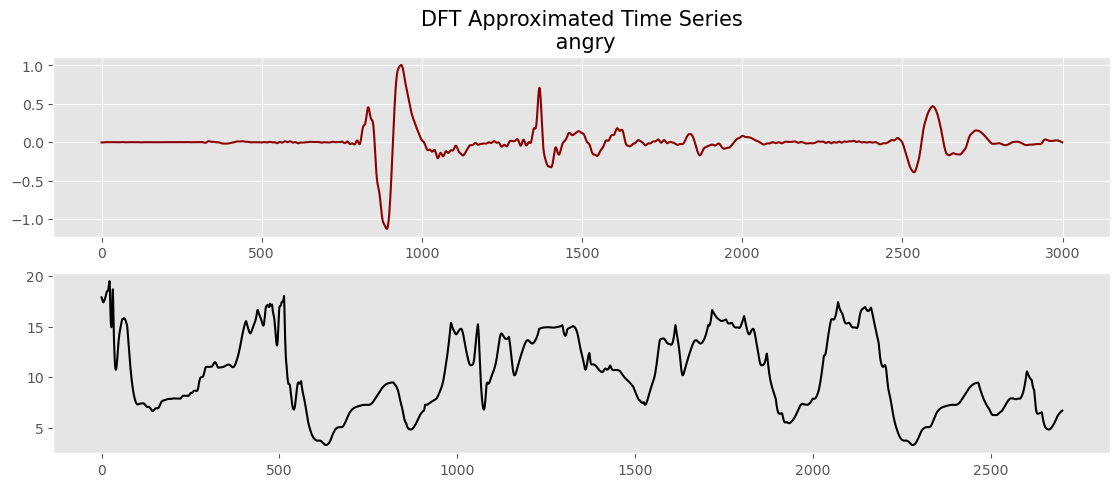

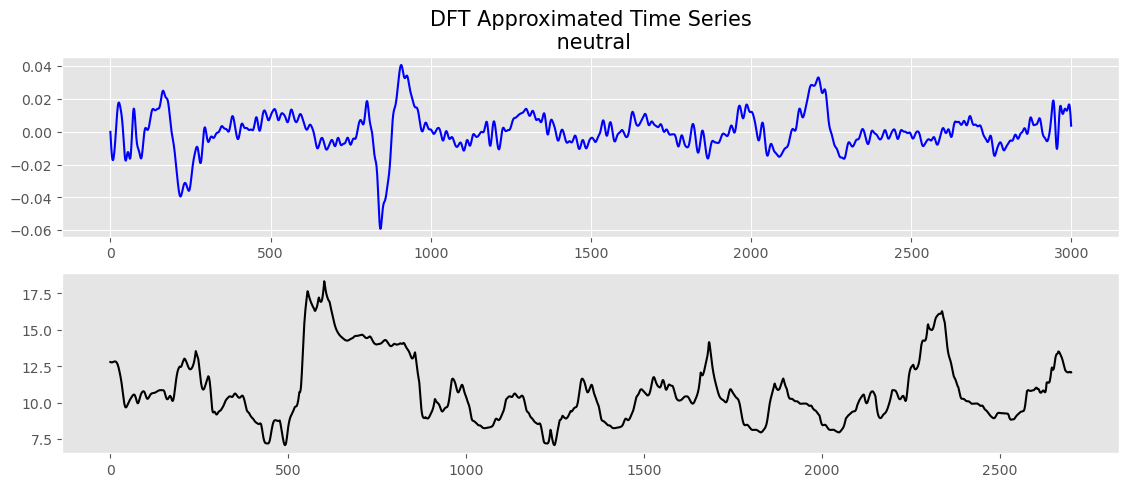

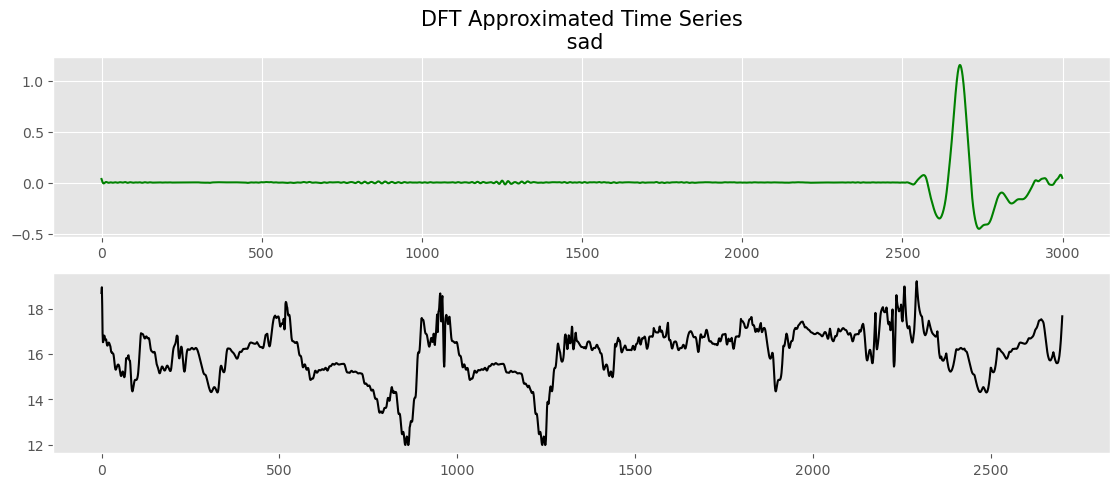

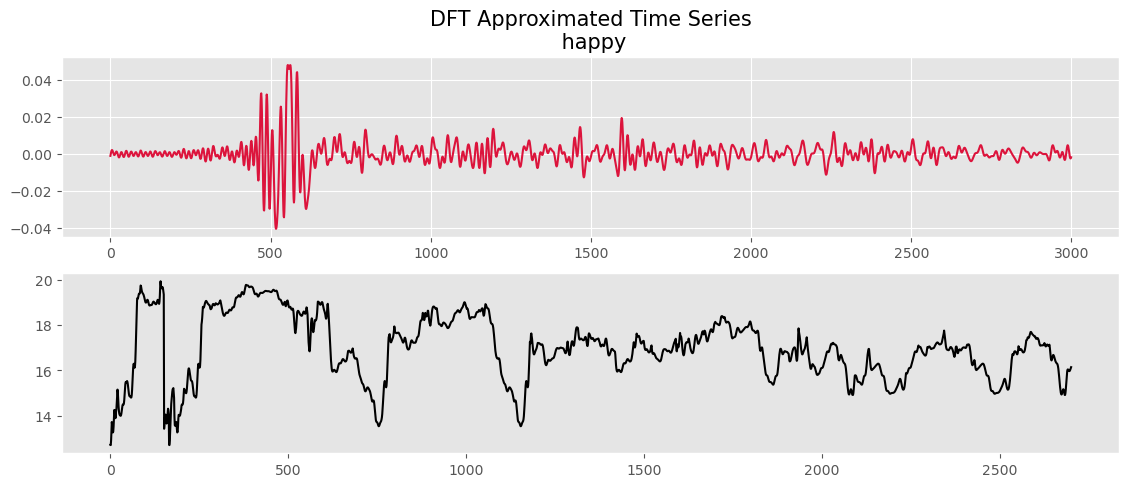

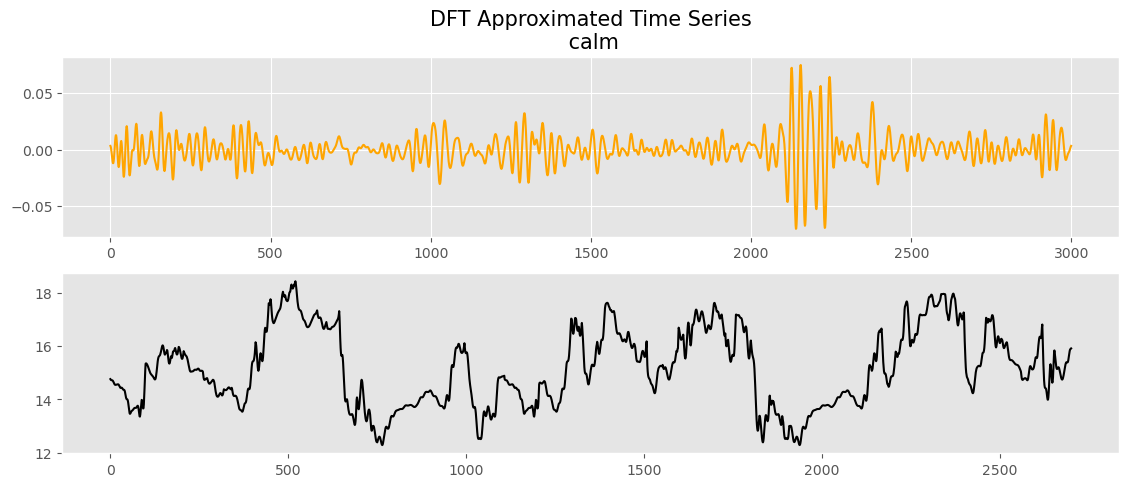

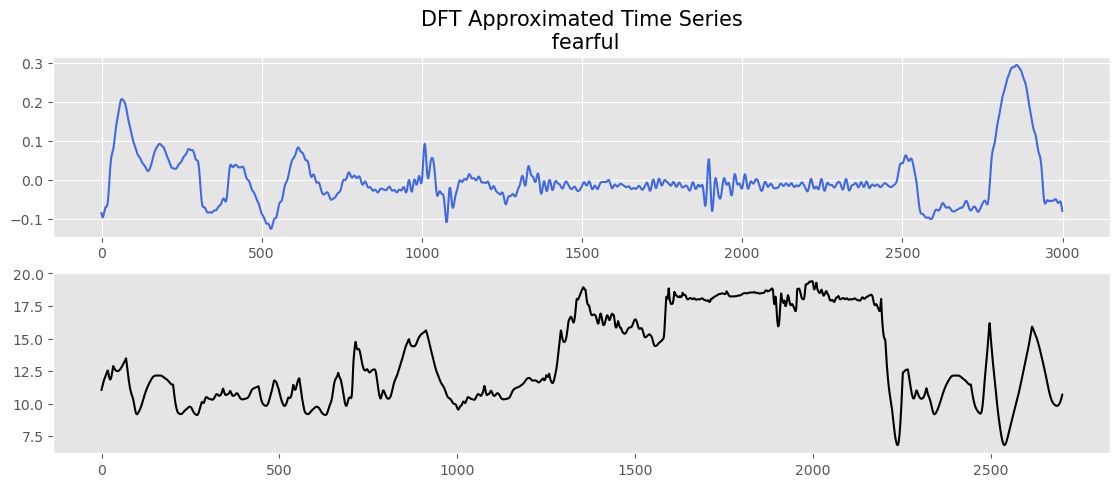

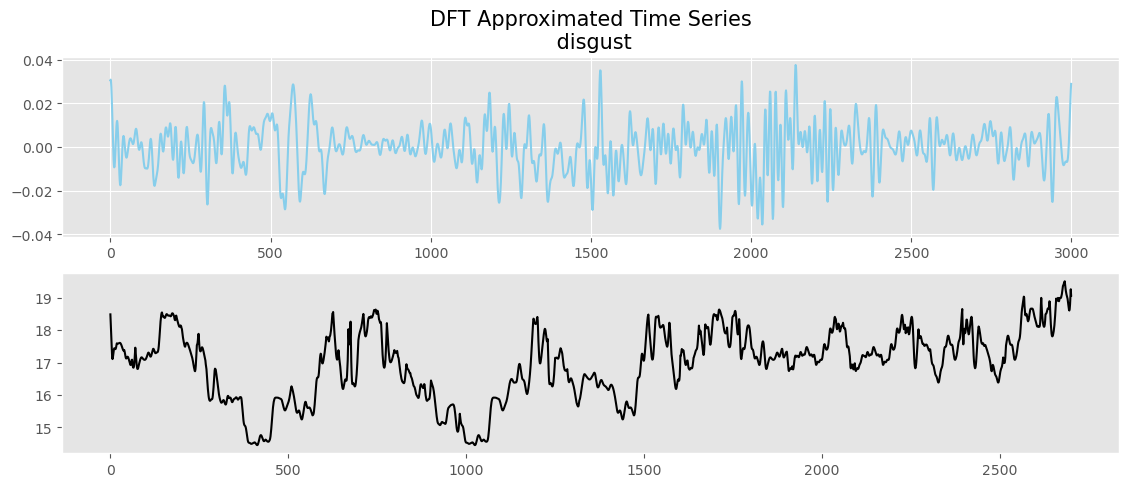

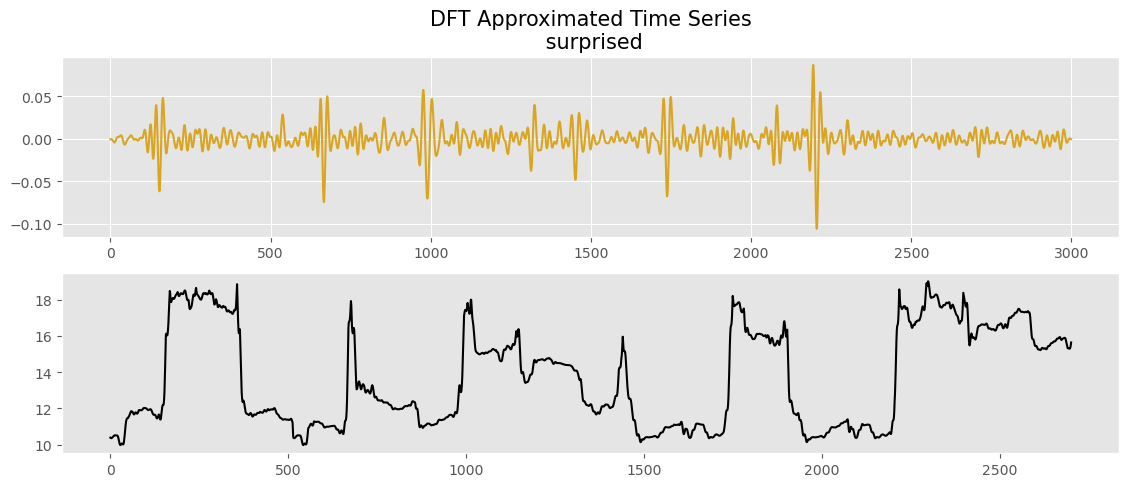

In [16]:
# matrix with one TS for each emotion
ts_dft = df_dft.iloc[idx_emo, 1:].values

col = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
n = 0
mp_dict_dft = {} #fare dict con i diversi mp per emozione
for i,t in enumerate(ts_dft):
    n += 1
    mp_dft, mpi_dft = matrixProfile.stomp(t, w)
    mp_dict_dft[i] = (mp_dft, mpi_dft)
    plt.figure(figsize=(30,22))
    plt.subplot(8, 2, n)
    plt.plot(t, c = col[i])
    plt.title(f"DFT Approximated Time Series\n {labels[idx_and_emo[i][1]]}", fontsize=15)

    plt.subplot(8, 2, n+2)
    plt.plot(mp_dft, c = 'k')
    plt.grid()
plt.show()

In [17]:
# DFT: first -> emotion, second -> (mp, mpi) for such emotion
mp_dict_dft

{0: (array([17.89082422, 17.80278881, 17.70719124, ...,  6.63864627,
          6.66615299,  6.68781836]),
  array([2099., 2100., 2101., ...,  904.,  905.,  906.])),
 1: (array([12.79393122, 12.78518191, 12.77663674, ..., 12.08588383,
         12.07429192, 12.08687652]),
  array([2529., 2530., 2532., ..., 1386., 1387., 1388.])),
 2: (array([18.70449095, 18.95677825, 18.14632105, ..., 17.10377168,
         17.380808  , 17.67440678]),
  array([1252., 1600., 1374., ..., 2169., 2170., 2170.])),
 3: (array([12.70215684, 12.6918485 , 12.8982752 , ..., 16.05036703,
         16.0986549 , 16.14366779]),
  array([ 165.,  166.,  167., ..., 2103., 2104., 2105.])),
 4: (array([14.76058351, 14.73752459, 14.72425152, ..., 15.88810256,
         15.89718079, 15.91213153]),
  array([1108., 1109., 1110., ..., 1593., 1594., 1595.])),
 5: (array([11.05734685, 11.16792449, 11.28400049, ..., 10.45371654,
         10.56273908, 10.68263614]),
  array([544., 545., 546., ..., 470., 471., 472.])),
 6: (array([18.4

### PAA

In [18]:
Xdf_paa, ydf_paa, df_paa = imp_data('data_motdisc\data_400_paa.csv', fraction = 1)
print(Xdf_paa.shape, ydf_paa.shape, df_paa.shape)
df_paa.head()

Mapping of Label Encoded Classes: 
{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}
(1828, 3000) (1828,) (1828, 3001)


emotion         0         1         2         3         4         5  \
0        0 -0.006707 -0.006707 -0.006707 -0.006707 -0.006707 -0.006707   
1        5 -0.013285 -0.013285 -0.013285 -0.013285 -0.013285 -0.013285   
2        6 -0.000353 -0.000353 -0.000353 -0.000353 -0.000353 -0.000353   
3        4  0.000781  0.000781  0.000781  0.000781  0.000781  0.000781   
4        4  0.005781  0.005781  0.005781  0.005781  0.005781  0.005781   

          6         7         8         9        10        11        12  \
0 -0.006707 -0.002135 -0.002135 -0.002135 -0.002135 -0.002135 -0.002135   
1 -0.013285 -0.013331 -0.013331 -0.013331 -0.013331 -0.013331 -0.013331   
2 -0.000353  0.002380  0.002380  0.002380  0.002380  0.002380  0.002380   
3  0.000781  0.000625  0.000625  0.000625  0.000625  0.000625  0.000625   
4  0.005781  0.009085  0.009085  0.009085  0.009085  0.009085  0.009085   

         13        14        15        16        17        18        19  \
0 -0.002135  0.000157  0.000157  0.000157  0.000157  0.000157  0.000157   
1 -0.013331 -0.000778 -0.000778 -0.000778 -0.000778 -0.000778 -0.000778   
2  0.002380  0.003067  0.003067  0.003067  0.003067  0.003067  0.003067   
3  0.000625  0.000416  0.000416  0.000416  0.000416  0.000416  0.000416   
4  0.009085  0.015611  0.015611  0.015611  0.015611  0.015611  0.015611   

         20        21        22        23        24        25        26  \
0  0.000157 -0.001405 -0.001405 -0.001405 -0.001405 -0.001405 -0.001405   
1 -0.000778  0.014979  0.014979  0.014979  0.014979  0.014979  0.014979   
2  0.003067  0.002458  0.002458  0.002458  0.002458  0.002458  0.002458   
3  0.000416 -0.000216 -0.000216 -0.000216 -0.000216 -0.000216 -0.000216   
4  0.015611  0.015328  0.015328  0.015328  0.015328  0.015328  0.015328   

         27        28        29        30        31        32        33  \
0 -0.001405  0.000624  0.000624  0.000624  0.000624  0.000624  0.000624   
1  0.014979  0.013824  0.013824  0.013824  0.013824  0.013824  0.013824   
2  0.002458  0.002112  0.002112  0.002112  0.002112  0.002112  0.002112   
3 -0.000216 -0.000948 -0.000948 -0.000948 -0.000948 -0.000948 -0.000948   
4  0.015328  0.015688  0.015688  0.015688  0.015688  0.015688  0.015688   

         34        35        36        37        38        39        40  \
0  0.000624 -0.001906 -0.001906 -0.001906 -0.001906 -0.001906 -0.001906   
1  0.013824  0.003935  0.003935  0.003935  0.003935  0.003935  0.003935   
2  0.002112  0.002641  0.002641  0.002641  0.002641  0.002641  0.002641   
3 -0.000948  0.000273  0.000273  0.000273  0.000273  0.000273  0.000273   
4  0.015688 -0.000126 -0.000126 -0.000126 -0.000126 -0.000126 -0.000126   

         41        42        43        44        45        46        47  \
0 -0.001906  0.000570  0.000570  0.000570  0.000570  0.000570  0.000570   
1  0.003935 -0.013209 -0.013209 -0.013209 -0.013209 -0.013209 -0.013209   
2  0.002641  0.001033  0.001033  0.001033  0.001033  0.001033  0.001033   
3  0.000273 -0.000200 -0.000200 -0.000200 -0.000200 -0.000200 -0.000200   
4 -0.000126  0.062290  0.062290  0.062290  0.062290  0.062290  0.062290   

         48        49        50        51        52        53        54  \
0  0.000570 -0.002223 -0.002223 -0.002223 -0.002223 -0.002223 -0.002223   
1 -0.013209 -0.015297 -0.015297 -0.015297 -0.015297 -0.015297 -0.015297   
2  0.001033  0.003233  0.003233  0.003233  0.003233  0.003233  0.003233   
3 -0.000200 -0.000224 -0.000224 -0.000224 -0.000224 -0.000224 -0.000224   
4  0.062290 -0.052482 -0.052482 -0.052482 -0.052482 -0.052482 -0.052482   

         55        56        57        58        59        60        61  \
0 -0.002223 -0.000186 -0.000186 -0.000186 -0.000186 -0.000186 -0.000186   
1 -0.015297 -0.013781 -0.013781 -0.013781 -0.013781 -0.013781 -0.013781   
2  0.003233  0.004133  0.004133  0.004133  0.004133  0.004133  0.004133   
3 -0.000224  0.000872  0.000872  0.000872  0.000872  0.000872  0.000872   
4 -0.052482  0.118677  0.1

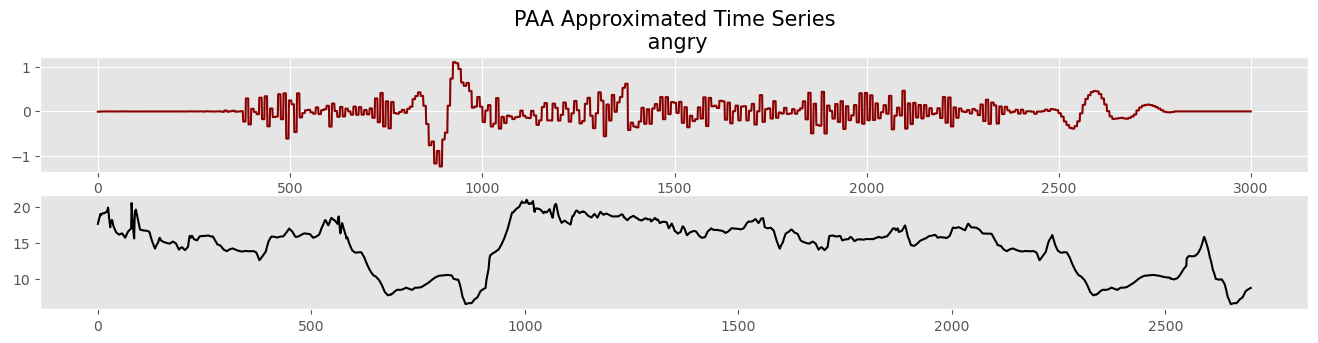

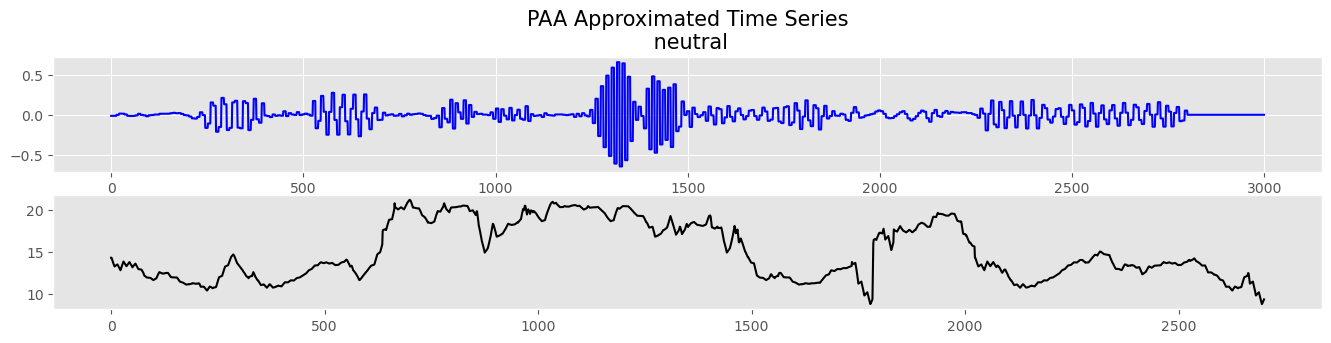

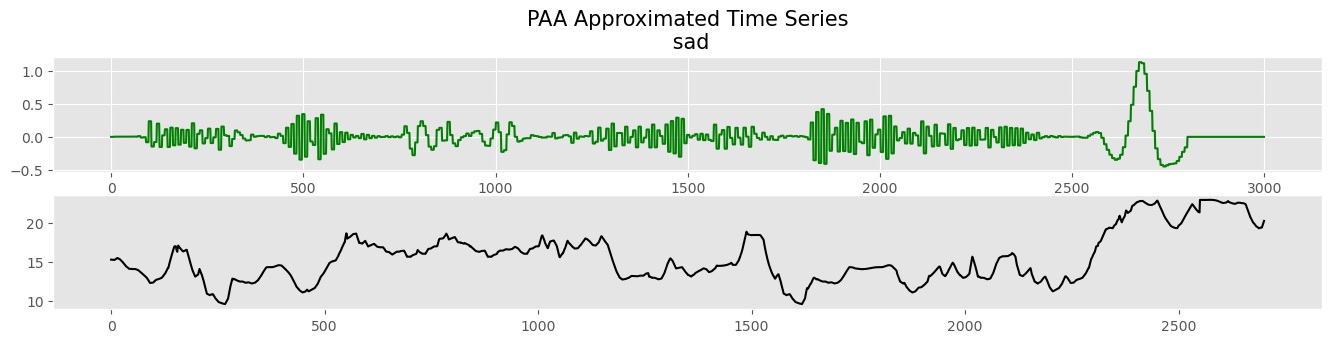

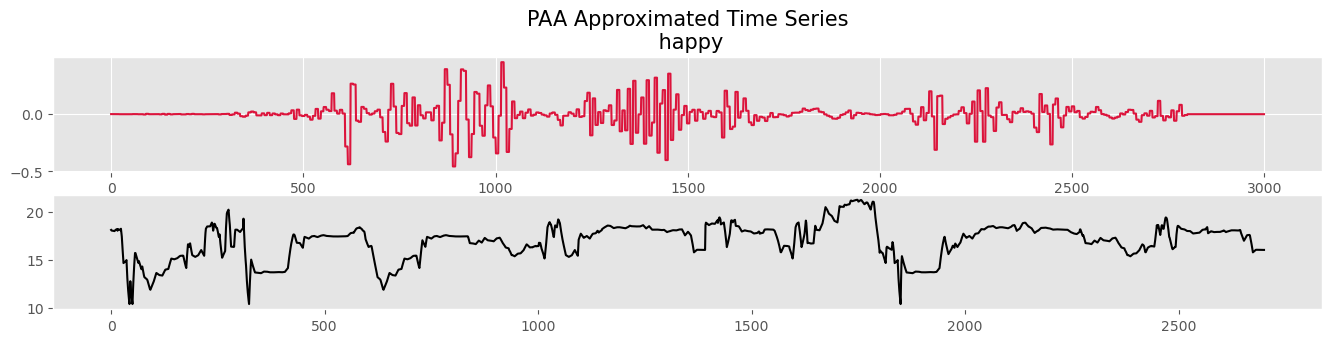

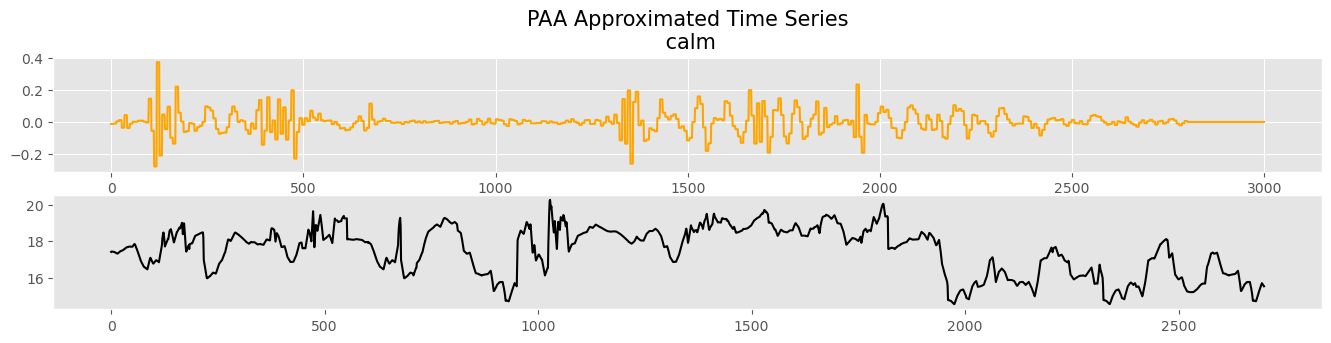

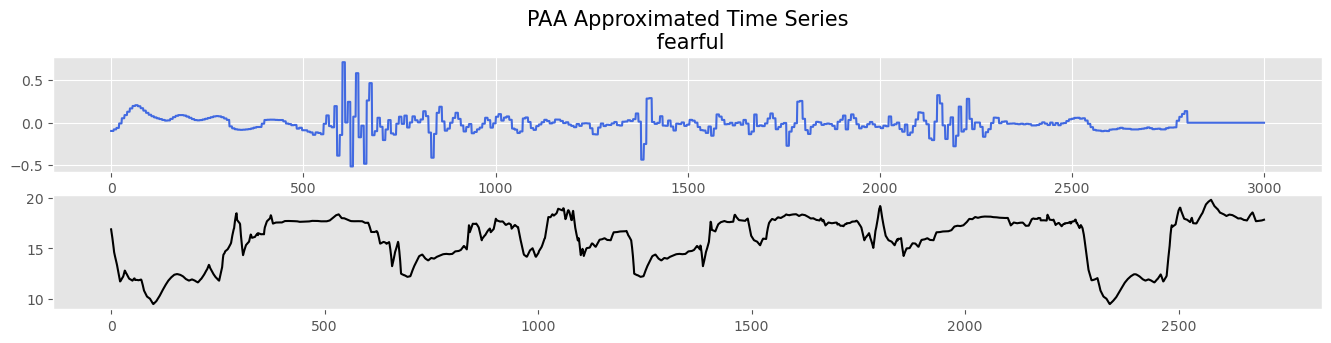

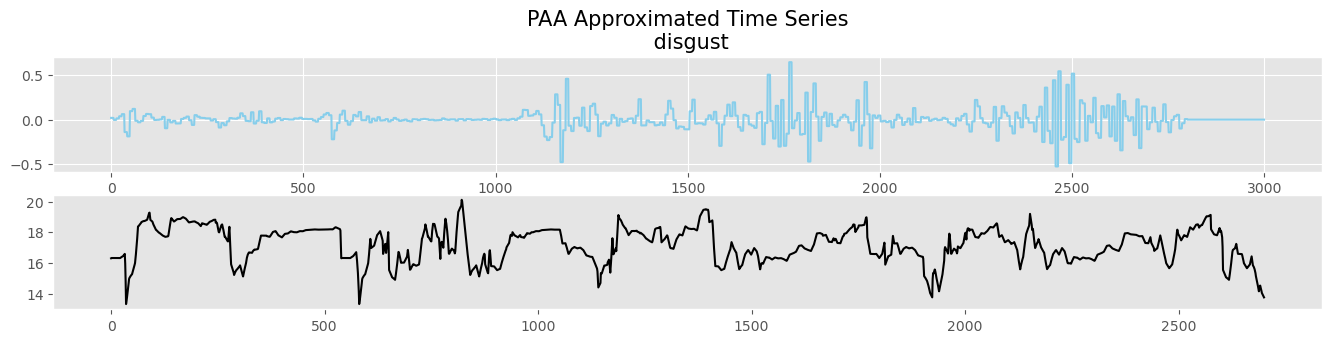

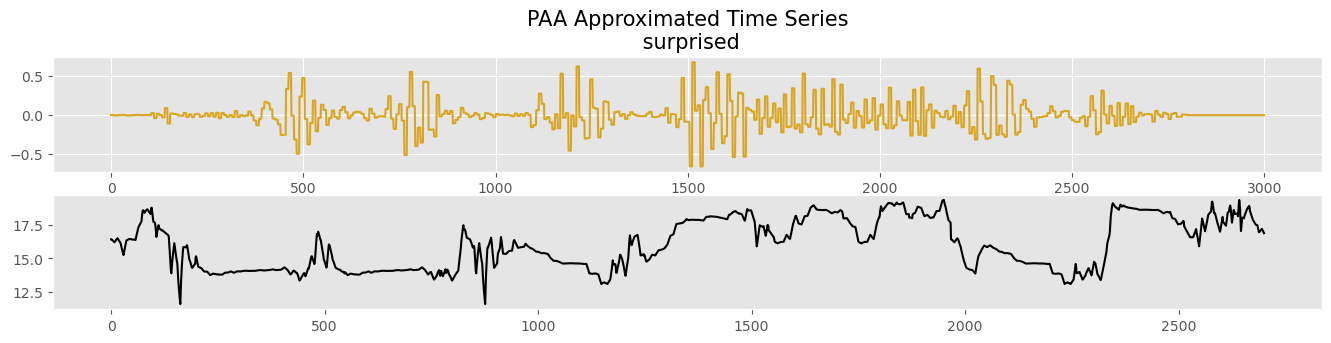

In [19]:
# matrix with one TS for each emotion
ts_paa = df_paa.iloc[idx_emo, 1:].values

col = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
n = 0
mp_dict_paa = {} #fare dict con i diversi mp per emozione
for i,t in enumerate(ts_paa):
    n += 1
    mp_paa, mpi_paa = matrixProfile.stomp(t, w)
    mp_dict_paa[i] = (mp_paa, mpi_paa)
    plt.figure(figsize=(36,14))
    plt.subplot(8, 2, n)
    plt.plot(t, c = col[i])
    plt.title(f"PAA Approximated Time Series\n {labels[idx_and_emo[i][1]]}", fontsize=15)

    plt.subplot(8, 2, n+2)
    plt.plot(mp_paa, c = 'k')
    plt.grid()
plt.show()

In [20]:
# PAA: first -> emotion, second -> (mp, mpi) for such emotion
mp_dict_paa

{0: (array([17.66548973, 17.90469316, 18.11294327, ...,  8.73189315,
          8.76266566,  8.79384424]),
  array([2065., 2066., 2067., ...,  906.,  907.,  908.])),
 1: (array([14.27466398, 14.26067666, 14.09763072, ...,  9.05951632,
          9.17839084,  9.29947175]),
  array([2023., 2024., 2025., ..., 1781., 1782., 1783.])),
 2: (array([15.29102701, 15.28648122, 15.28187065, ..., 19.88488016,
         20.05734726, 20.23333391]),
  array([2156., 2157., 2158., ..., 1036., 1036., 1036.])),
 3: (array([18.13139845, 18.06805991, 18.05839673, ..., 16.05333381,
         16.05339648, 16.05328041]),
  array([1302., 1303., 1304., ..., 1389., 1390., 1391.])),
 4: (array([17.4159171 , 17.43724781, 17.43334868, ..., 15.59465992,
         15.55882808, 15.5228947 ]),
  array([833., 834., 835., ..., 948., 949., 950.])),
 5: (array([16.88114947, 16.60930086, 16.32179444, ..., 17.79985891,
         17.8135282 , 17.82701688]),
  array([2450., 2450., 2450., ..., 1697., 1698., 1699.])),
 6: (array([16.3

## Motifs Discovery

In [21]:
# number of motifs to find
max_motifs = 3
n_neighbors = 2

### SAX

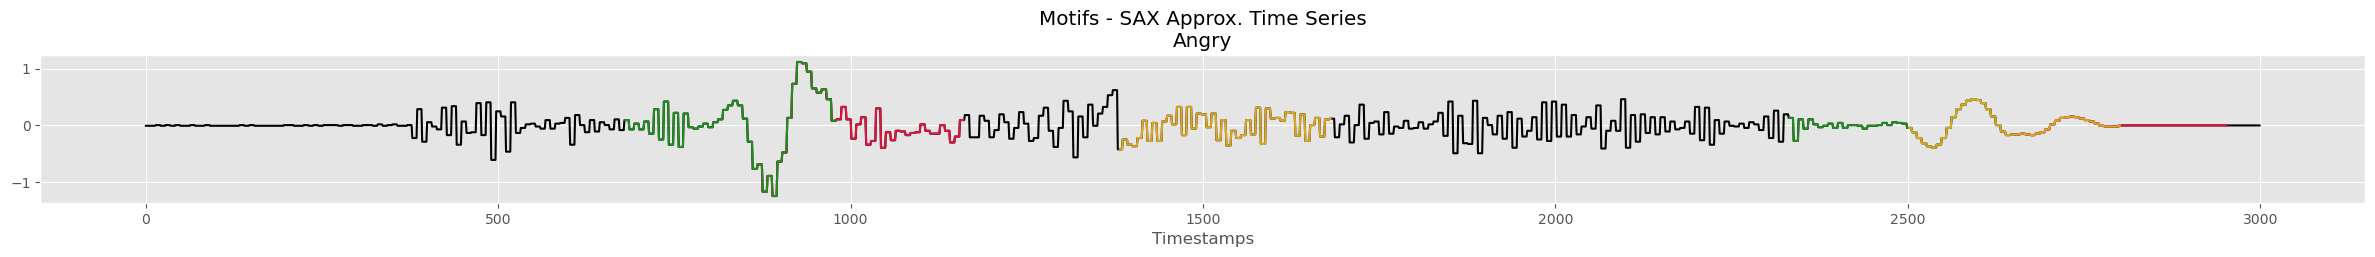

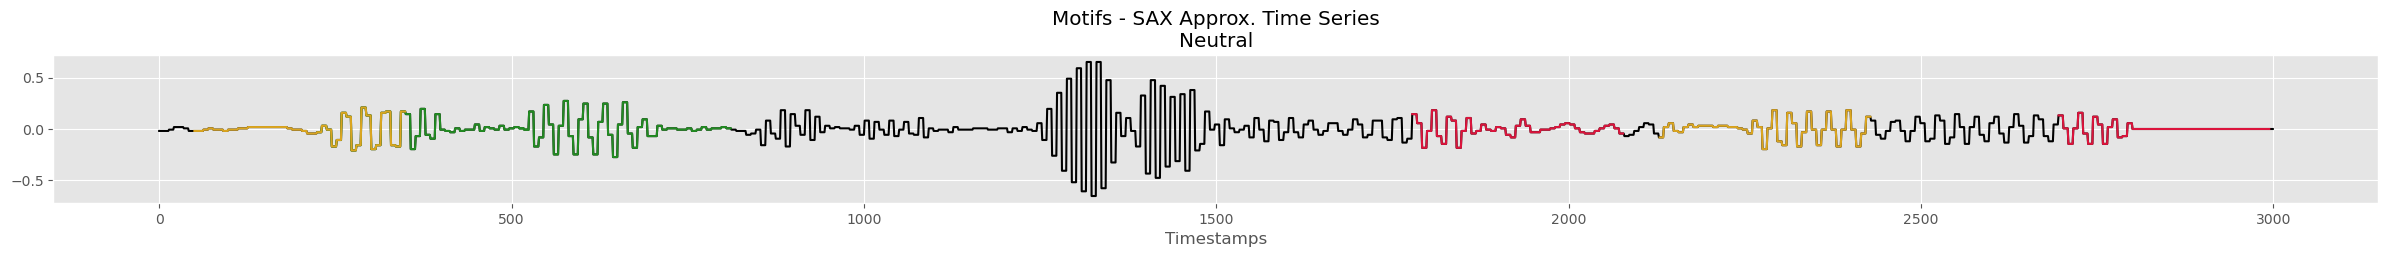

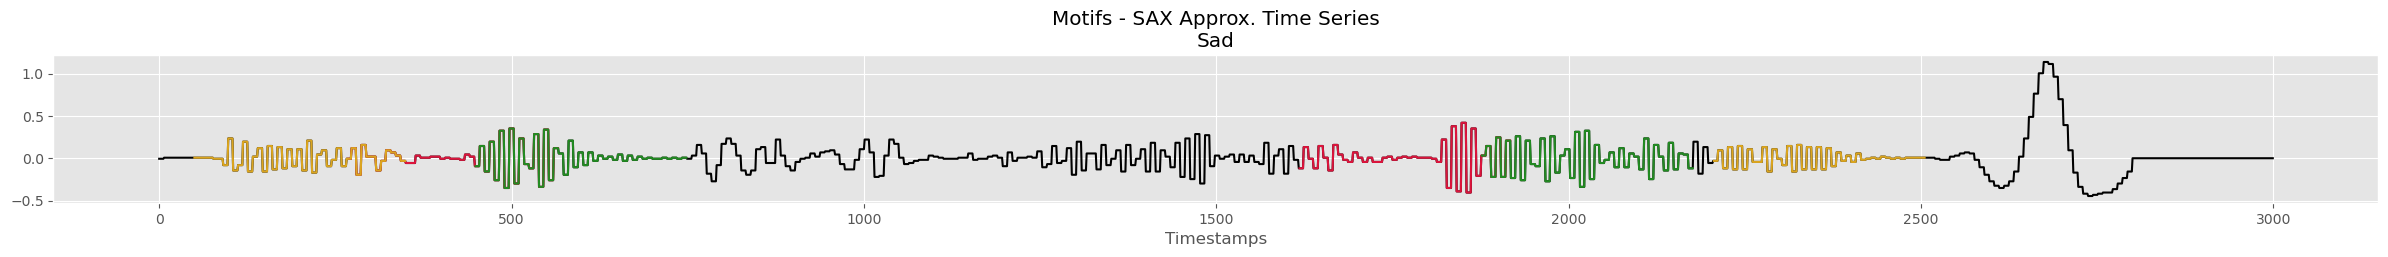

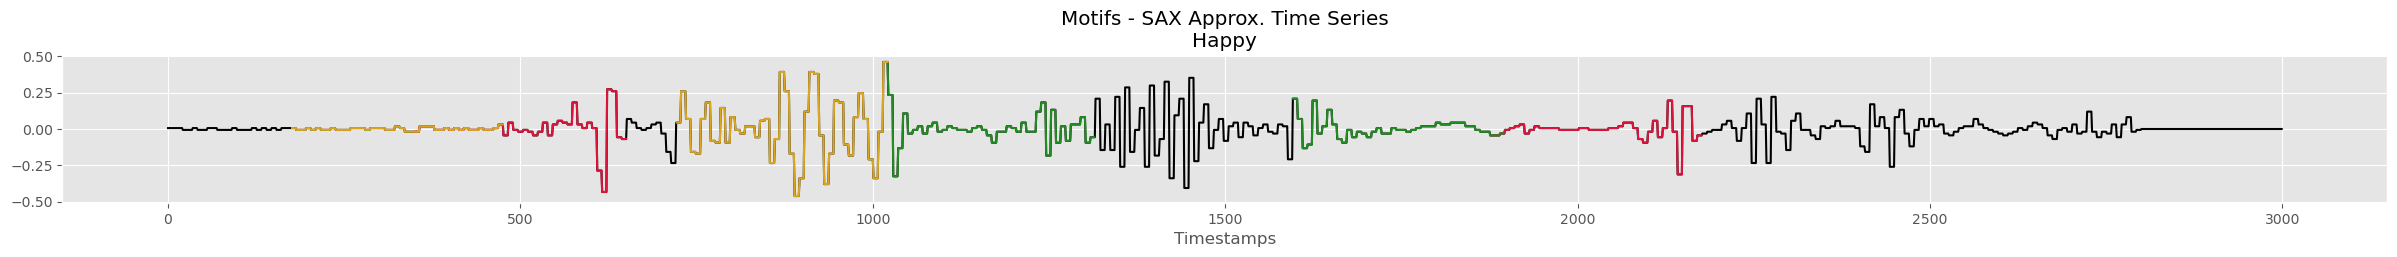

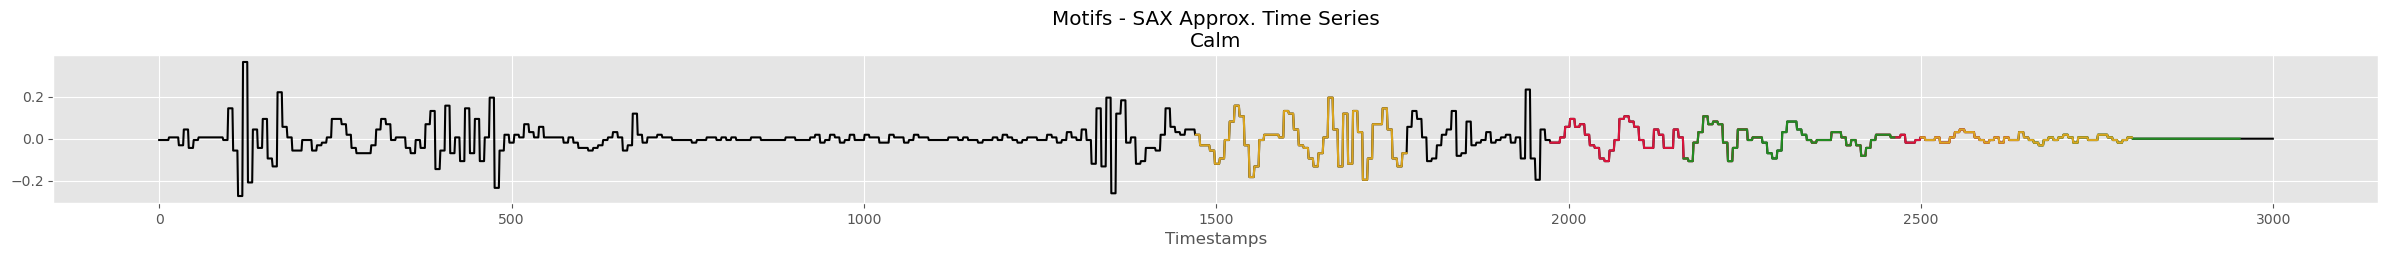

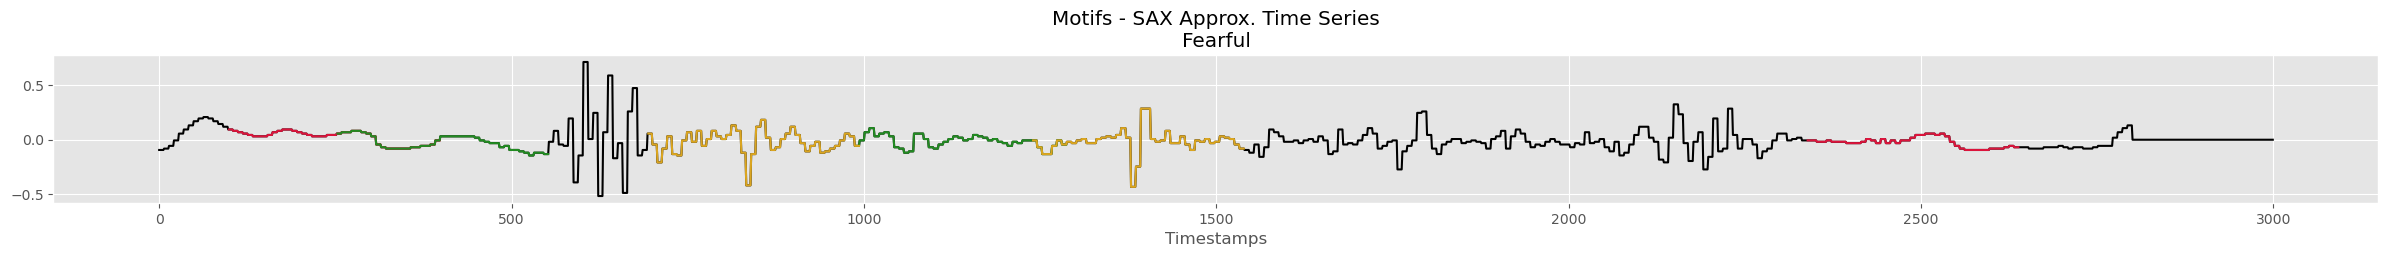

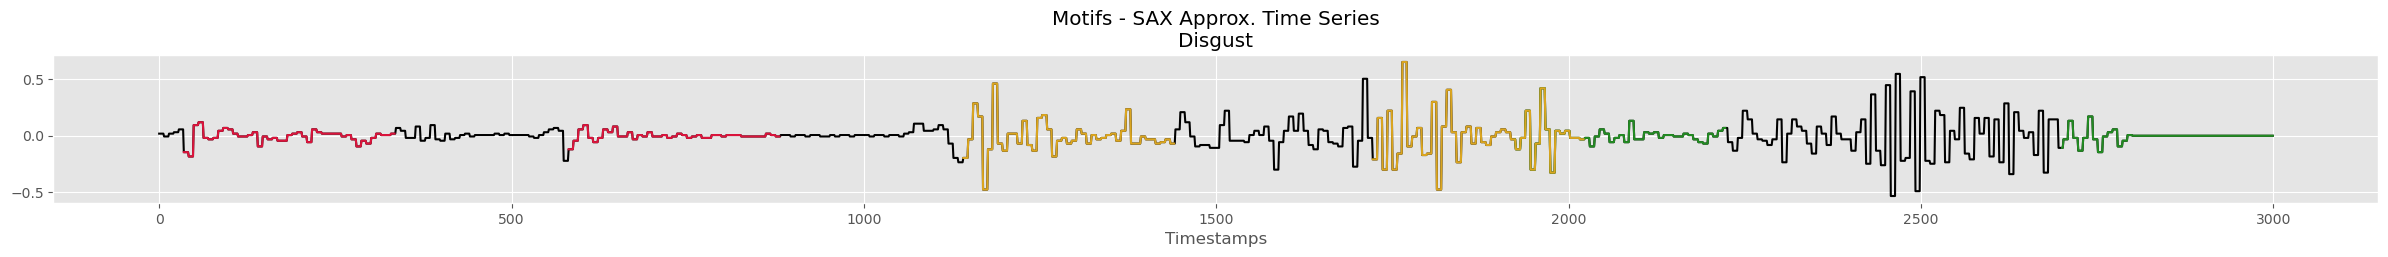

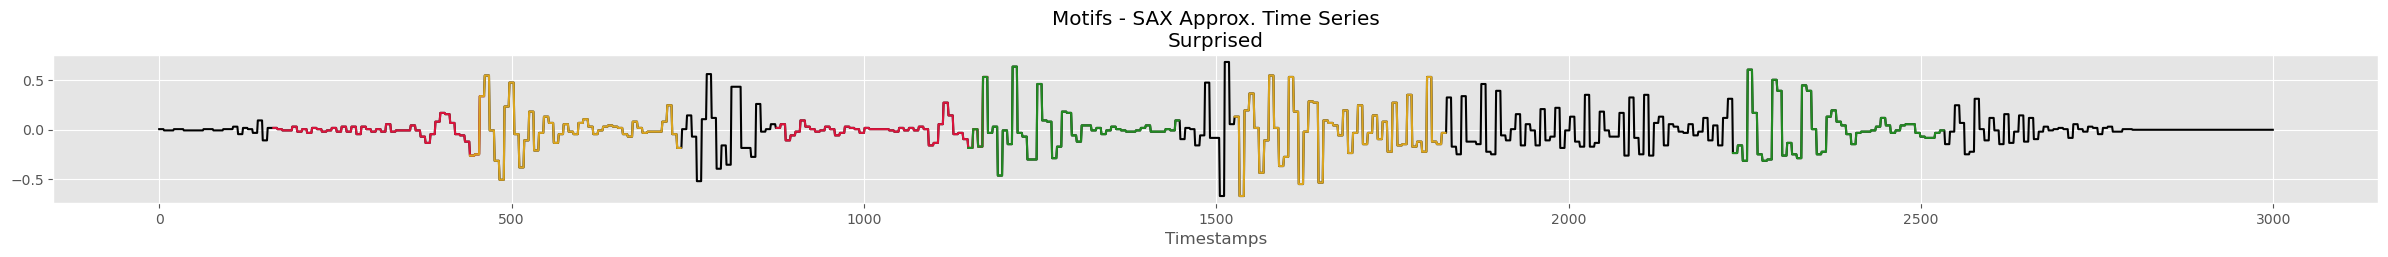

In [22]:
ts_sax = df_sax.iloc[idx_emo, 1:].values
ts = ts_sax.copy()

col = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
n = 0
mo_mod_dict_sax = {} #dict with different mo, mod for each emotion
for x in range(8):
    n += 1
    ts_sax = ts[x]
    mp_sax, mpi_sax = mp_dict_sax[x][0], mp_dict_sax[x][1]
    
    plt.figure(figsize=(30, 18))
    plt.subplot(8,1,n)
    #plt.suptitle(f'{labels[idx_and_emo[i][1]]}')
    mo_sax, mod_sax  = motifs.motifs(ts_sax, (mp_sax, mpi_sax), max_motifs=max_motifs, n_neighbors = n_neighbors)
    mo_mod_dict_sax[x] = (mo_sax, mod_sax)
    
    plt.plot(ts_sax, c = 'k')
    colors = ['crimson', 'forestgreen', 'goldenrod', 'b', 'y'][:len(mo_sax)]
    for m, d, c in zip(mo_sax, mod_sax, colors):
        for i in m:
            m_shape = ts_sax[i:i+w]
            plt.plot(range(i,i+w), m_shape, color=c)
    plt.title('Motifs - SAX Approx. Time Series\n' + f'{labels[idx_and_emo[x][1]]}'.capitalize())
    plt.xlabel('Timestamps')

In [23]:
mo_mod_dict_sax

{0: ([[861, 2653], [680, 2332], [1382, 2502]],
  [6.598983733067526, 7.775887685827179, 10.240796760337739]),
 1: ([[1778, 2695], [225, 512], [50, 2129]],
  [8.720637368058865, 10.336651236374564, 10.766613612468513]),
 2: ([[267, 1618], [449, 1877], [50, 2206]],
  [9.683124905388242, 11.141393512553707, 11.18378578134396]),
 3: ([[351, 1877], [1015, 1596], [176, 722]],
  [13.728294339922533, 14.971000527282834, 15.057745956281986]),
 4: ([[1974, 2338], [2163, 2653], [1471, 2500]],
  [13.73295631522386, 15.365387479807003, 15.826013858765213]),
 5: ([[99, 2339], [253, 988], [694, 1240]],
  [9.684467740202019, 11.899004315974757, 12.197776131984112]),
 6: ([[35, 581], [1923, 2700], [1141, 1722]],
  [13.303060517430954, 13.528393988331873, 14.290108525203156]),
 7: ([[162, 876], [1148, 2233], [441, 1526]],
  [11.472859125640381, 13.028103917338594, 13.393455780045667])}

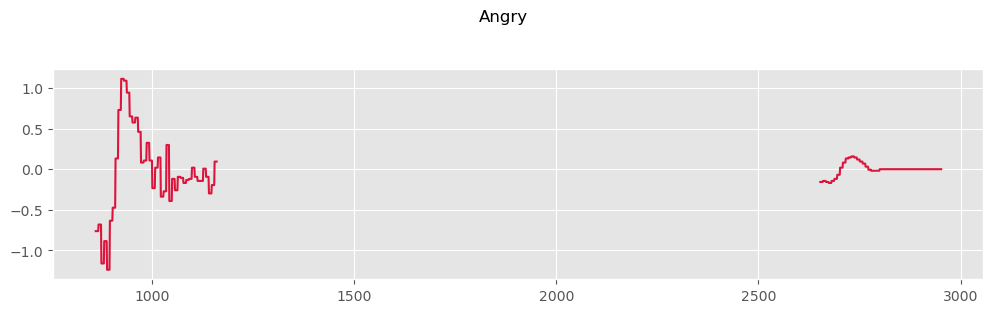

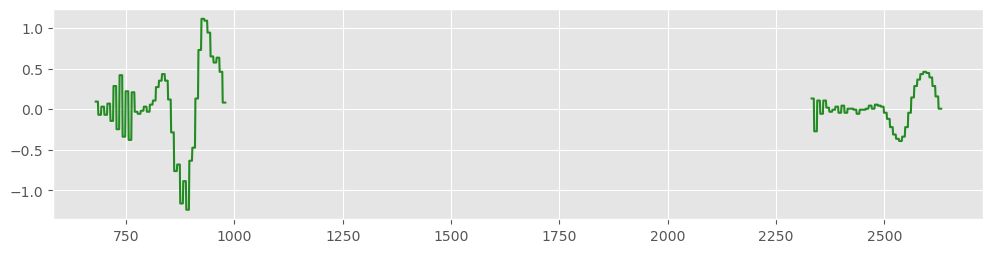

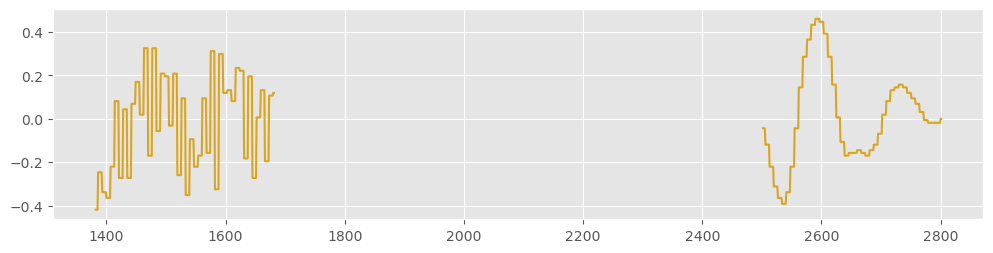

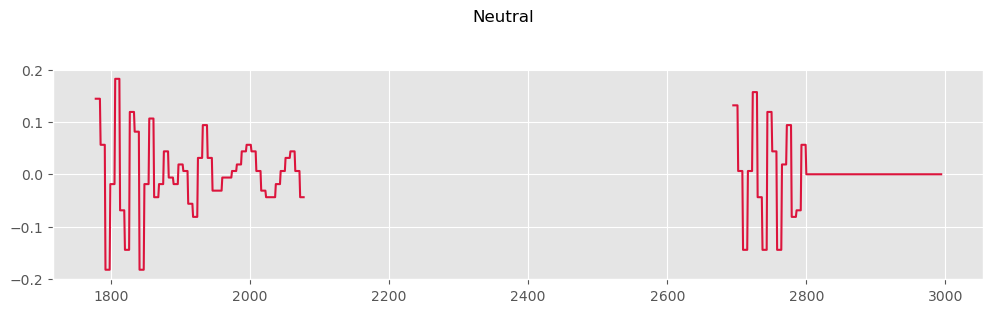

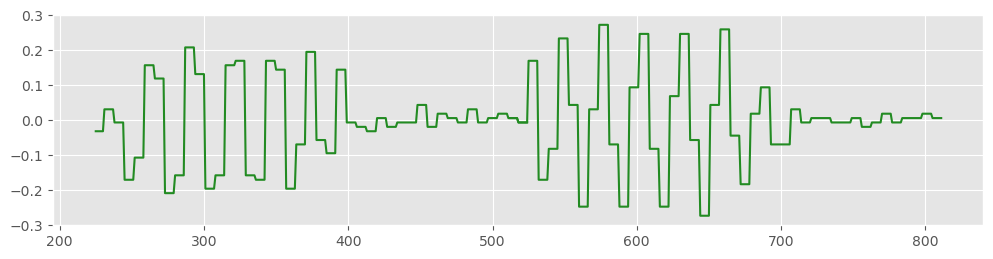

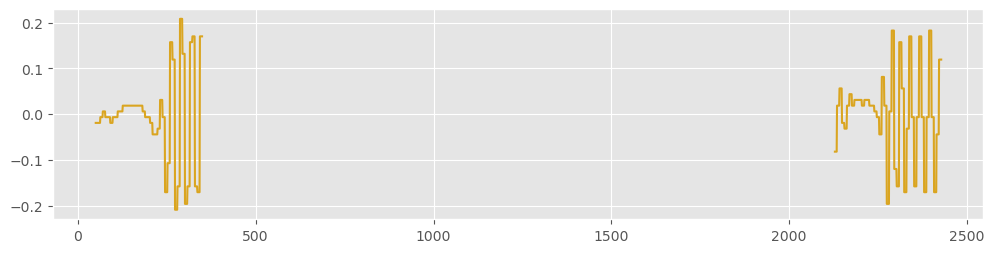

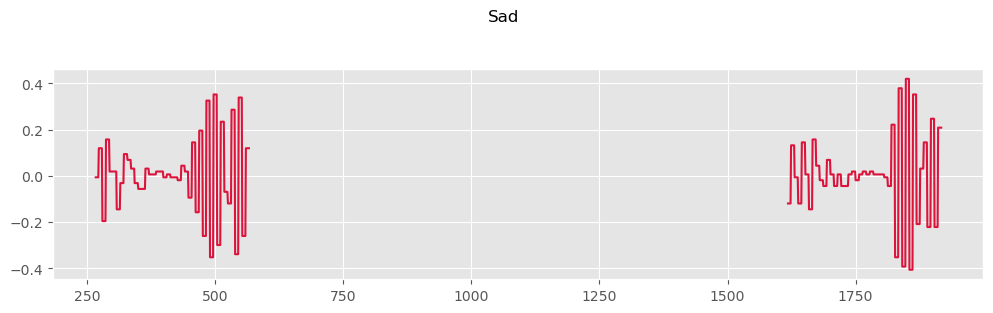

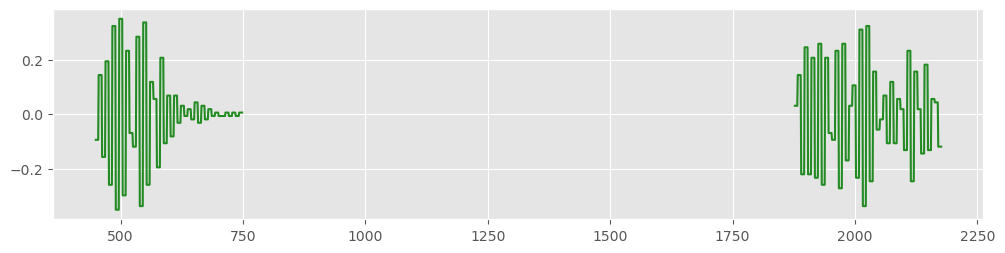

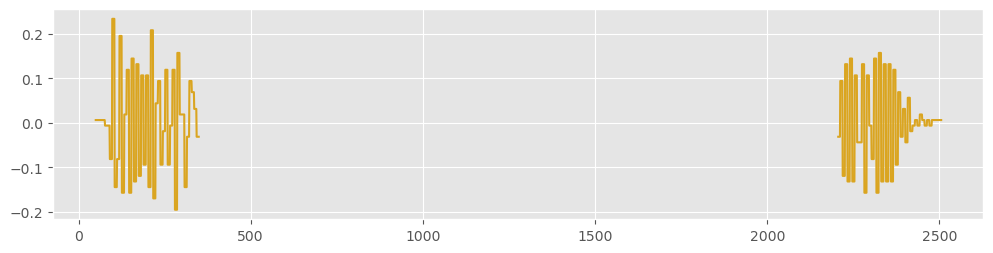

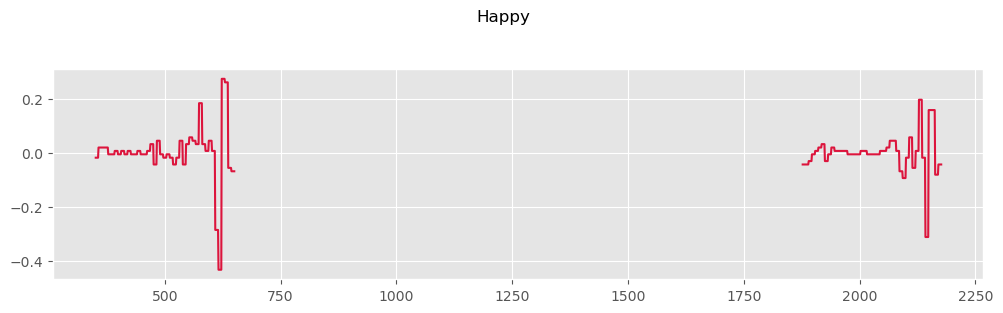

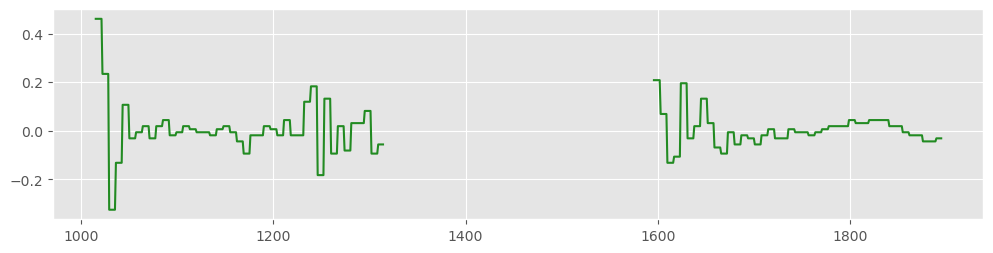

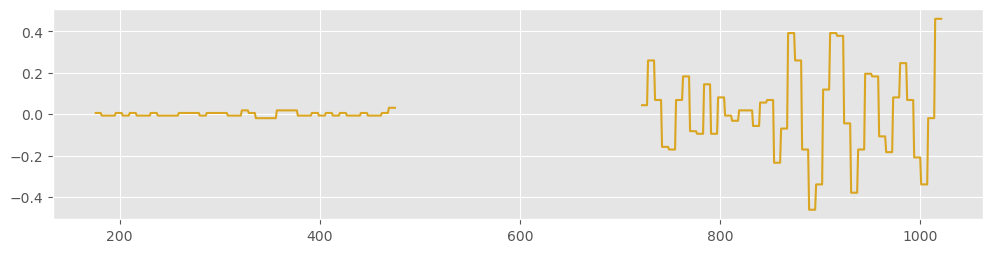

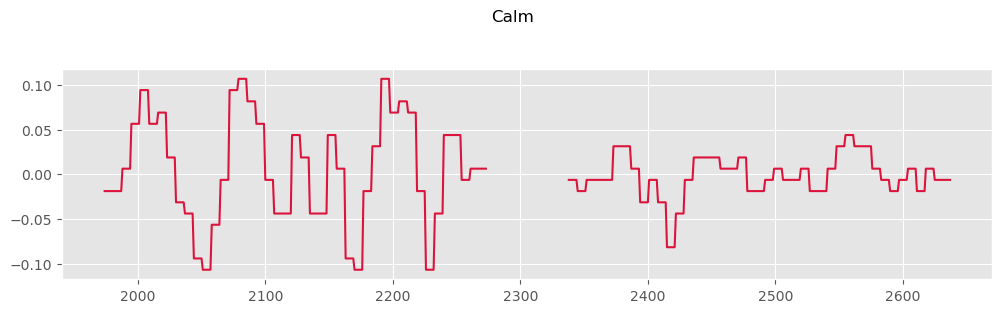

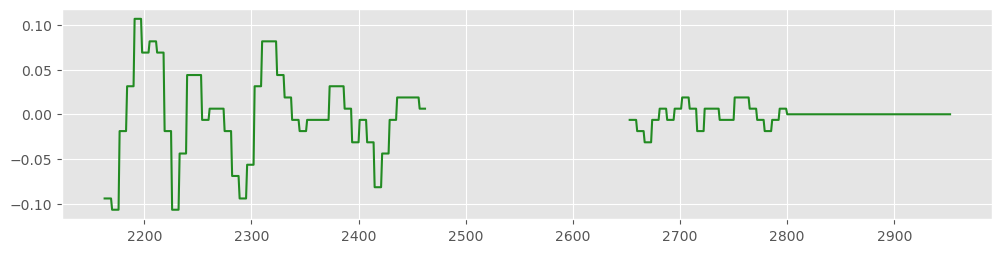

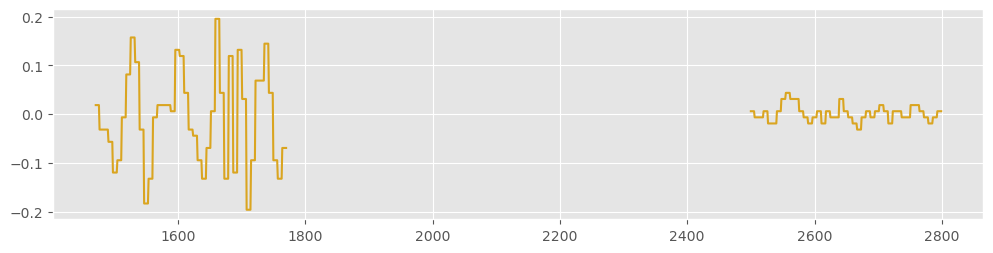

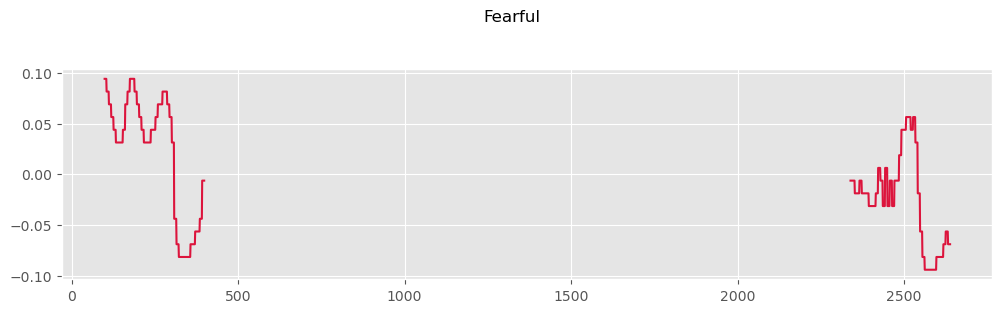

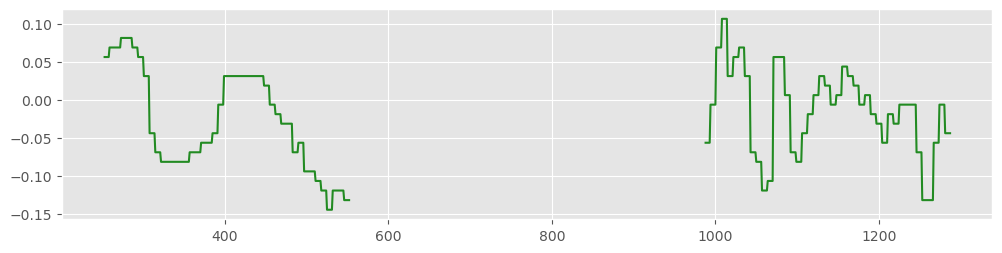

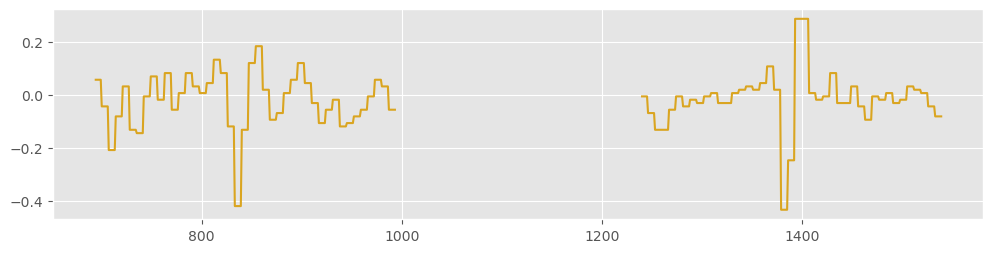

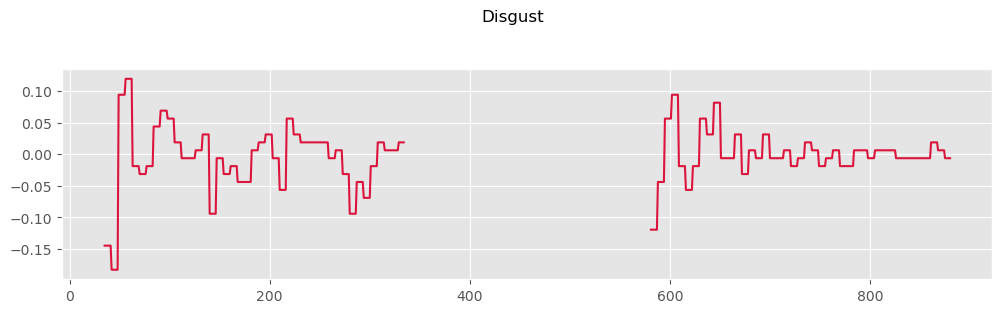

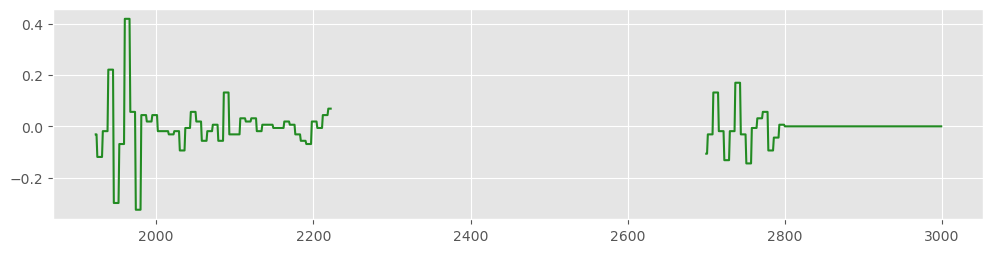

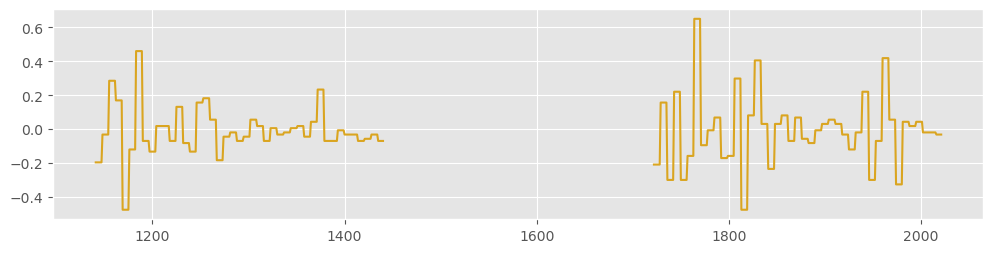

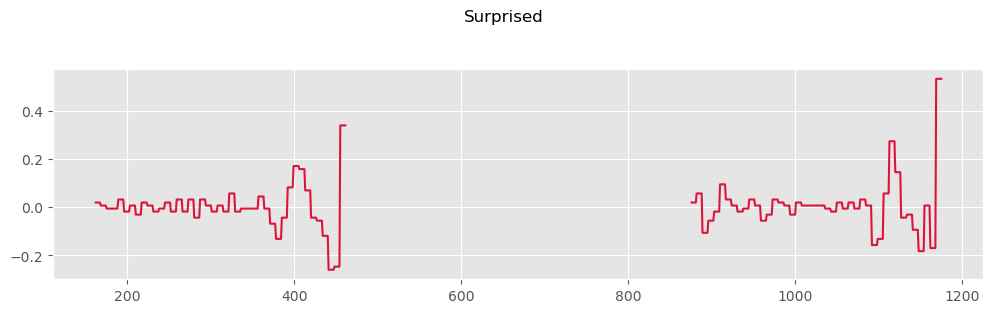

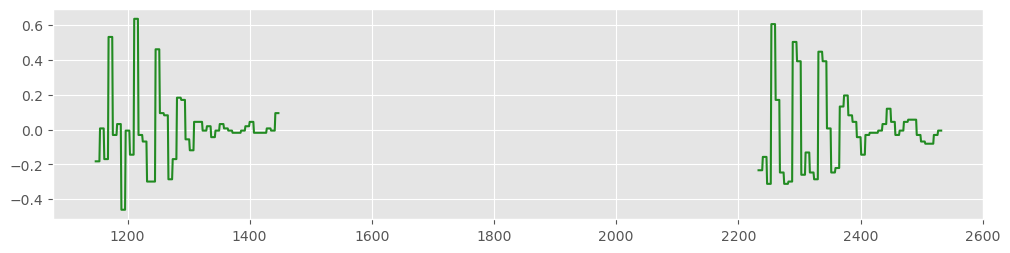

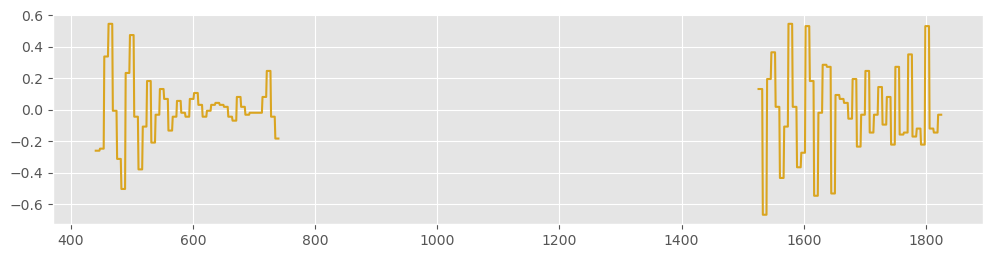

In [24]:
# motifs found
for y in range(8):
    plt.suptitle(f'{labels[idx_and_emo[y][1]]}'.capitalize())
    mo_sax, mod_sax = mo_mod_dict_sax[y][0], mo_mod_dict_sax[y][1]
    ts_sax = ts[y]
    for m, d, c in zip(mo_sax, mod_sax, colors):
        for i in m:
            plt.subplot(211)
            m_shape = ts_sax[i:i+w]
            plt.plot(range(i,i+w), m_shape, color=c)
        plt.show()

### DFT

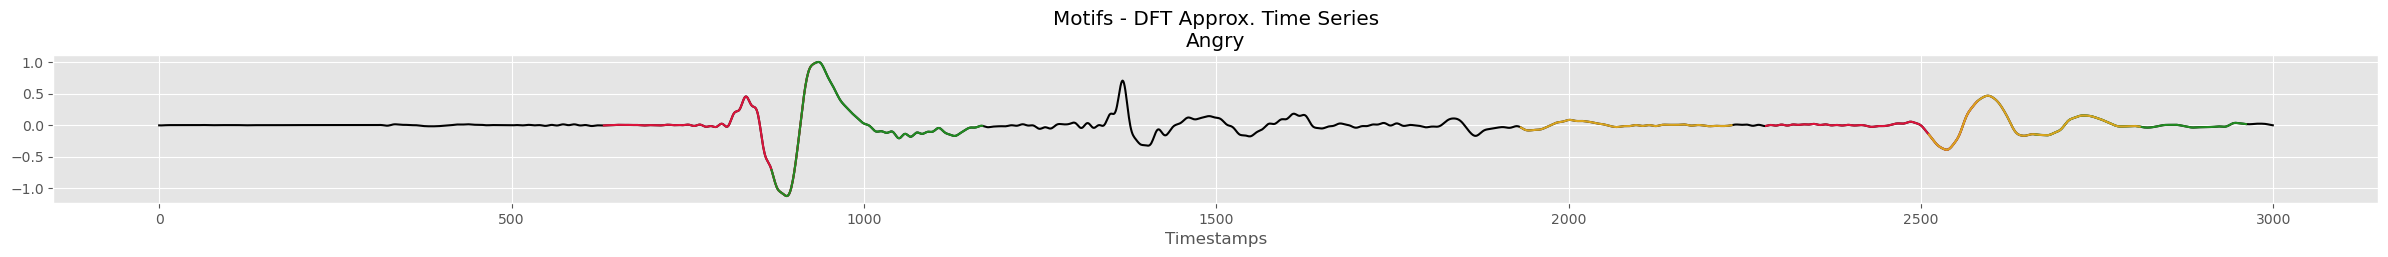

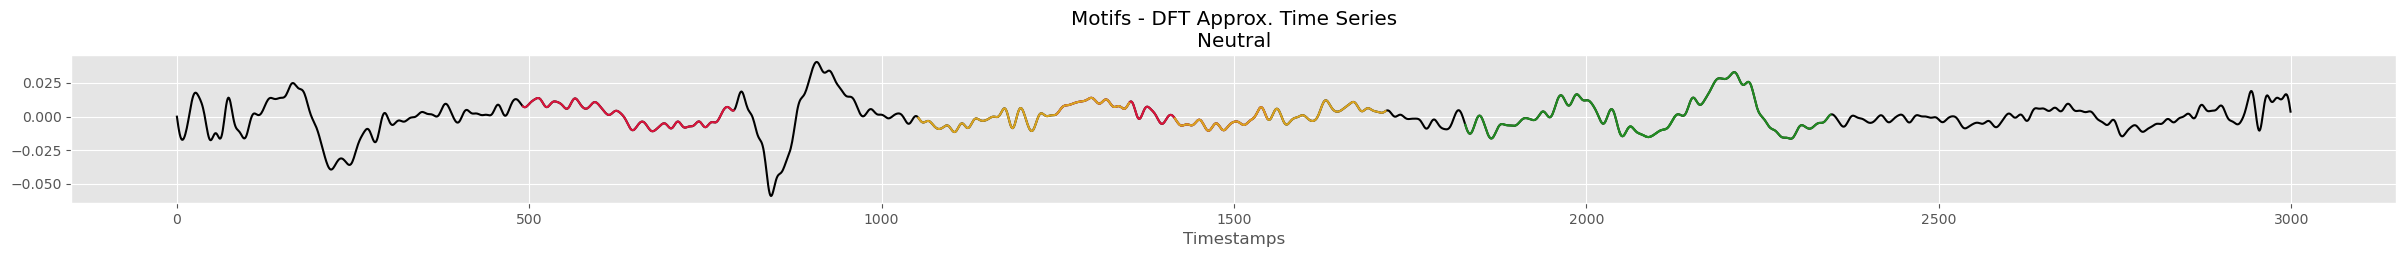

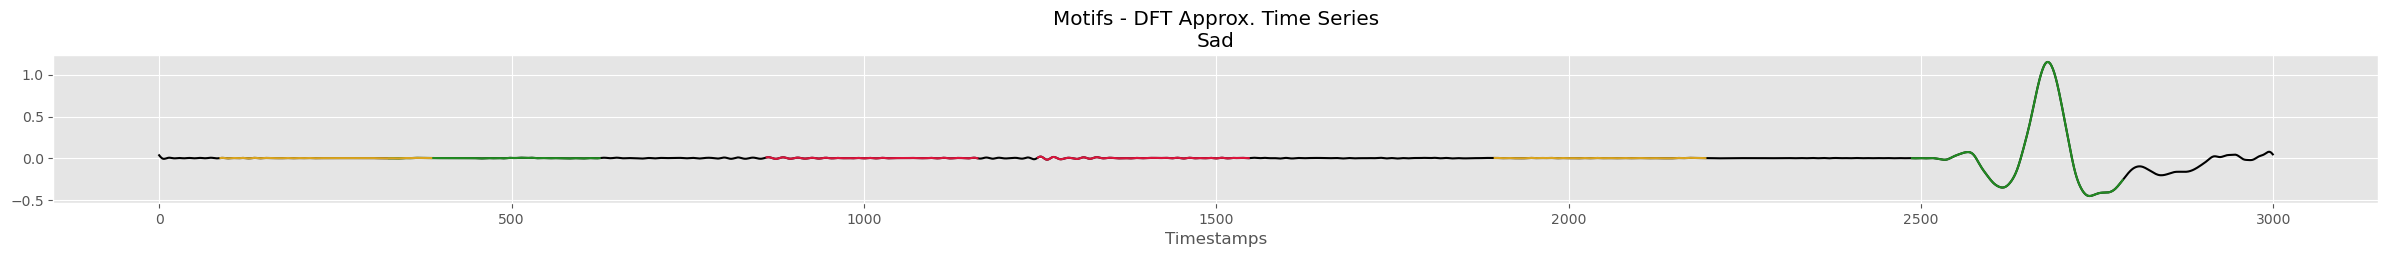

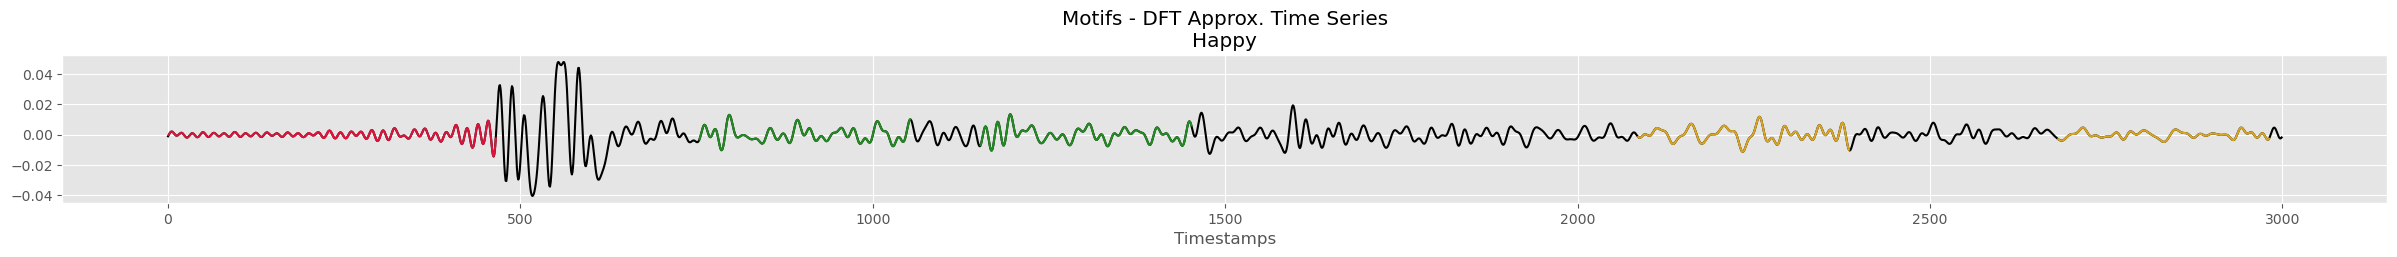

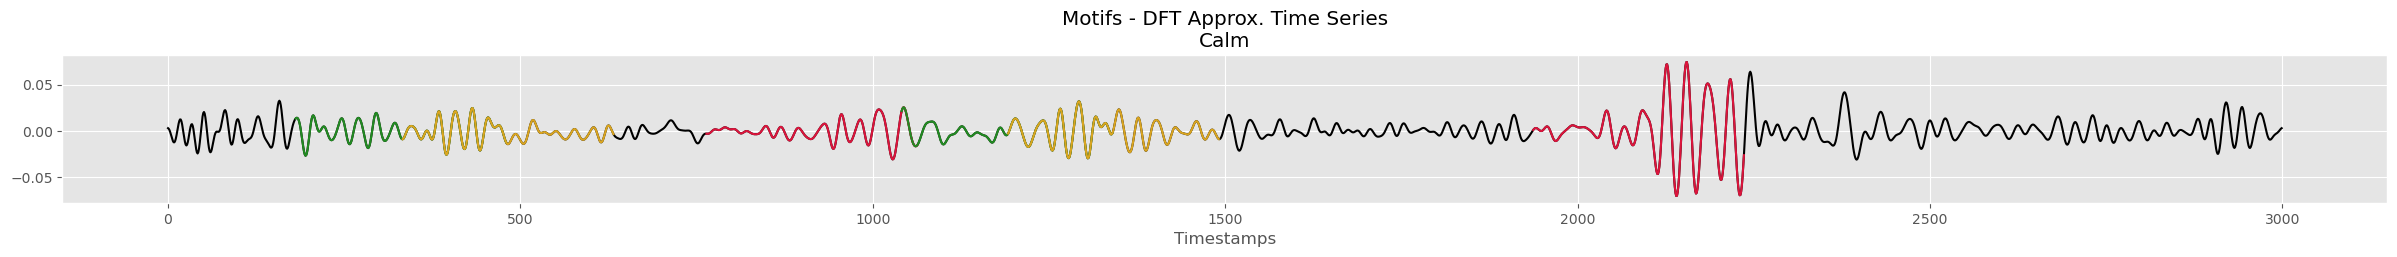

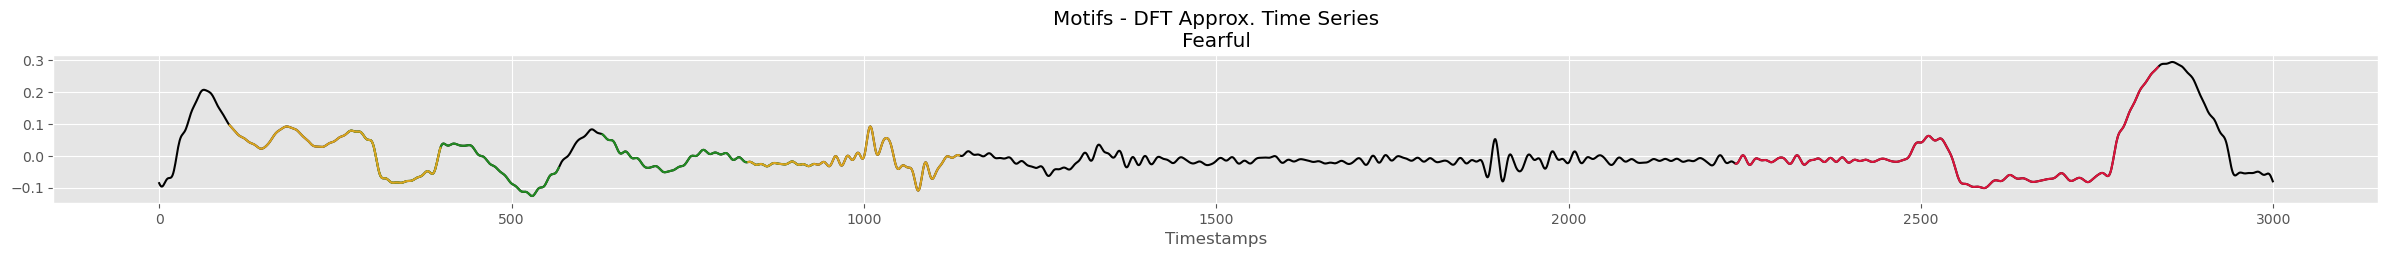

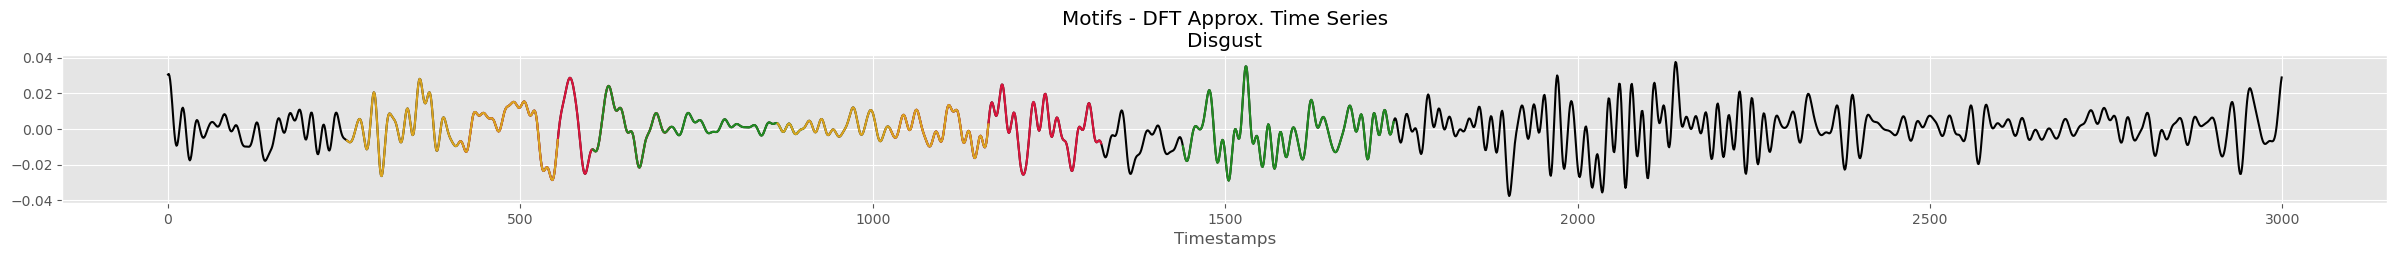

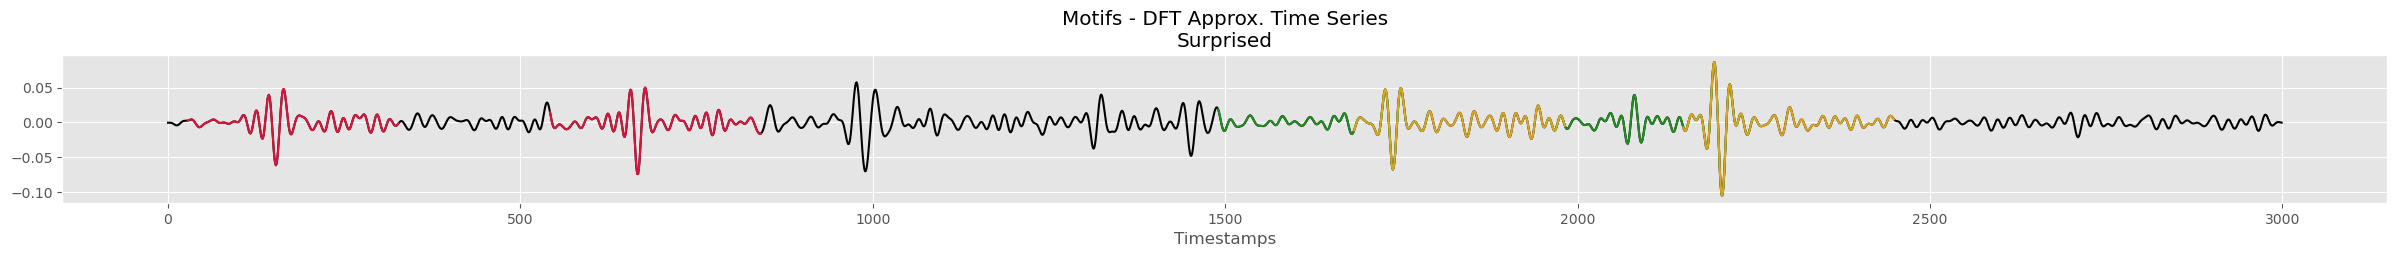

In [25]:
ts_dft = df_dft.iloc[idx_emo, 1:].values
ts = ts_dft.copy()

col = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
n = 0
mo_mod_dict_dft = {} #dict with different mo, mod for each emotion
for x in range(8):
    n += 1
    ts_dft = ts[x]
    mp_dft, mpi_dft = mp_dict_dft[x][0], mp_dict_dft[x][1]
    
    plt.figure(figsize=(30, 18))
    plt.subplot(8,1,n)
    #plt.suptitle(f'{labels[idx_and_emo[i][1]]}')
    mo_dft, mod_dft  = motifs.motifs(ts_dft, (mp_dft, mpi_dft), max_motifs=max_motifs, n_neighbors = n_neighbors)
    mo_mod_dict_dft[x] = (mo_dft, mod_dft)
    
    plt.plot(ts_dft, c = 'k')
    colors = ['crimson', 'forestgreen', 'goldenrod', 'b', 'y'][:len(mo_dft)]
    for m, d, c in zip(mo_dft, mod_dft, colors):
        for i in m:
            m_shape = ts_dft[i:i+w]
            plt.plot(range(i,i+w), m_shape, color=c)
    plt.title('Motifs - DFT Approx. Time Series\n' + f'{labels[idx_and_emo[x][1]]}'.capitalize())
    plt.xlabel('Timestamps')

In [26]:
mo_mod_dict_dft

{0: ([[631, 2280], [869, 2662], [1932, 2511]],
  [3.2828746179286985, 4.825141797544251, 5.449942679271803]),
 1: ([[491, 1248], [1828, 2047], [1052, 1416]],
  [7.099540934648329, 7.970292407745865, 8.257331043446571]),
 2: ([[862, 1247], [326, 2487], [87, 1895]],
  [11.984753526869953, 14.30860408786992, 14.357878999784024]),
 3: ([[1, 166], [754, 1153], [2086, 2682]],
  [12.691848497624363, 13.528238669969701, 14.912427314965905]),
 4: ([[764, 1937], [181, 1041], [333, 1192]],
  [12.284689208664558, 12.508375137165883, 13.428472300320665]),
 5: ([[2237, 2537], [268, 629], [100, 836]],
  [6.818636448530254, 9.125573661151998, 9.188025669032758]),
 6: ([[413, 1025], [603, 1440], [254, 865]],
  [14.45757824194903, 15.248124556906221, 15.913248962935755]),
 7: ([[28, 542], [1490, 1957], [1683, 2150]],
  [9.968754903364266, 10.131954320562716, 10.348988720418612])}

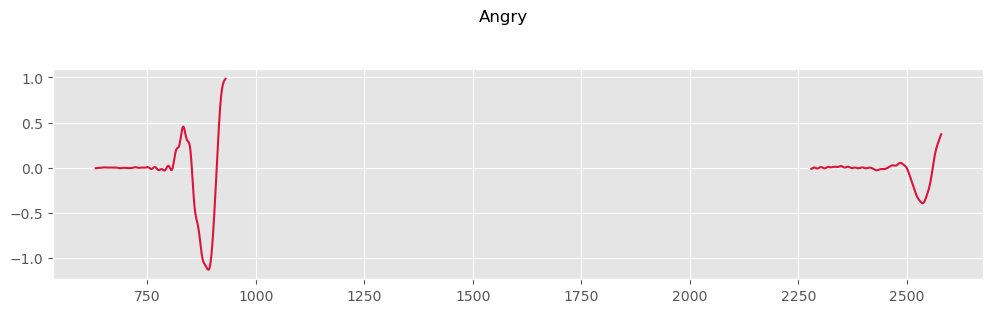

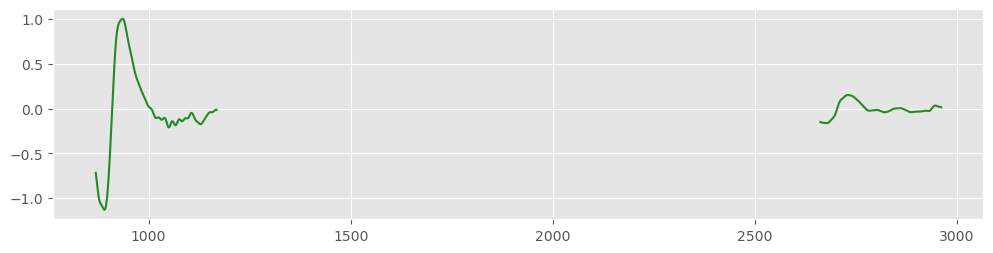

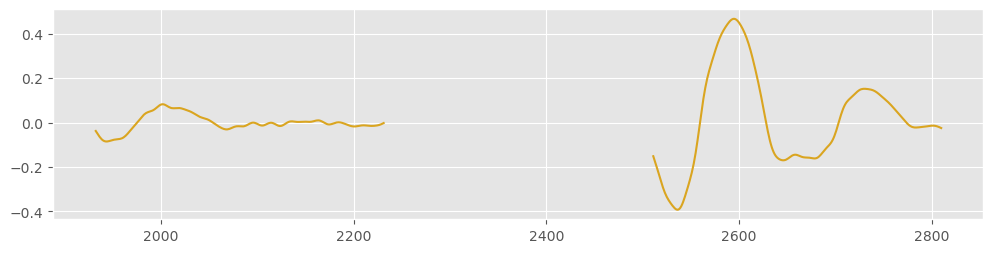

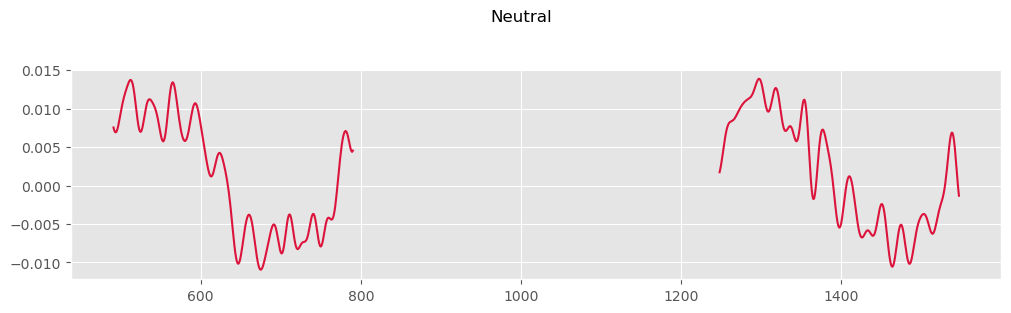

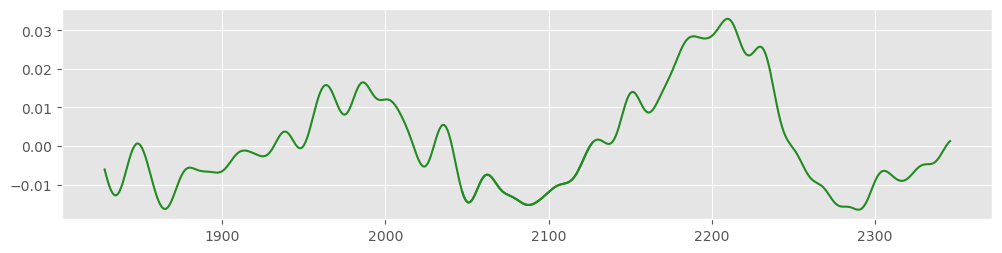

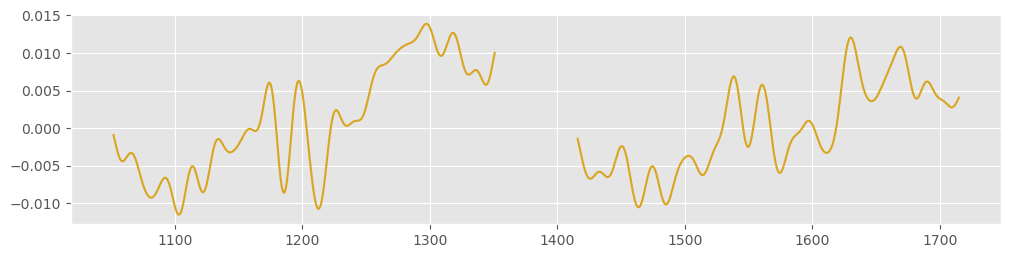

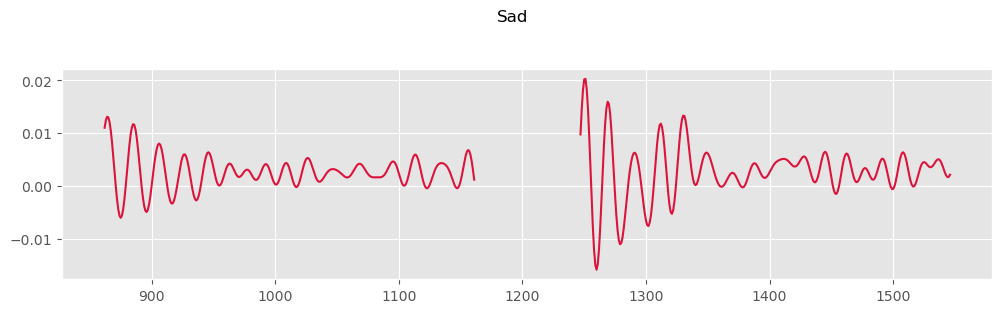

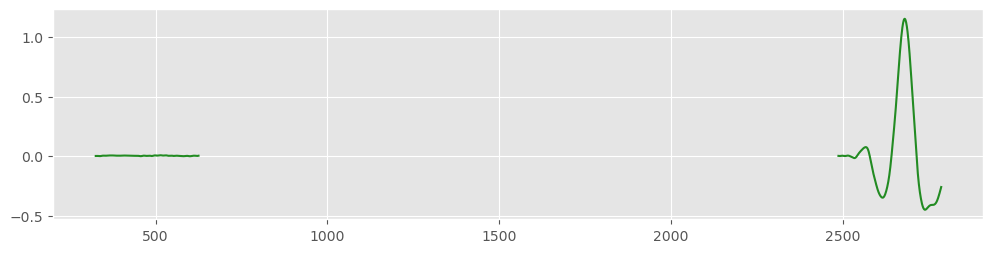

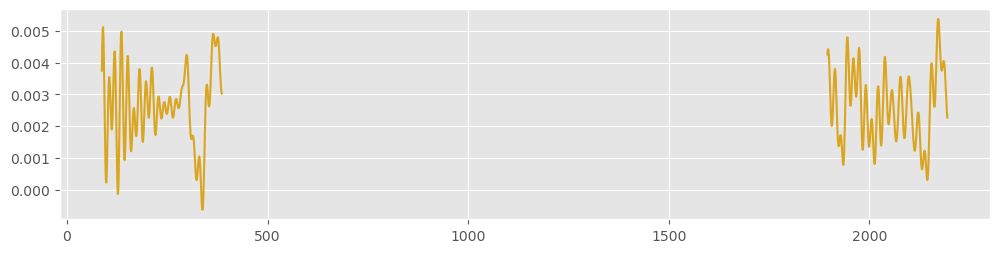

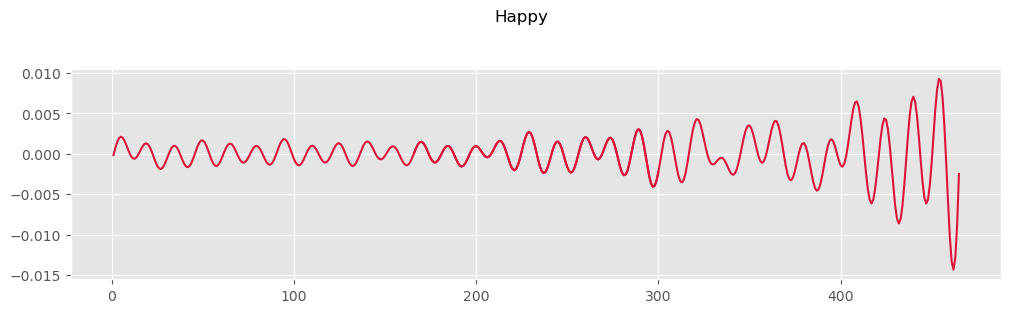

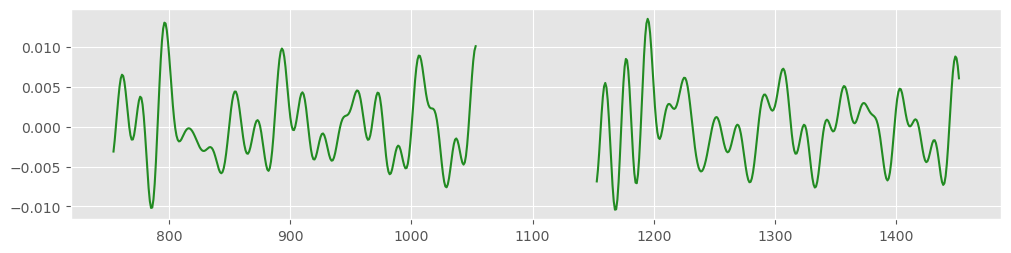

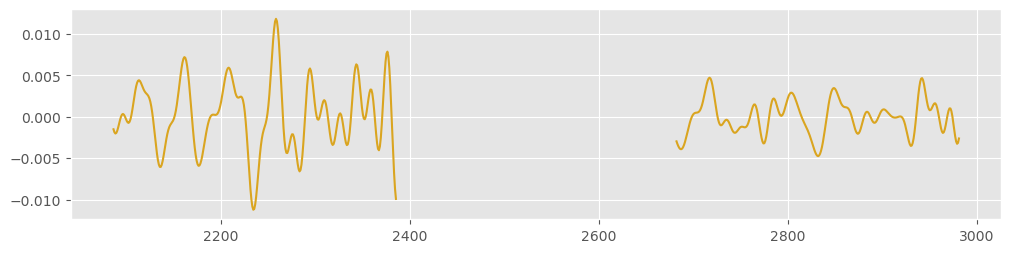

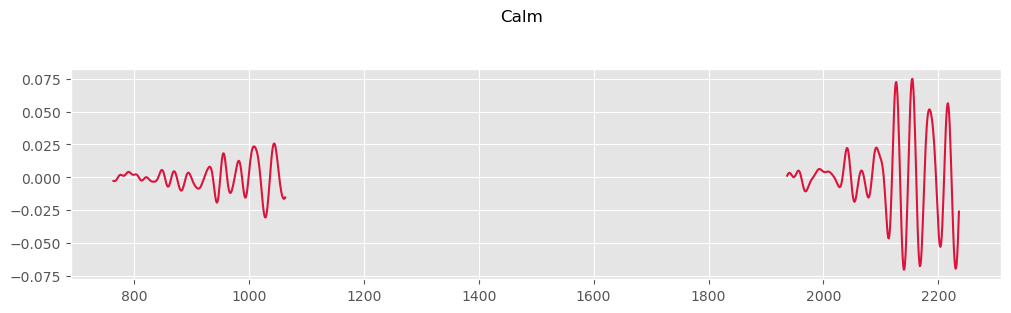

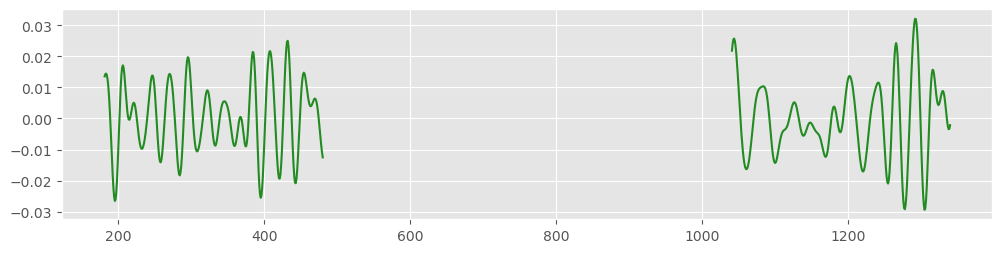

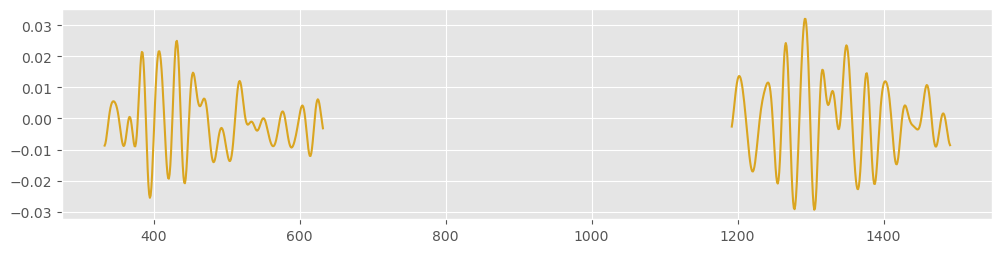

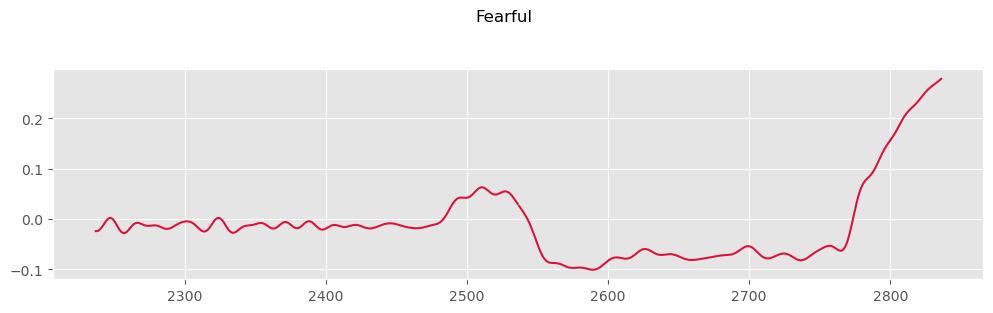

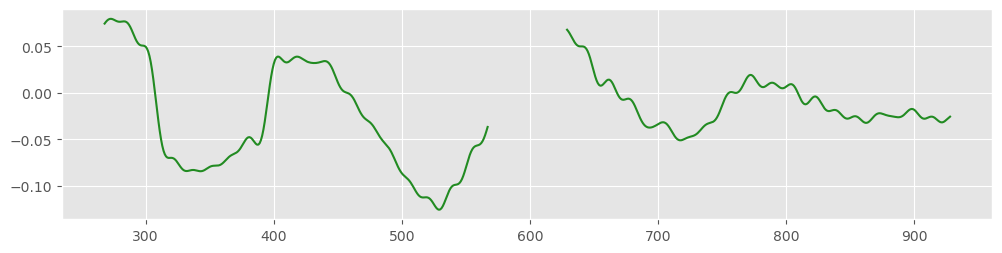

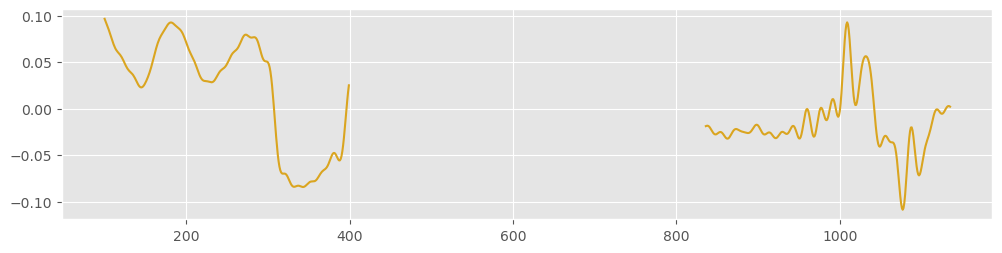

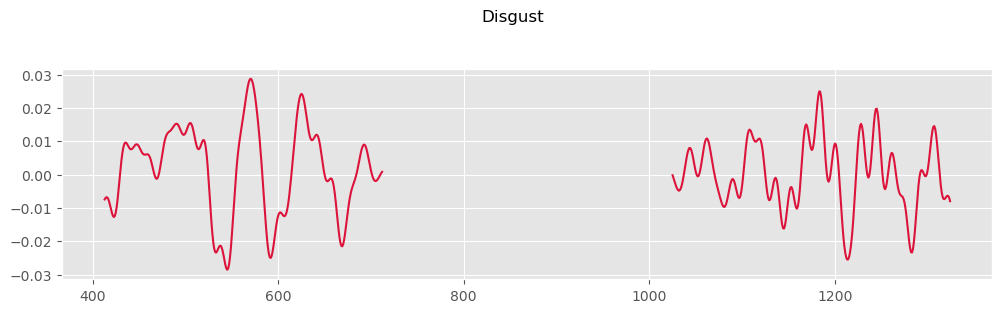

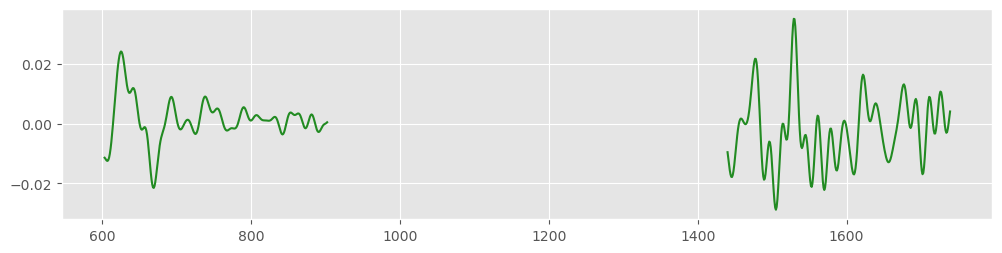

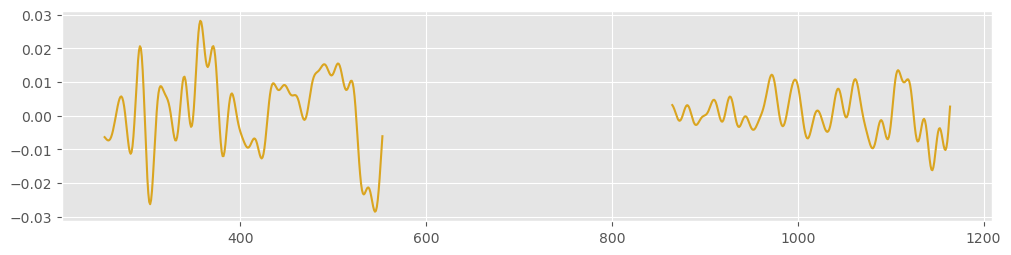

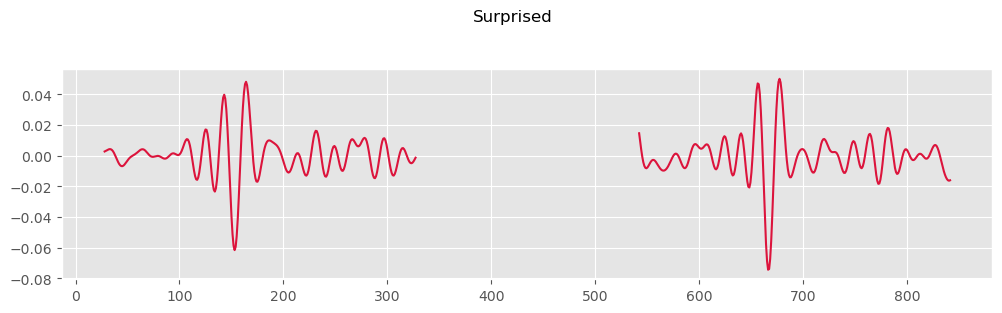

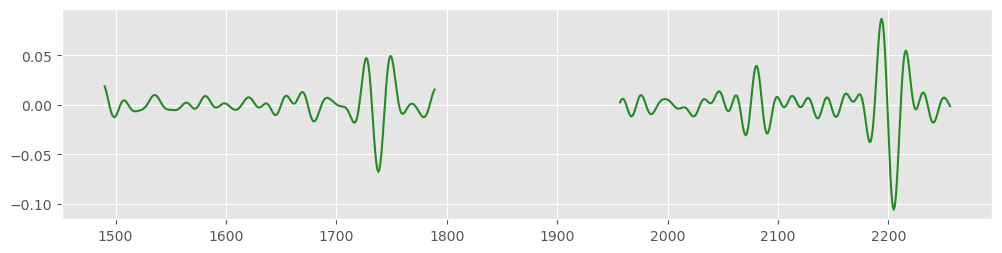

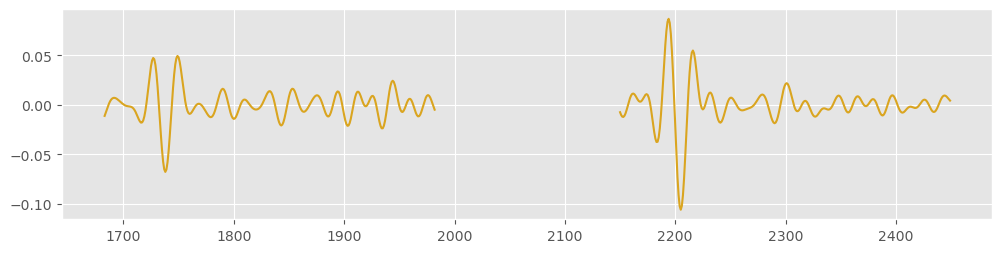

In [27]:
# motifs found
for y in range(8):
    plt.suptitle(f'{labels[idx_and_emo[y][1]]}'.capitalize())
    mo_dft, mod_dft = mo_mod_dict_dft[y][0], mo_mod_dict_dft[y][1]
    ts_dft = ts[y]
    for m, d, c in zip(mo_dft, mod_dft, colors):
        for i in m:
            plt.subplot(211)
            m_shape = ts_dft[i:i+w]
            plt.plot(range(i,i+w), m_shape, color=c)
        plt.show()

### PAA

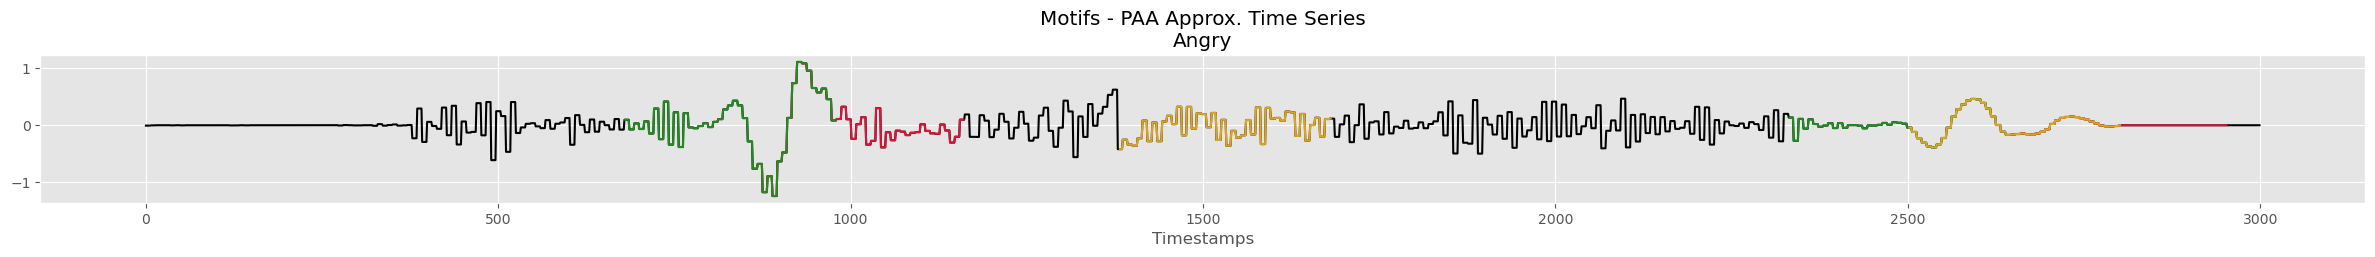

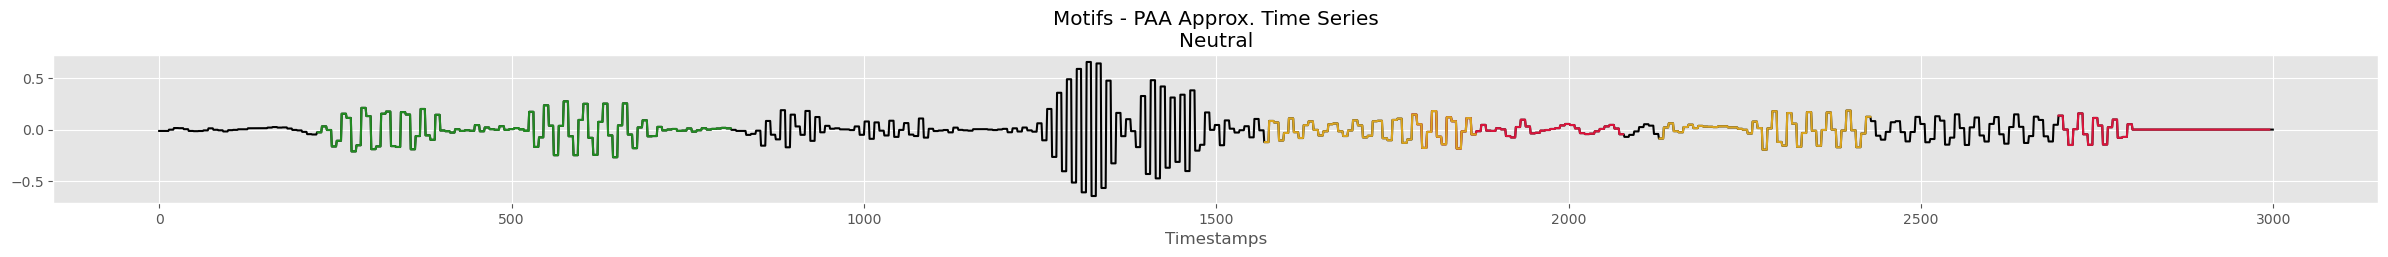

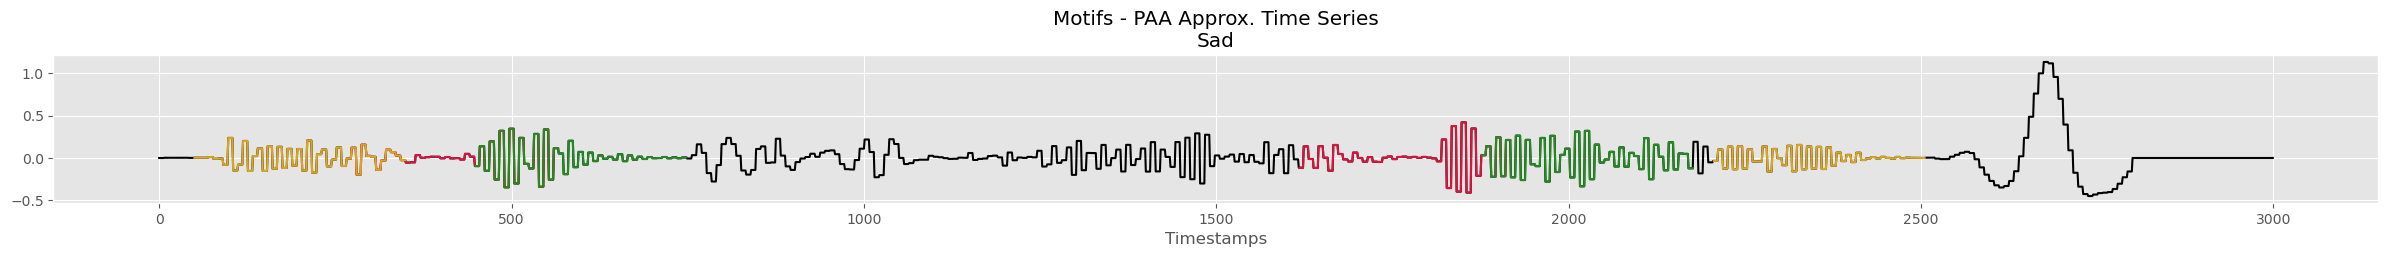

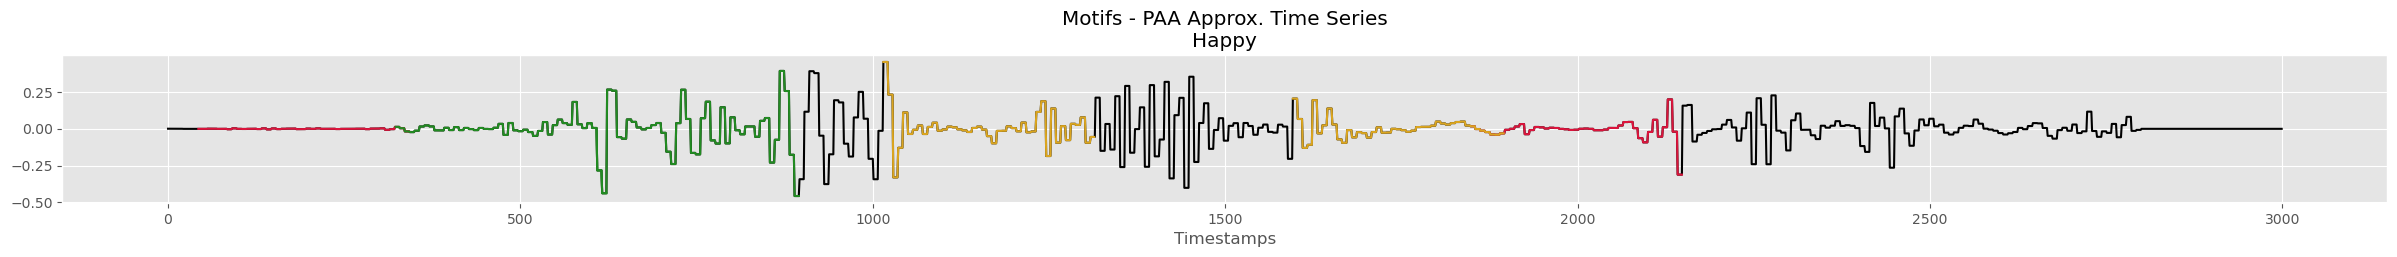

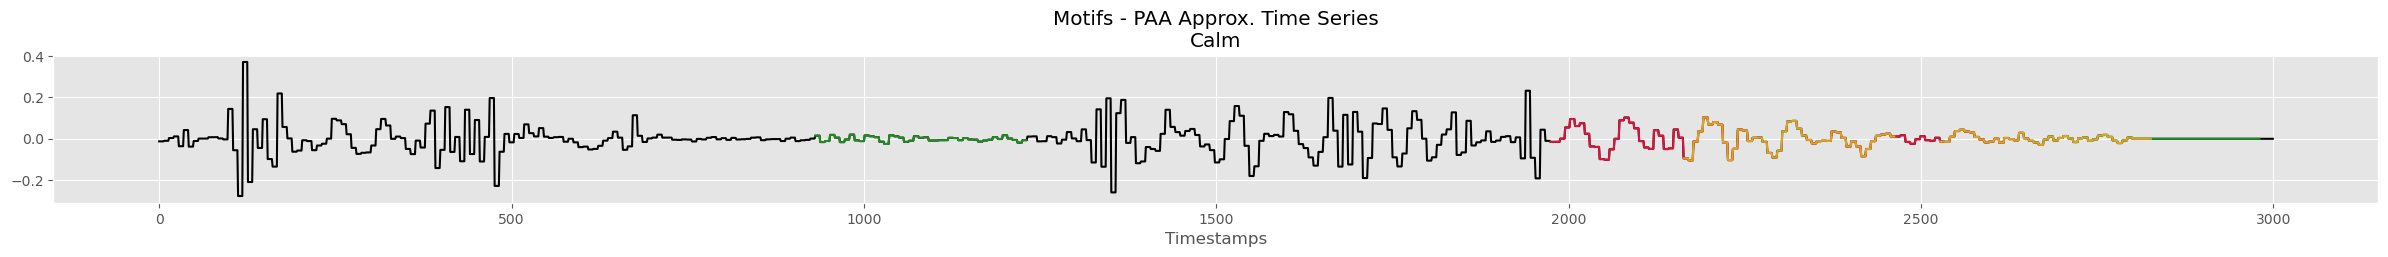

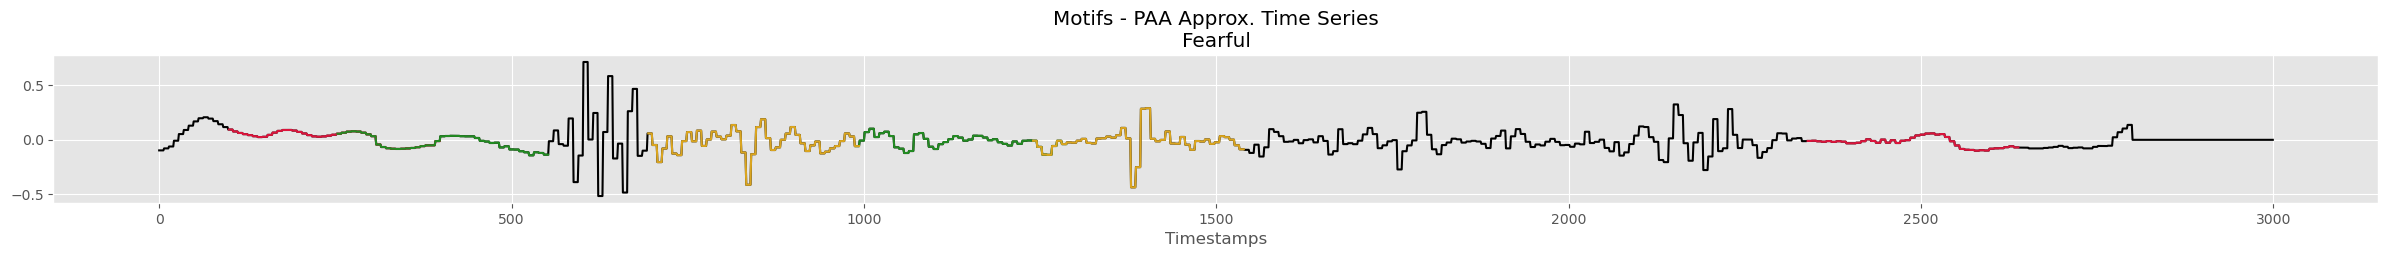

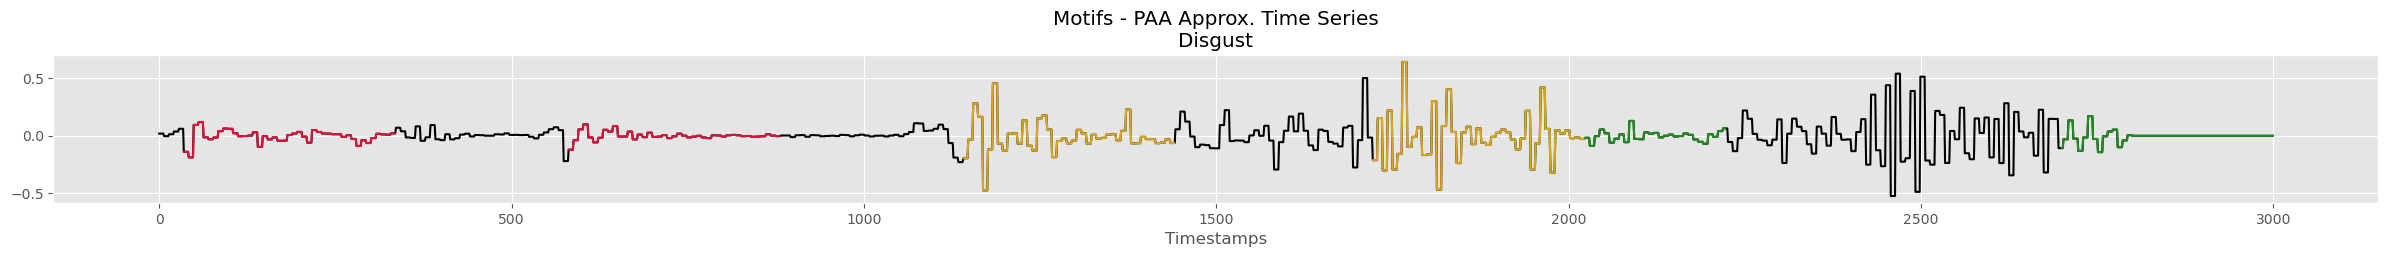

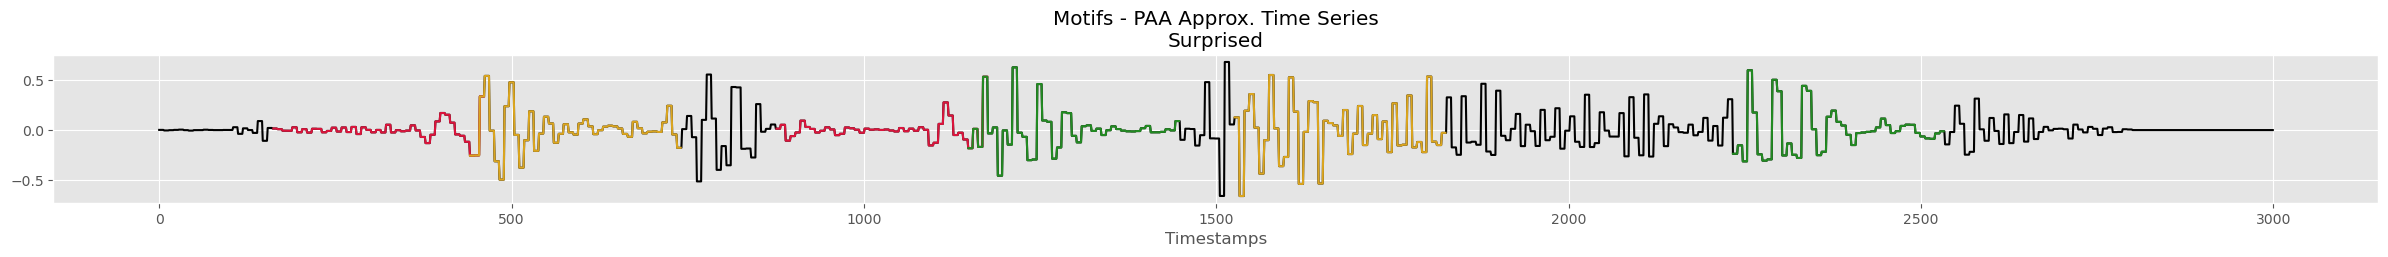

In [28]:
ts_paa = df_paa.iloc[idx_emo, 1:].values
ts = ts_paa.copy()

col = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
n = 0
mo_mod_dict_paa = {} #dict with different mo, mod for each emotion
for x in range(8):
    n += 1
    ts_paa = ts[x]
    mp_paa, mpi_paa = mp_dict_paa[x][0], mp_dict_paa[x][1]
    
    plt.figure(figsize=(30, 18))
    plt.subplot(8,1,n)

    mo_paa, mod_paa  = motifs.motifs(ts_paa, (mp_paa, mpi_paa), max_motifs=max_motifs, n_neighbors = n_neighbors)
    mo_mod_dict_paa[x] = (mo_paa, mod_paa)
    
    plt.plot(ts_paa, c = 'k')
    colors = ['crimson', 'forestgreen', 'goldenrod', 'b', 'y'][:len(mo_paa)]
    for m, d, c in zip(mo_paa, mod_paa, colors):
        for i in m:
            m_shape = ts_paa[i:i+w]
            plt.plot(range(i,i+w), m_shape, color=c)
    plt.title('Motifs - PAA Approx. Time Series\n' + f'{labels[idx_and_emo[x][1]]}'.capitalize())
    plt.xlabel('Timestamps')

In [29]:
mo_mod_dict_paa

{0: ([[861, 2653], [680, 2332], [1382, 2502]],
  [6.558859888378867, 7.772313626591201, 10.256444484514775]),
 1: ([[1778, 2695], [225, 512], [1569, 2129]],
  [8.743925676623952, 10.366930375591469, 10.696577313485212]),
 2: ([[267, 1618], [449, 1877], [50, 2206]],
  [9.616016984850553, 11.10828546418913, 11.249049967111977]),
 3: ([[43, 1849], [323, 596], [1015, 1596]],
  [10.42459142593053, 10.42739702615367, 15.160446260073535]),
 4: ([[1974, 2338], [931, 2681], [2163, 2527]],
  [14.545069325824729, 14.694281372463143, 14.972311611371728]),
 5: ([[99, 2339], [253, 988], [694, 1240]],
  [9.540365026999977, 11.841297076632292, 12.213623879238822]),
 6: ([[35, 581], [1923, 2700], [1141, 1722]],
  [13.310059864663964, 13.748396063855797, 14.396448239637584]),
 7: ([[162, 876], [1148, 2233], [441, 1526]],
  [11.62031865694245, 13.109615705869727, 13.36702831952684])}

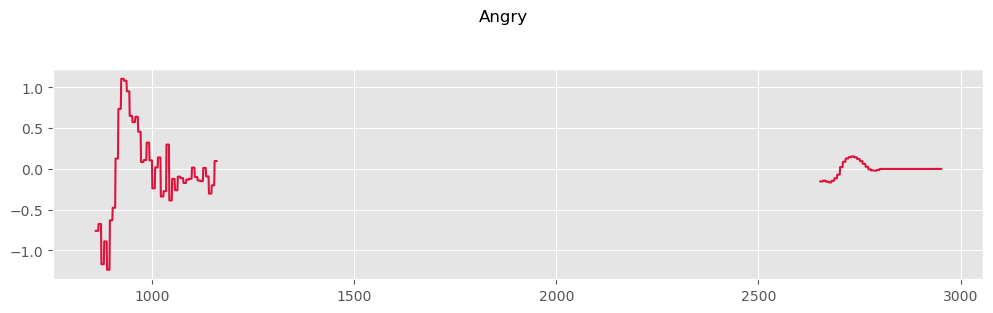

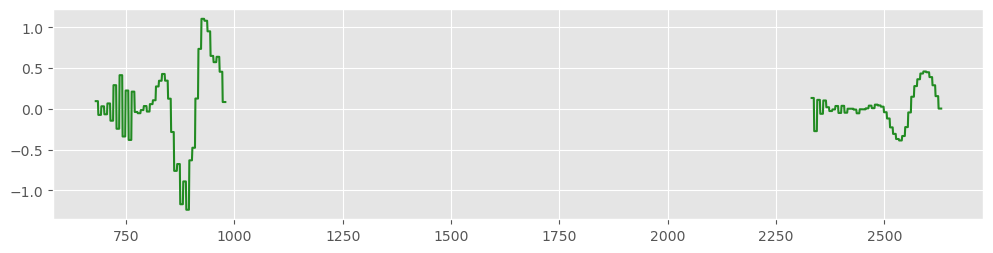

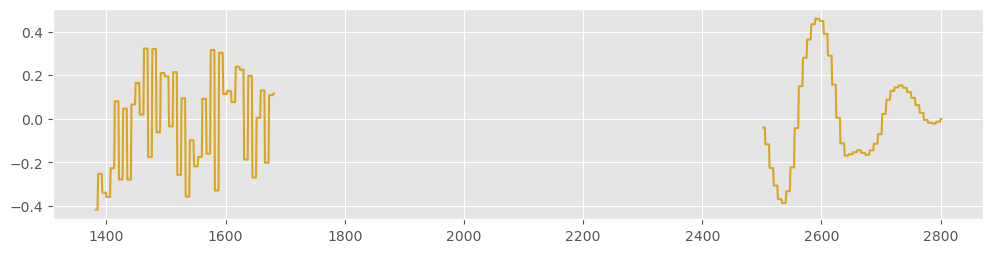

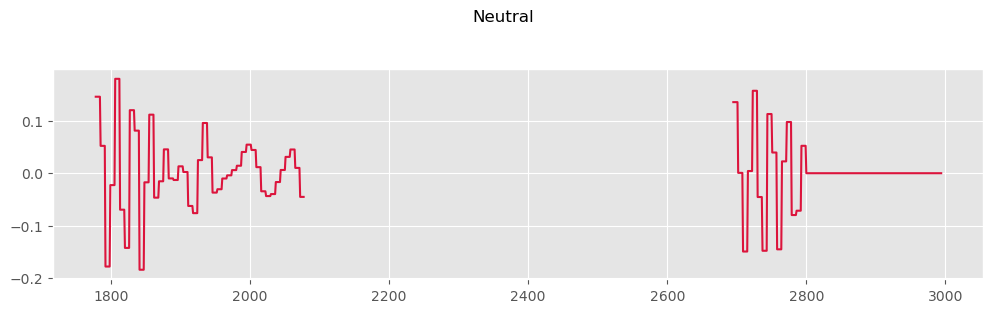

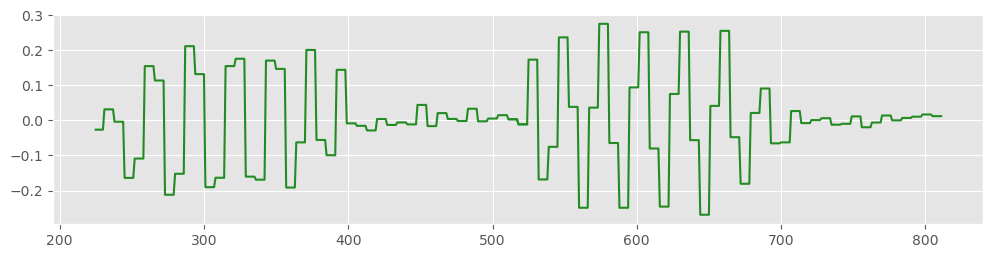

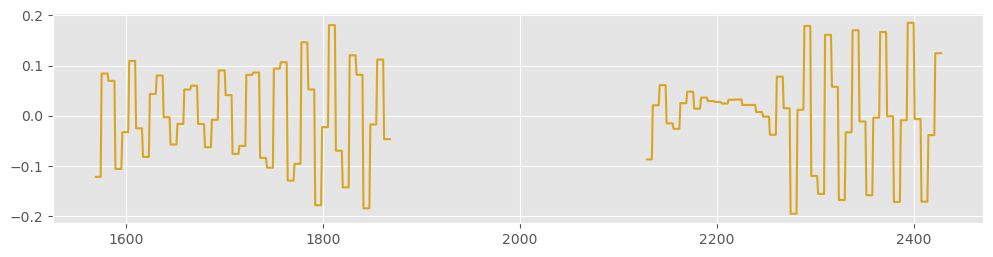

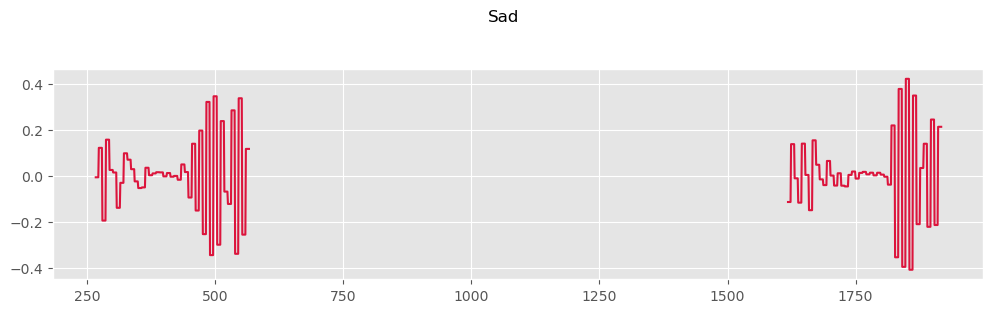

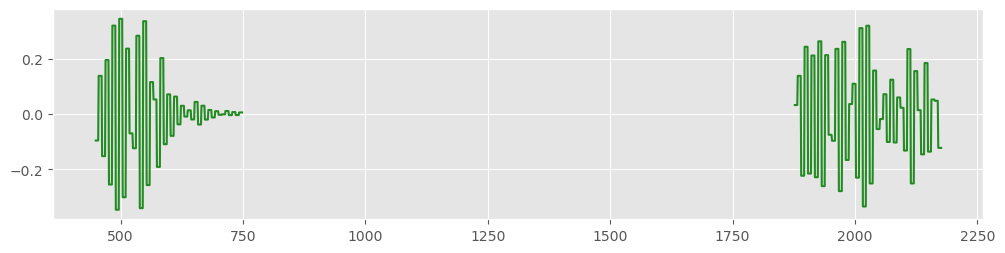

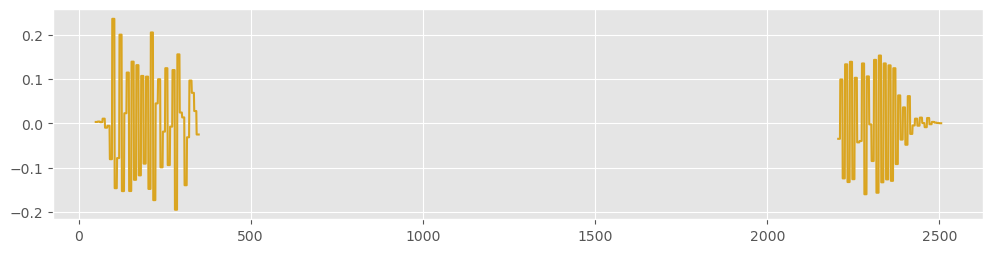

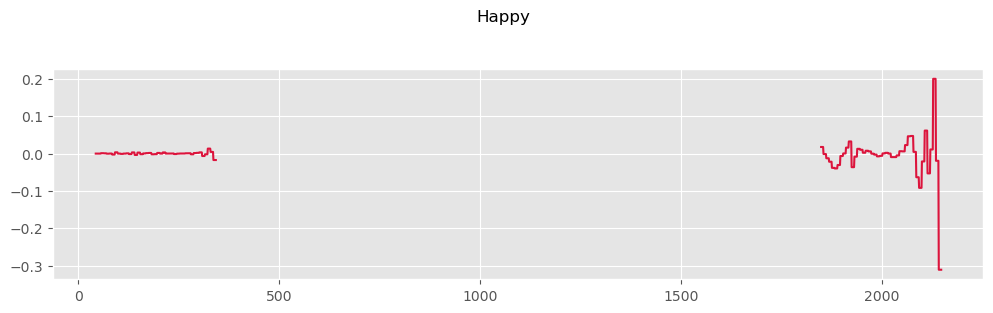

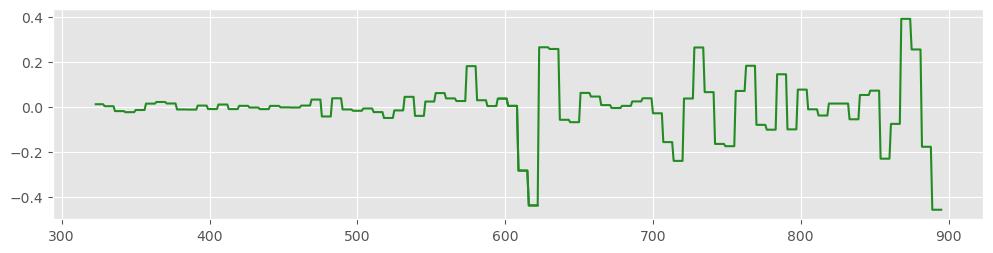

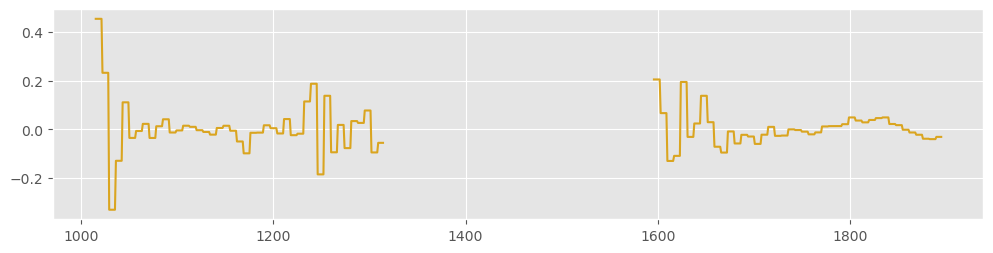

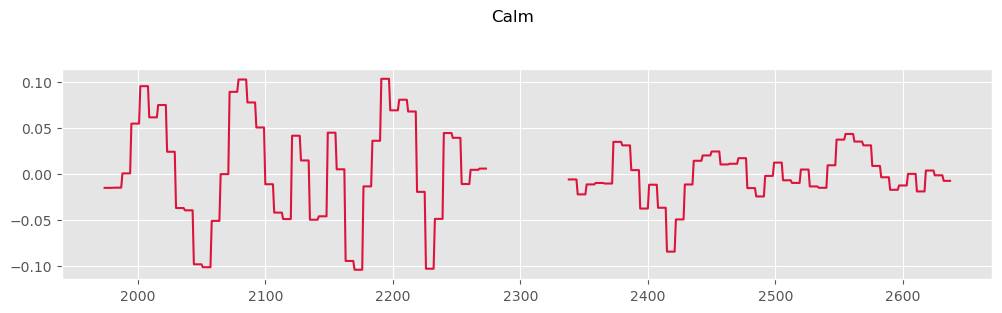

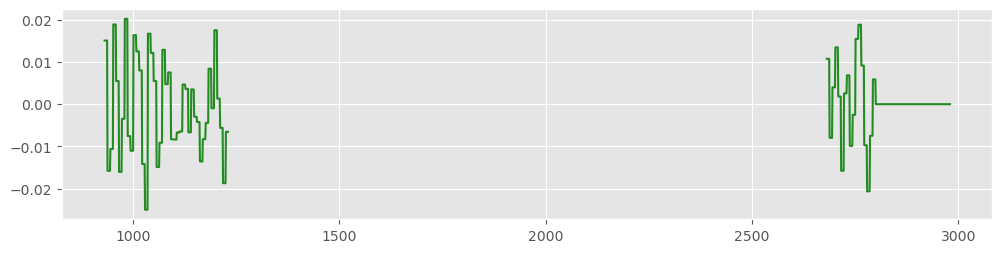

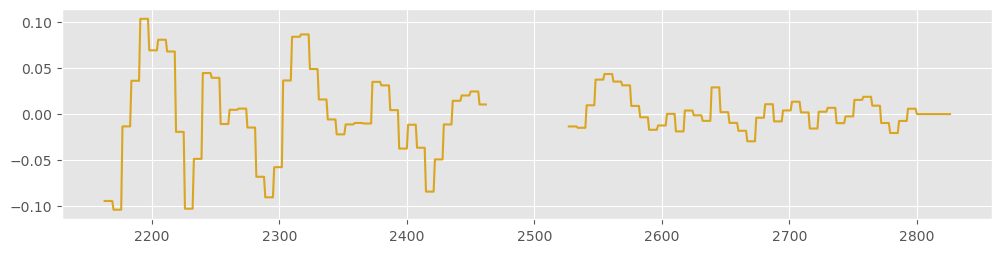

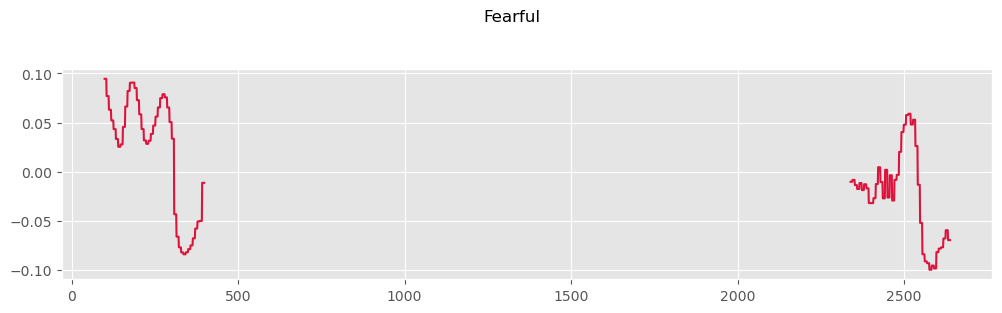

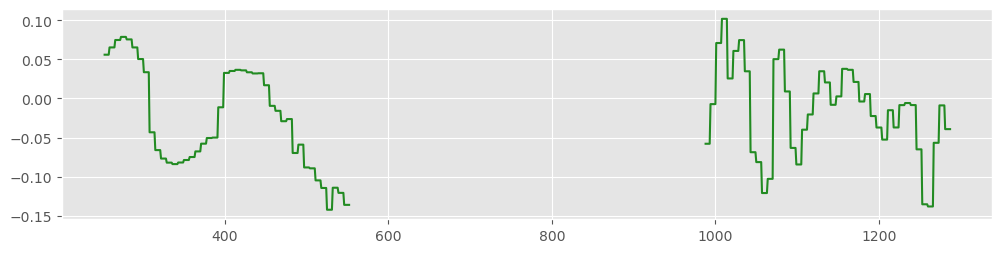

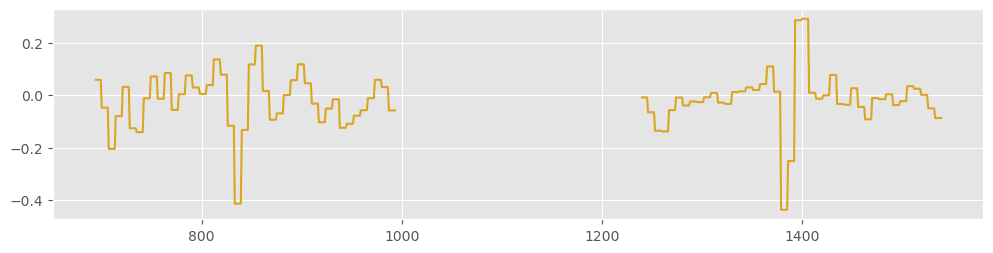

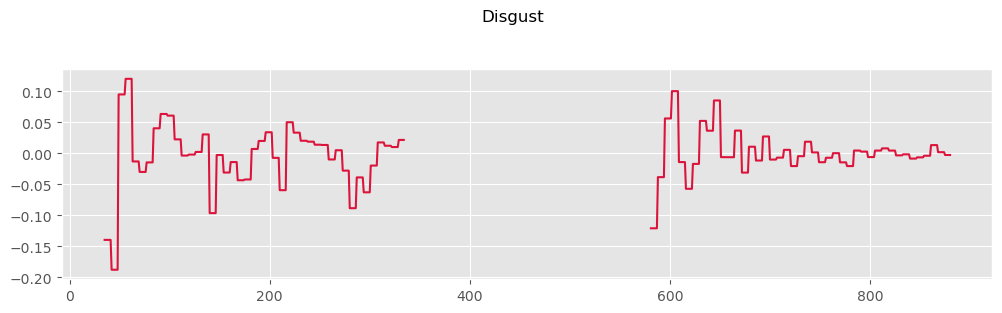

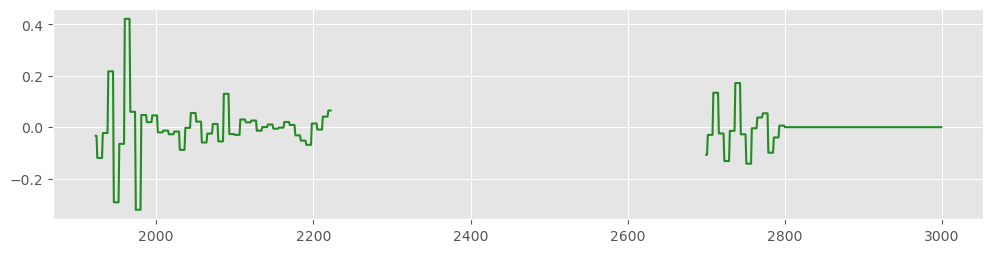

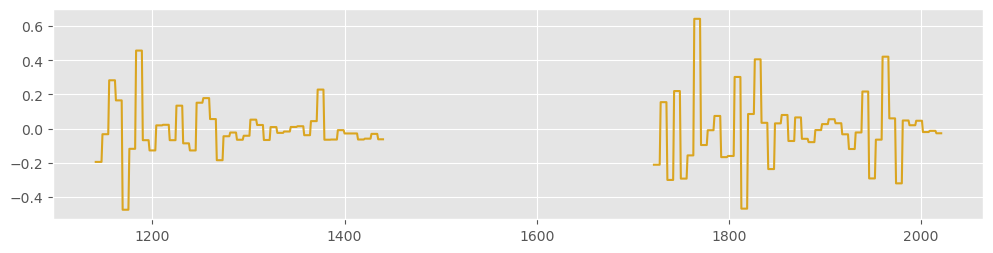

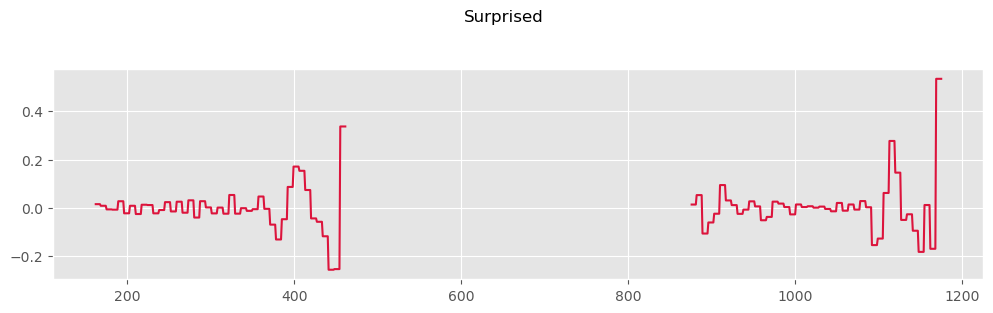

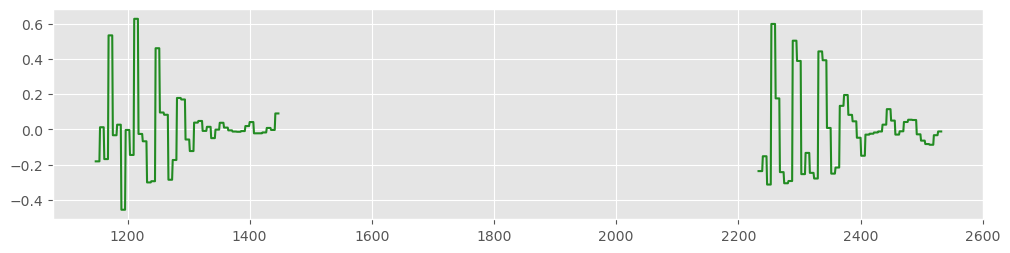

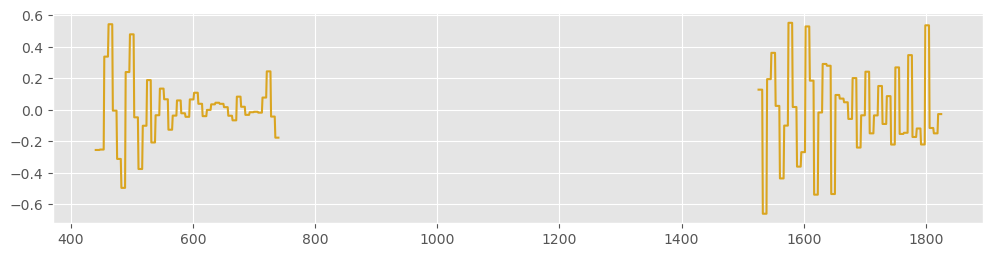

In [30]:
# motifs found
for y in range(8):
    plt.suptitle(f'{labels[idx_and_emo[y][1]]}'.capitalize())
    mo_paa, mod_paa = mo_mod_dict_paa[y][0], mo_mod_dict_paa[y][1]
    ts_paa = ts[y]
    for m, d, c in zip(mo_paa, mod_paa, colors):
        for i in m:
            plt.subplot(211)
            m_shape = ts_paa[i:i+w]
            plt.plot(range(i,i+w), m_shape, color=c)
        plt.show()

## Discords Discovery

In [31]:
ex_zone = 5
k = 4

### SAX

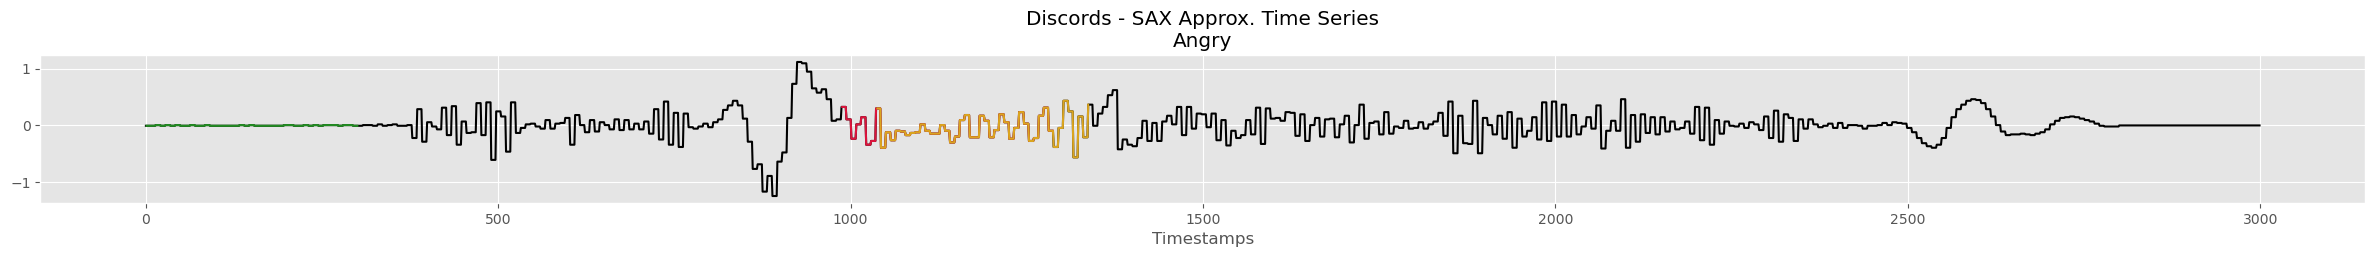

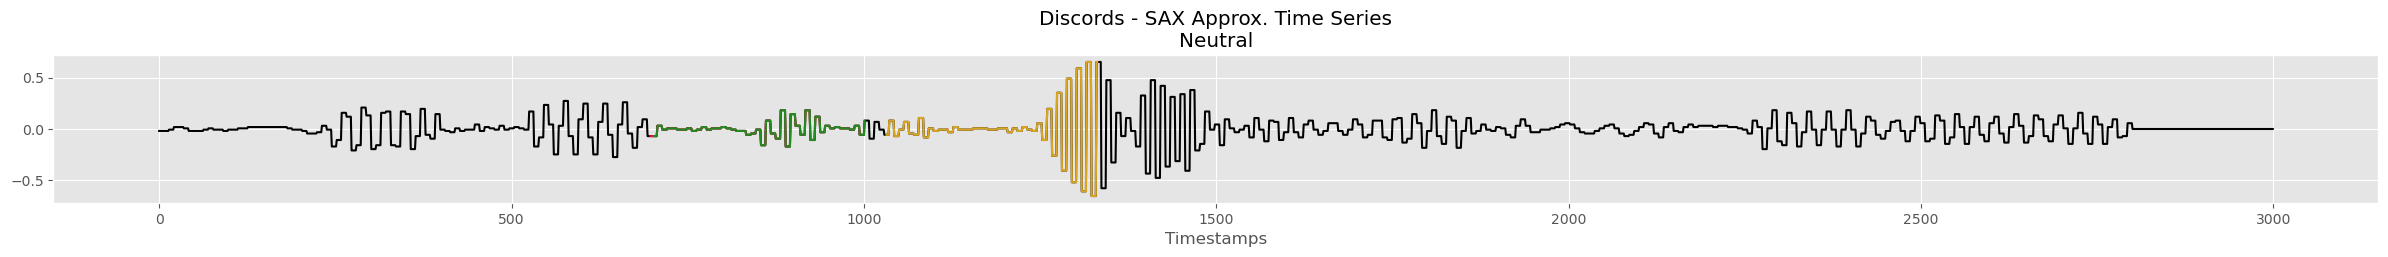

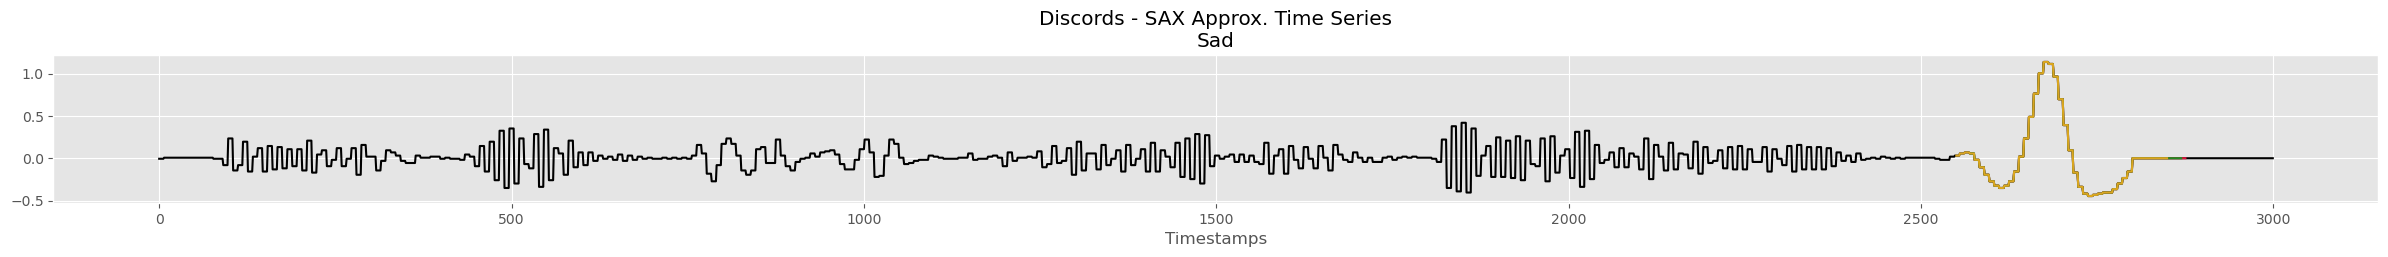

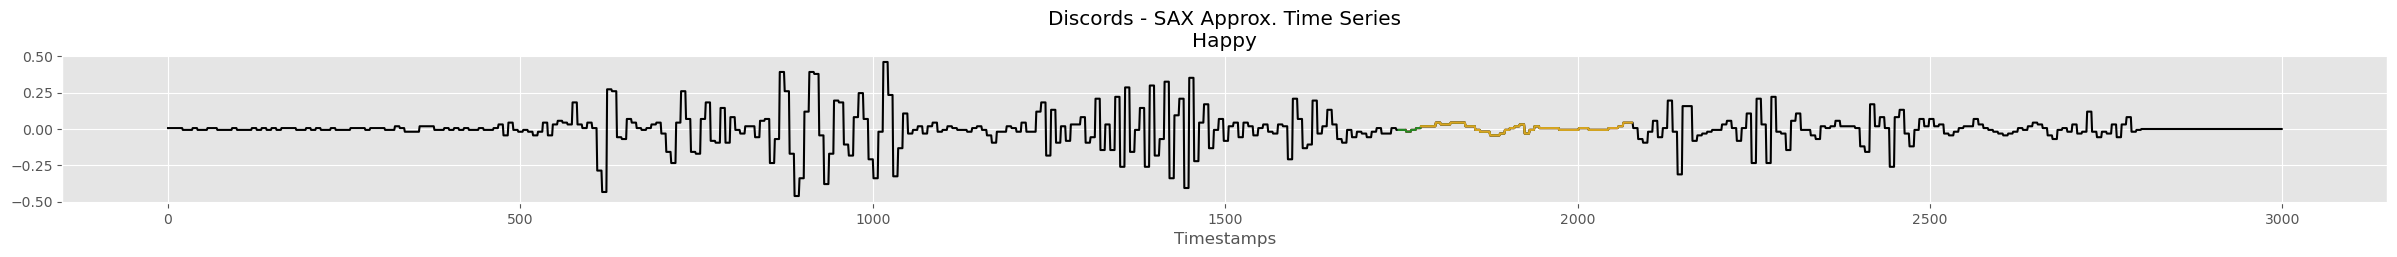

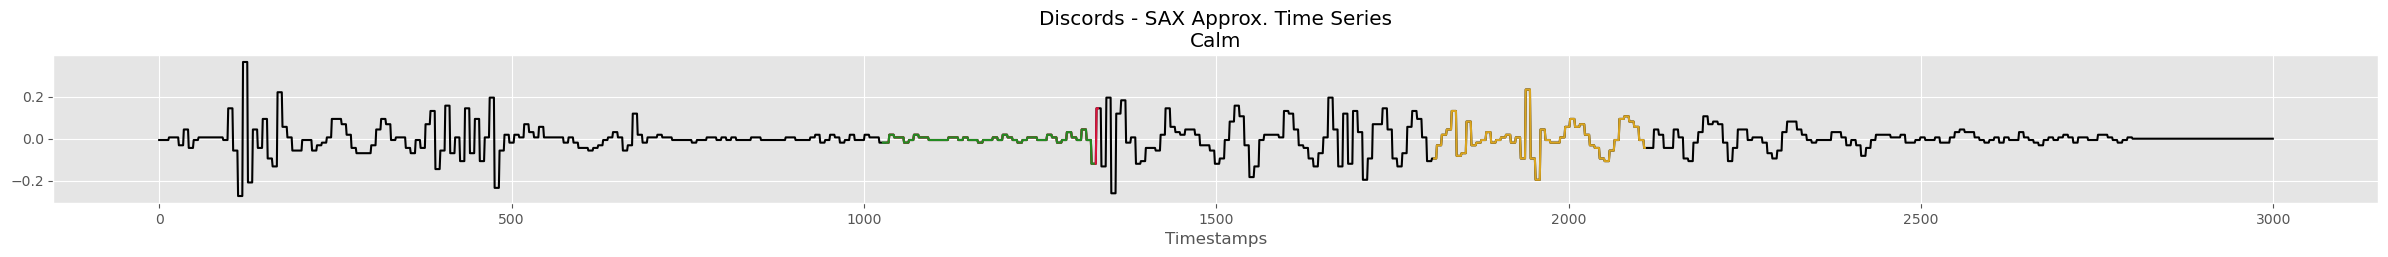

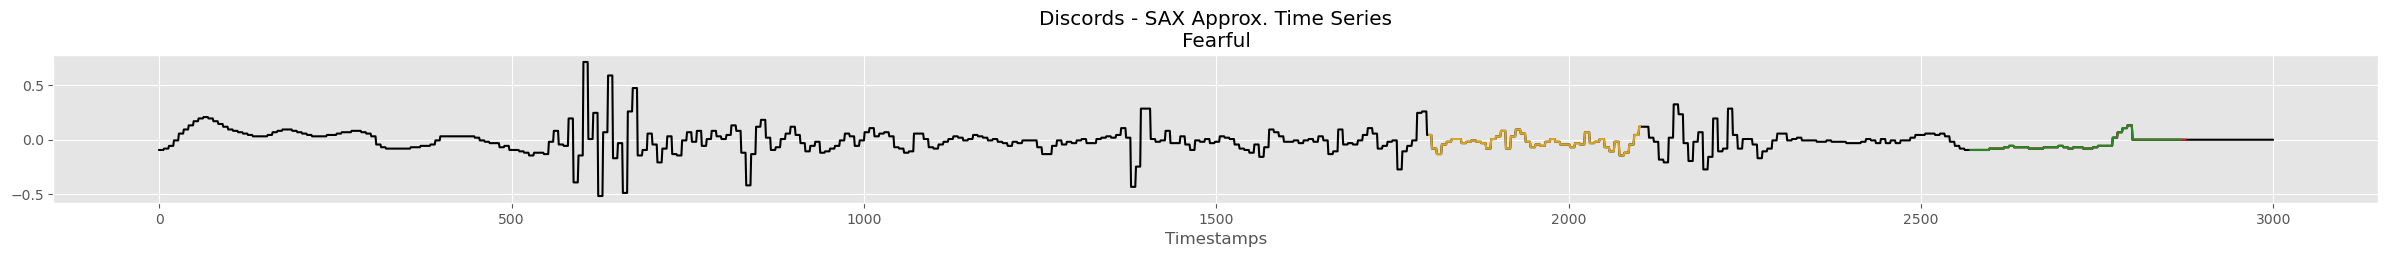

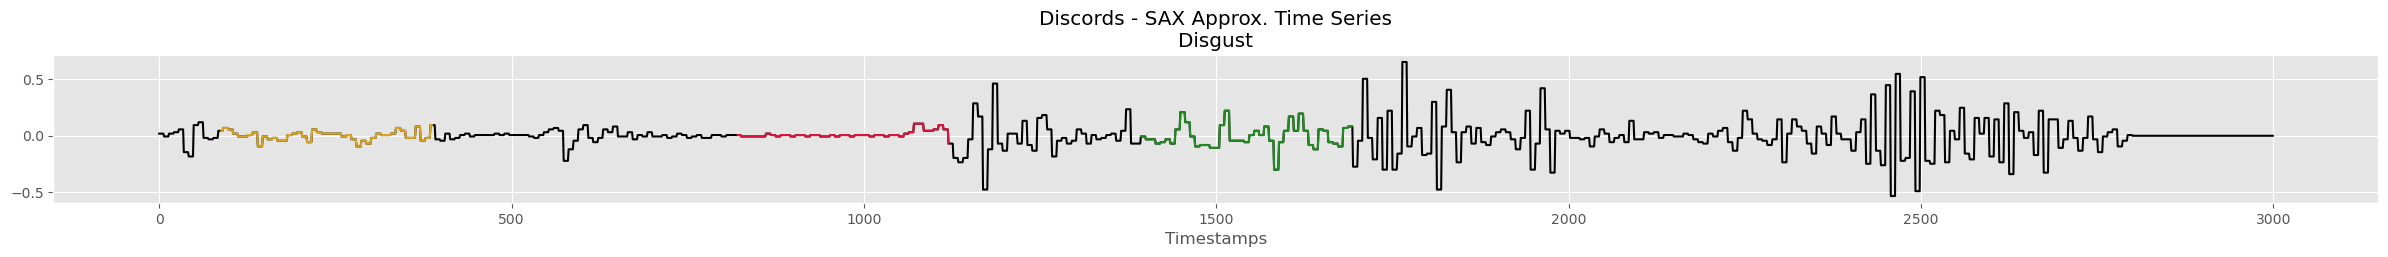

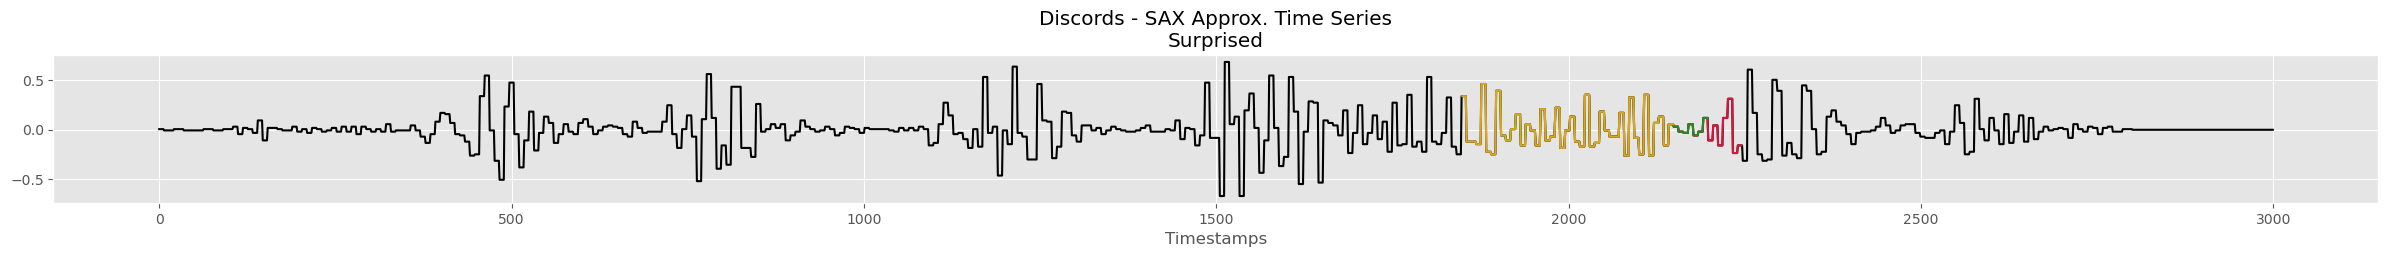

In [32]:
ts_sax = df_sax.iloc[idx_emo, 1:].values
ts = ts_sax.copy()

col = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
n = 0

for x in range(8):
    n += 1
    ts_sax = ts[x]
    mp_sax = mp_dict_sax[x][0]
    
    plt.figure(figsize=(30, 18))
    plt.subplot(8,1,n)
    
    anoms_sax = discords(mp_sax, ex_zone=ex_zone, k=k)
    plt.plot(ts_sax, c='k')
    colors = ['crimson', 'forestgreen', 'goldenrod', 'b', 'y'][:len(mo_sax)]
    for a, c in zip(anoms_sax, colors):
        a_shape = ts_sax[a:a+w]
        plt.plot(range(a, a+w), a_shape, color=c)

    plt.title('Discords - SAX Approx. Time Series\n' + f'{labels[idx_and_emo[x][1]]}'.capitalize())    
    plt.xlabel('Timestamps')

### DFT

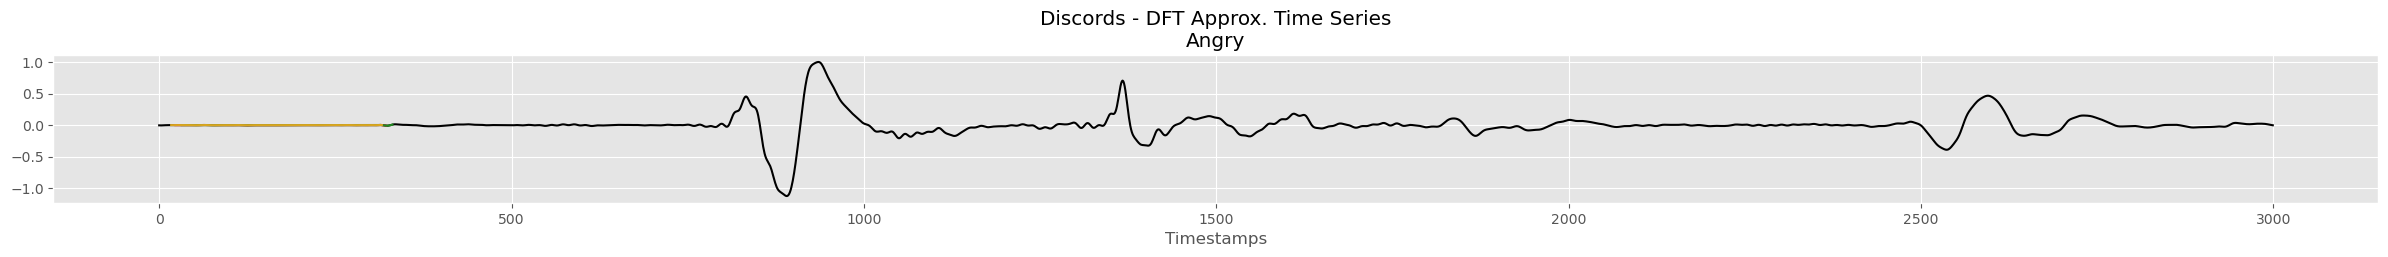

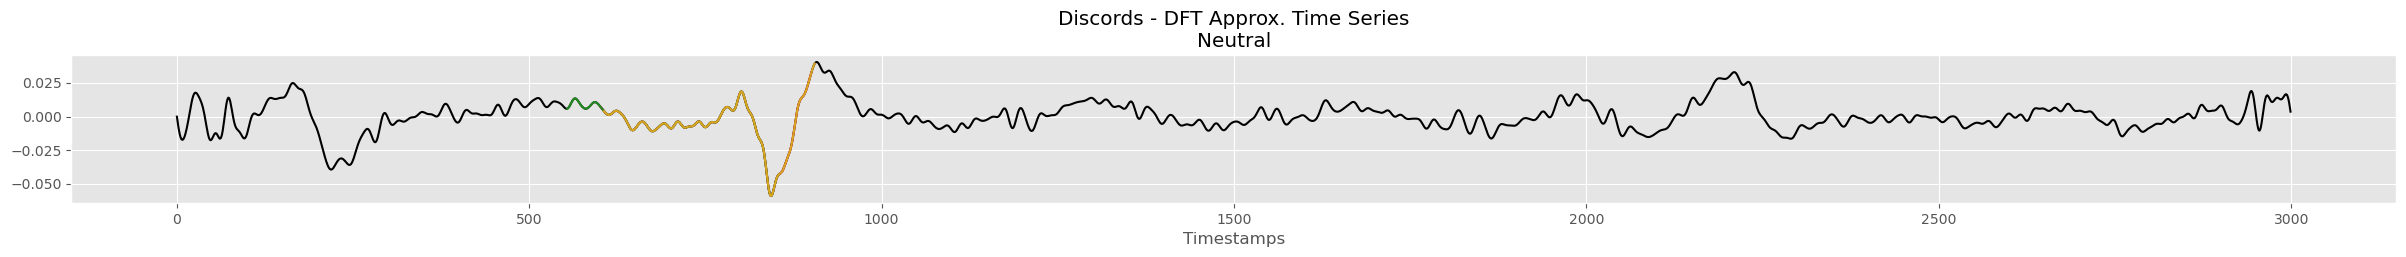

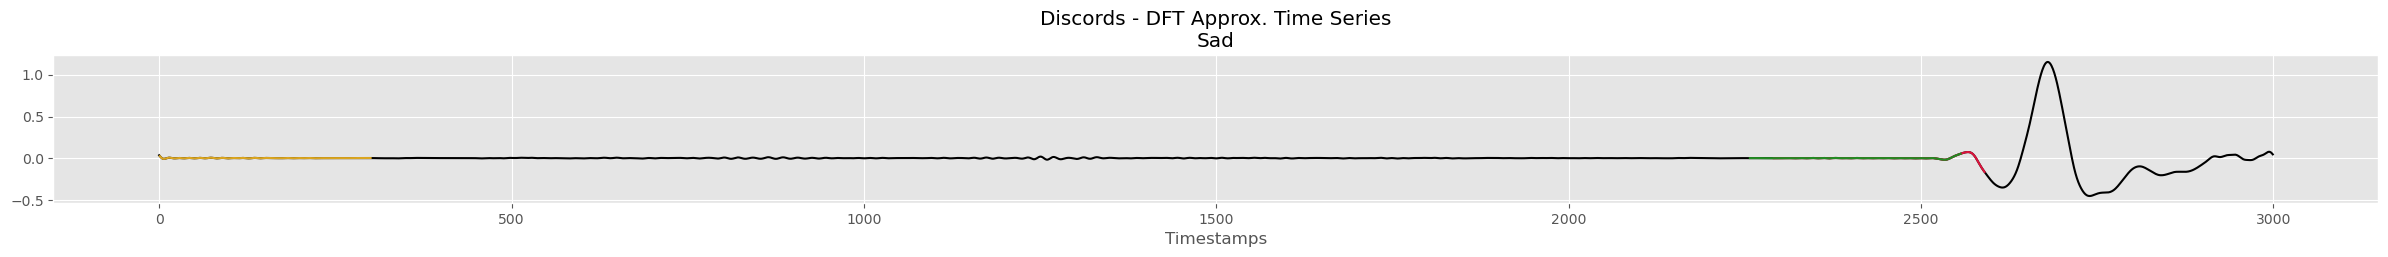

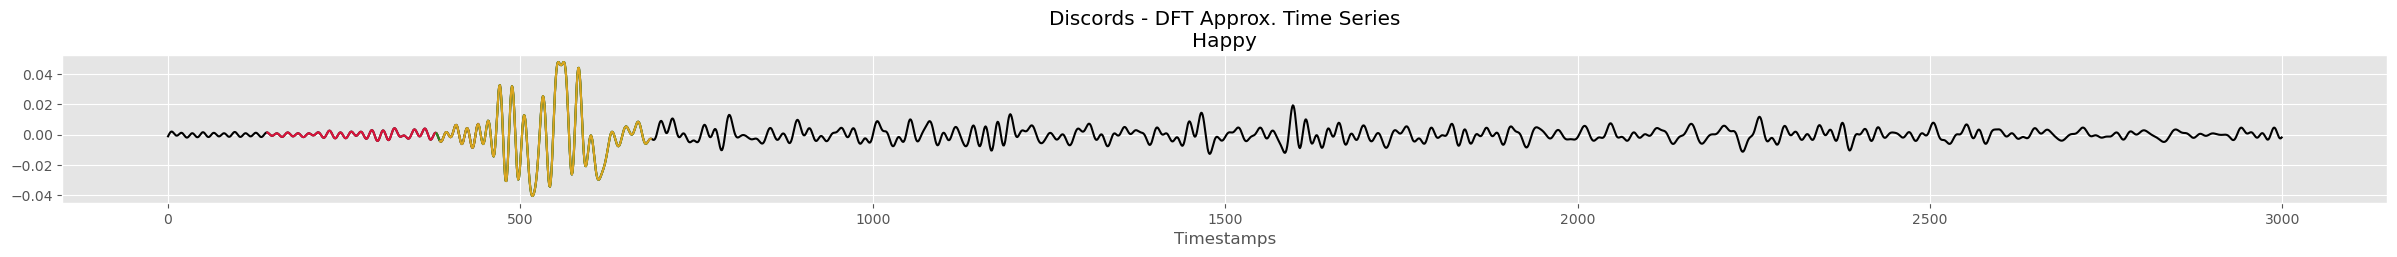

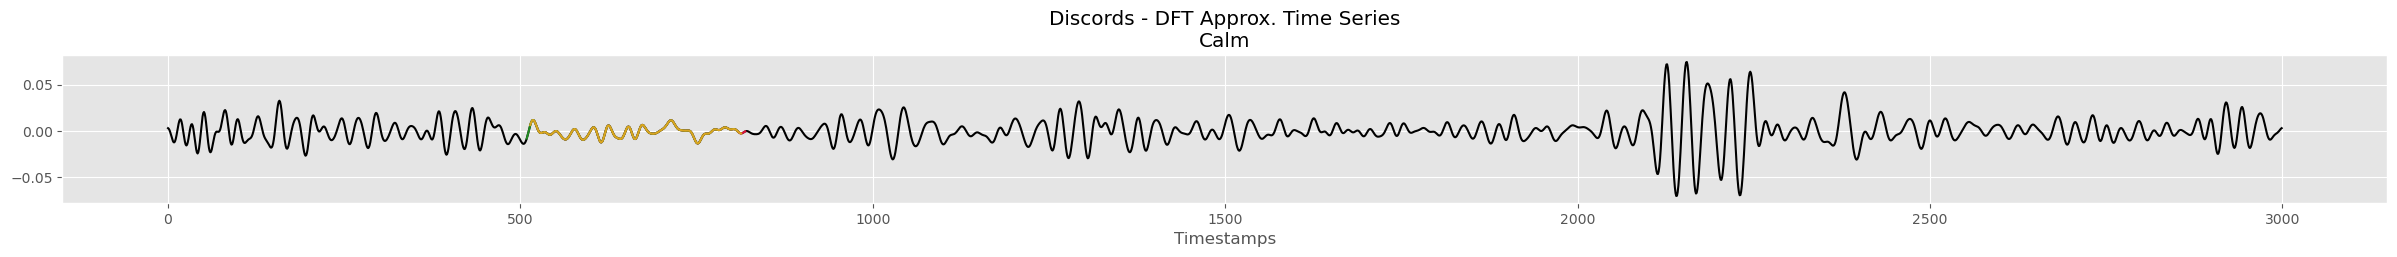

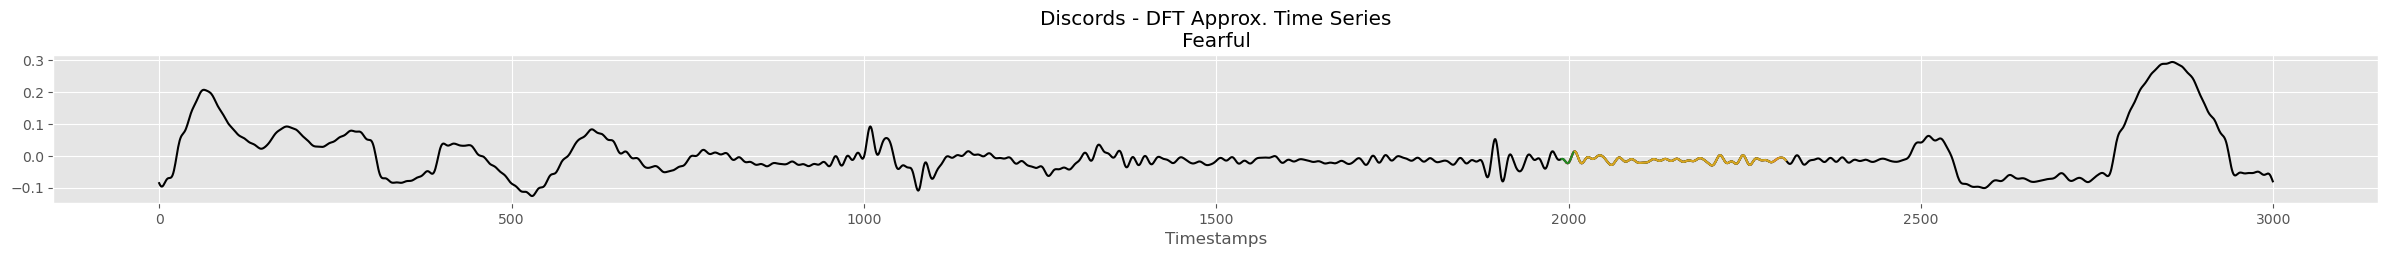

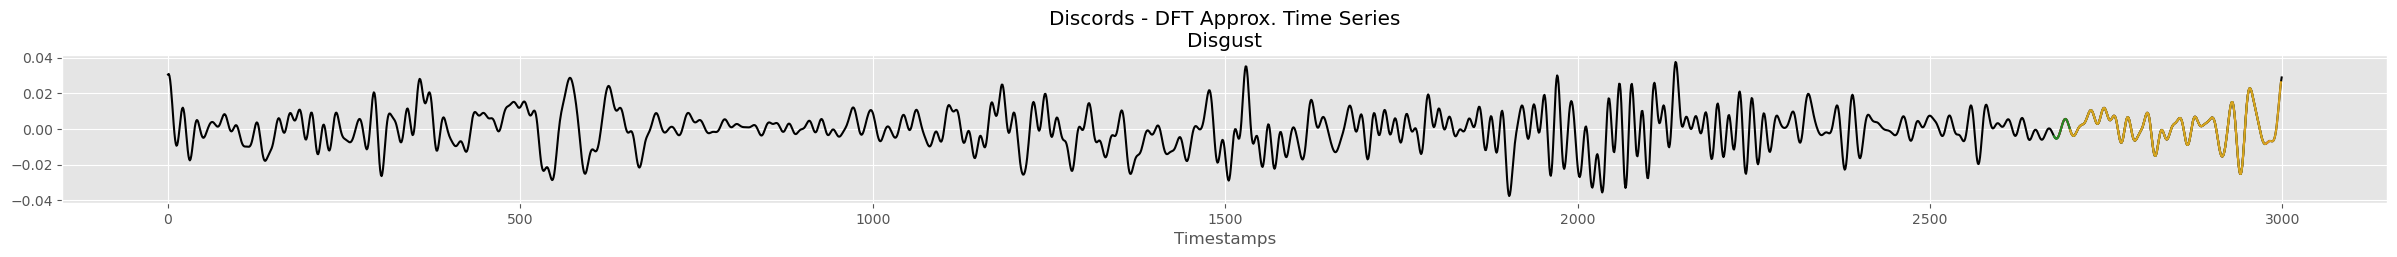

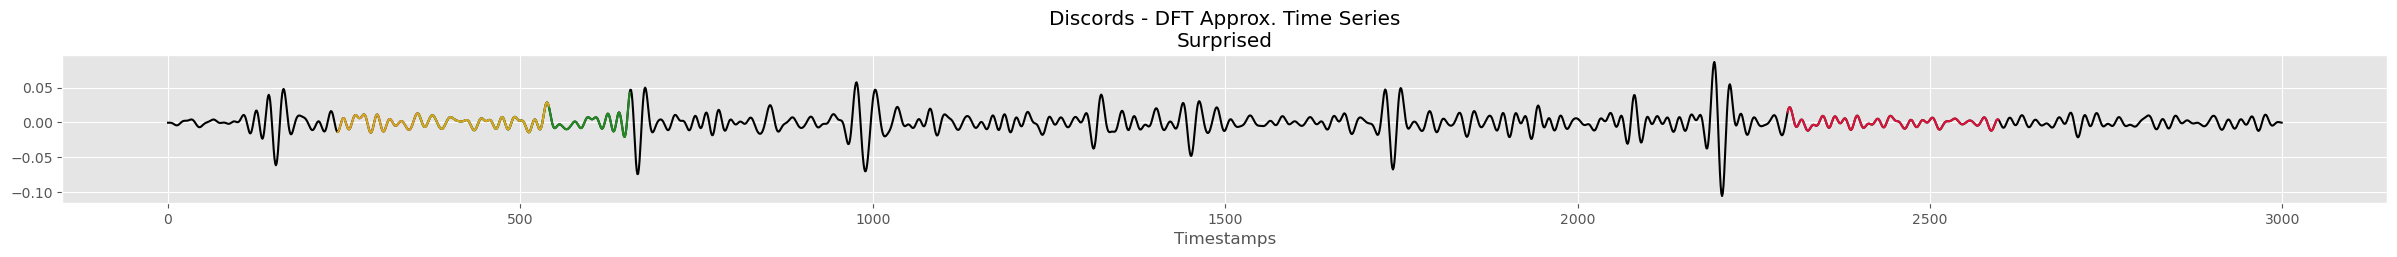

In [33]:
ts_dft = df_dft.iloc[idx_emo, 1:].values
ts = ts_dft.copy()

col = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
n = 0

for x in range(8):
    n += 1
    ts_dft = ts[x]
    mp_dft = mp_dict_dft[x][0]
    
    plt.figure(figsize=(30, 18))
    plt.subplot(8,1,n)
    
    anoms_dft = discords(mp_dft, ex_zone=ex_zone, k=k)
    plt.plot(ts_dft, c='k')
    colors = ['crimson', 'forestgreen', 'goldenrod', 'b', 'y'][:len(mo_dft)]
    for a, c in zip(anoms_dft, colors):
        a_shape = ts_dft[a:a+w]
        plt.plot(range(a, a+w), a_shape, color=c)

    plt.title('Discords - DFT Approx. Time Series\n' + f'{labels[idx_and_emo[x][1]]}'.capitalize())    
    plt.xlabel('Timestamps')

### PAA

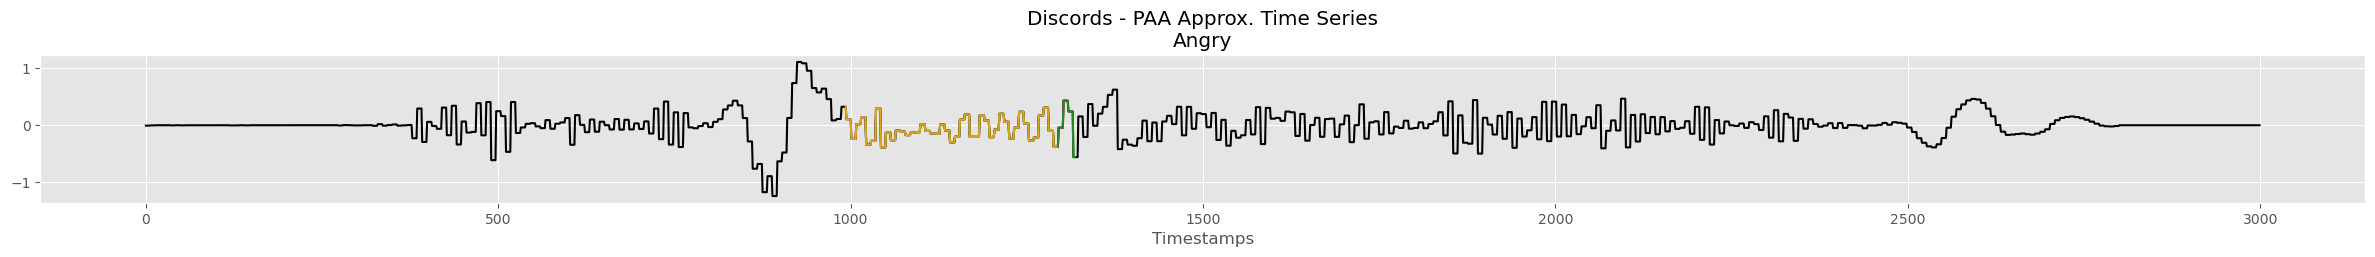

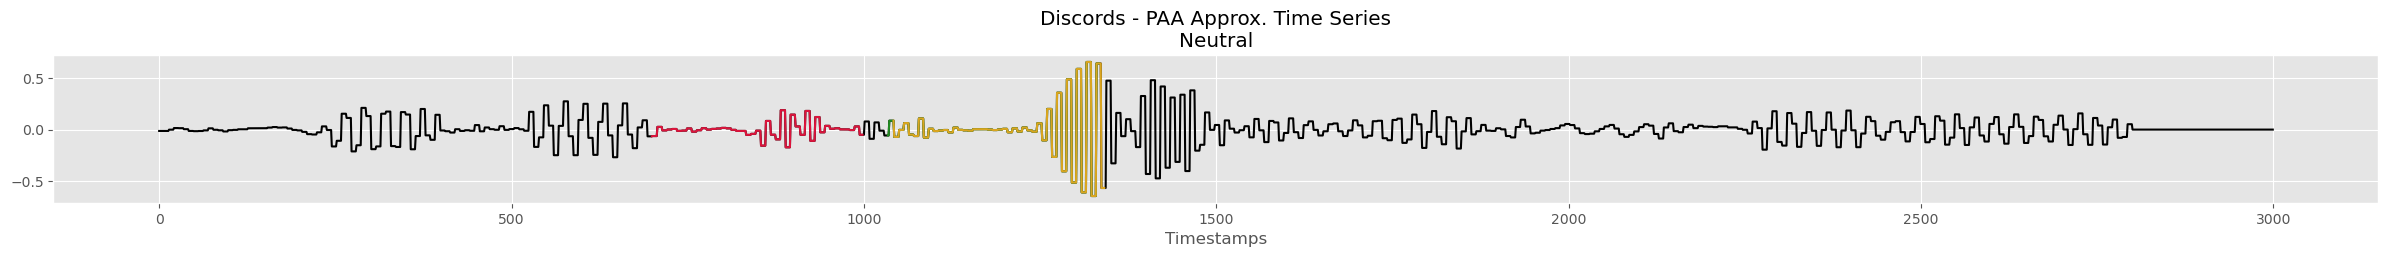

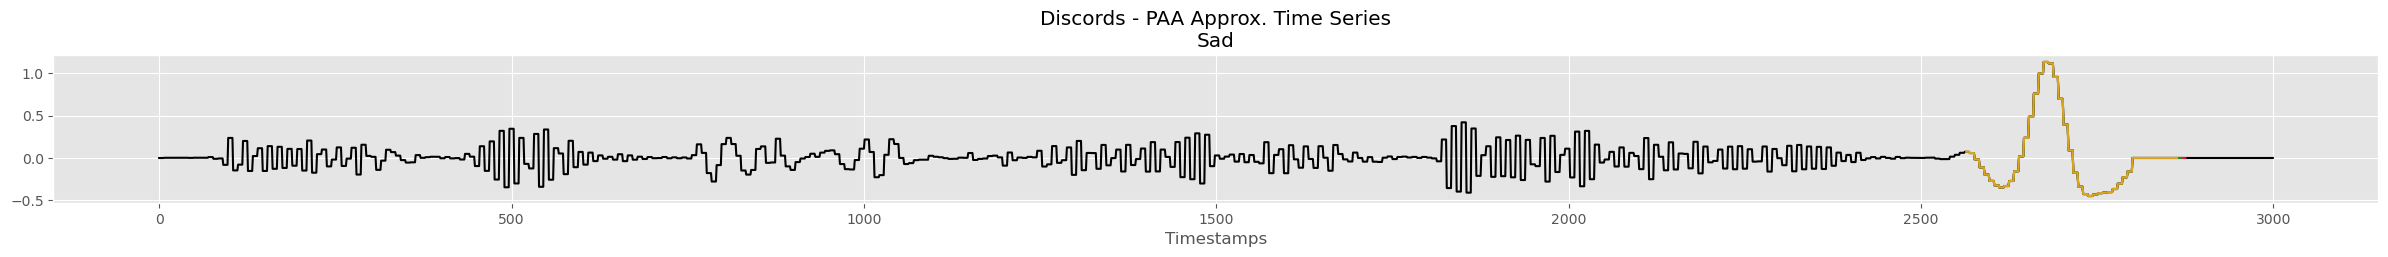

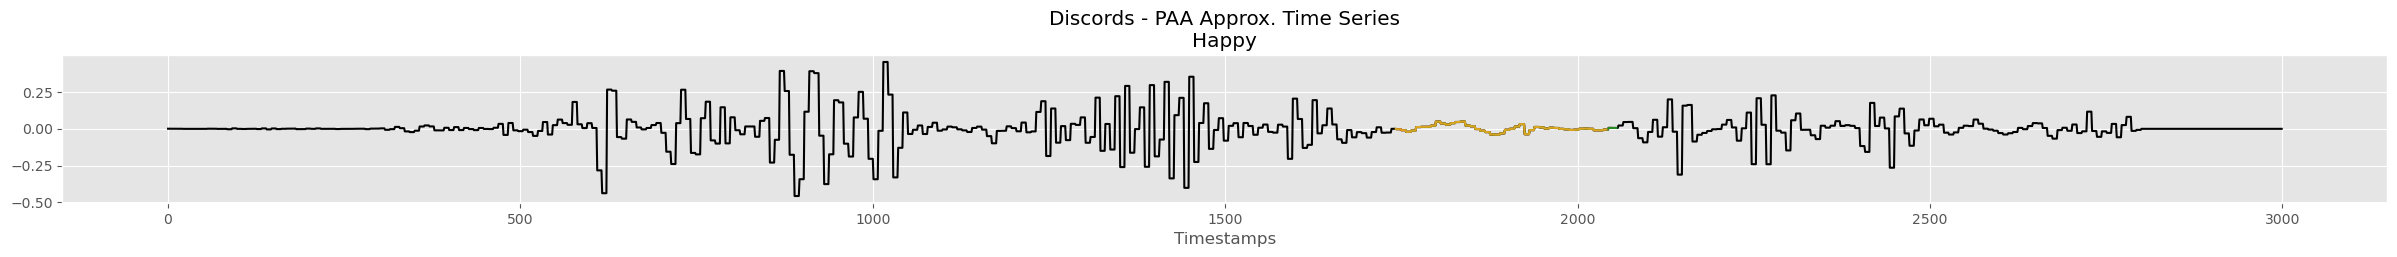

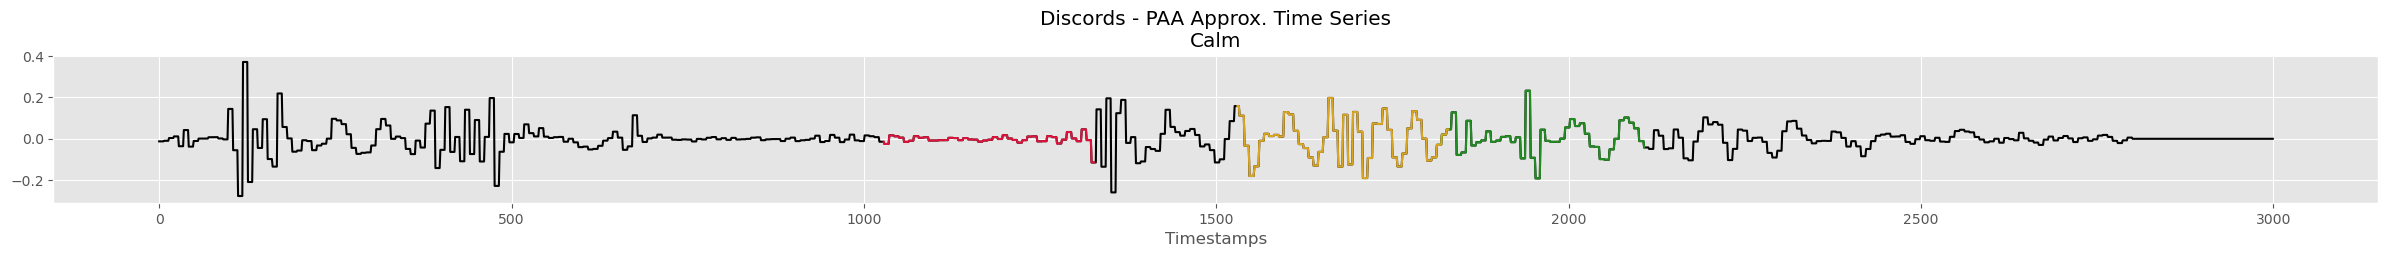

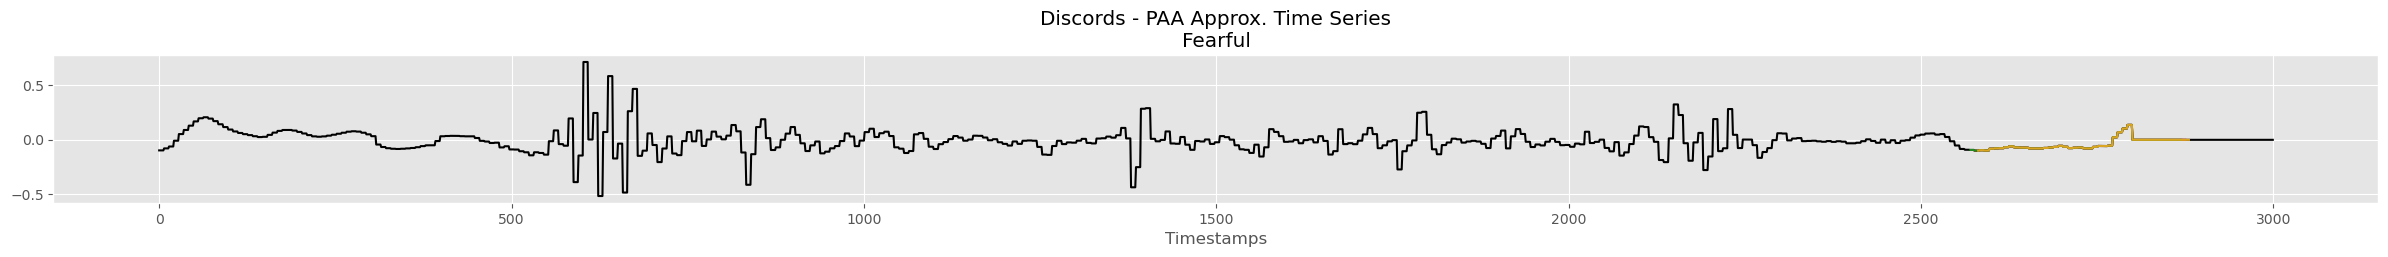

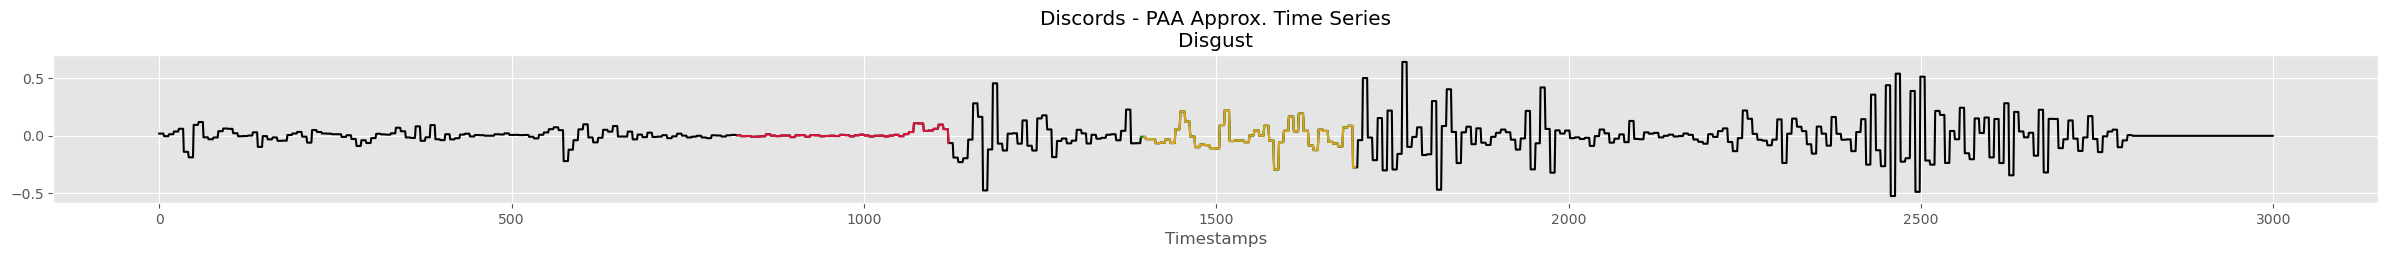

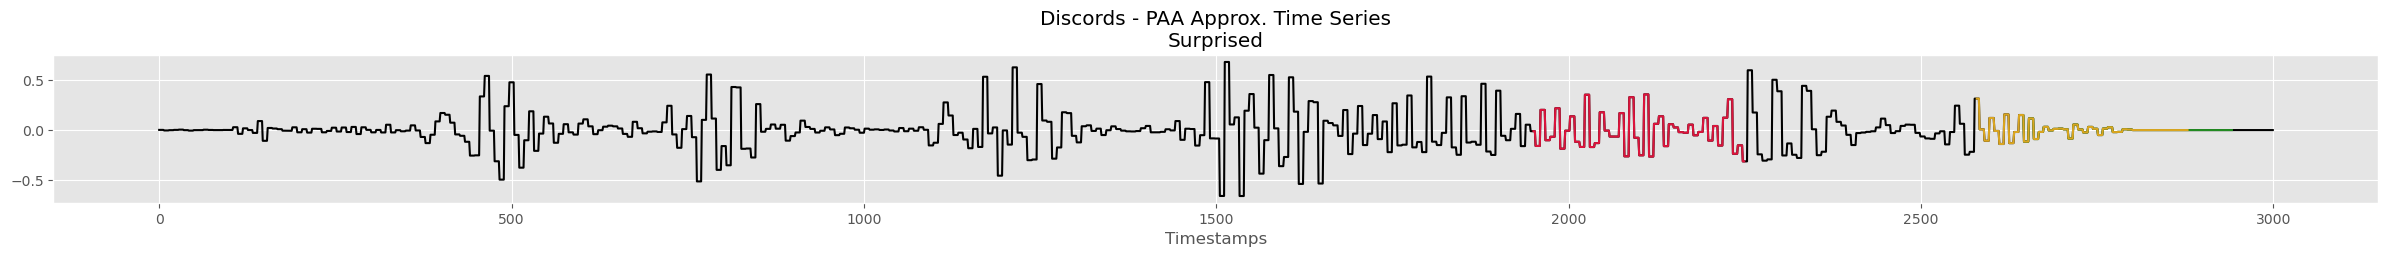

In [34]:
ts_paa = df_paa.iloc[idx_emo, 1:].values
ts = ts_paa.copy()

col = ['darkred','blue','green','crimson','orange','royalblue','skyblue','goldenrod']
n = 0

for x in range(8):
    n += 1
    ts_paa = ts[x]
    mp_paa = mp_dict_paa[x][0]
    
    plt.figure(figsize=(30, 18))
    plt.subplot(8,1,n)
    
    anoms_paa = discords(mp_paa, ex_zone=ex_zone, k=k)
    plt.plot(ts_paa, c='k')
    colors = ['crimson', 'forestgreen', 'goldenrod', 'b', 'y'][:len(mo_paa)]
    for a, c in zip(anoms_paa, colors):
        a_shape = ts_paa[a:a+w]
        plt.plot(range(a, a+w), a_shape, color=c)

    plt.title('Discords - PAA Approx. Time Series\n' + f'{labels[idx_and_emo[x][1]]}'.capitalize())    
    plt.xlabel('Timestamps')